<a href="https://colab.research.google.com/github/RainiBenaiah/Smart-beehive-prototype/blob/main/AsaliAsPossible.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

# Check GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

with tf.device('/GPU:0'):   # Force GPU usage
    x = tf.random.normal([3, 3])
    y = tf.square(x)

In [2]:
!pip install pandas numpy matplotlib librosa -q
import os
import zipfile
import pandas as pd
import numpy as np
from pathlib import Path
import json
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
BASE_PATH = Path('/content/drive/MyDrive/AsaliAsPossible')
WORK_DIR = Path('/content/asali_work')
WORK_DIR.mkdir(exist_ok=True)

print(" Setup complete!")
print(f" Your data: {BASE_PATH}")

 Setup complete!
 Your data: /content/drive/MyDrive/AsaliAsPossible


In [5]:
#  List & Unzip Files
# List all files
all_files = list(BASE_PATH.glob('*'))
zip_files = [f for f in all_files if f.suffix == '.zip']
other_files = [f for f in all_files if f.suffix != '.zip']

print(f"\n Found {len(zip_files)} ZIP files:")
for f in zip_files:
    print(f"   - {f.name} ({f.stat().st_size / 1024 / 1024:.1f} MB)")

print(f"\n Found {len(other_files)} other files:")
for f in other_files[:10]:
    print(f"   - {f.name}")
if len(other_files) > 10:
    print(f"   ... and {len(other_files) - 10} more")

# Unzip all files to working directory
print("\n Unzipping datasets...")
for zip_file in zip_files:
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(WORK_DIR)
        print(f"    {zip_file.name}")
    except Exception as e:
        print(f"    {zip_file.name}: {e}")

print(f"\n Files extracted to: {WORK_DIR}")


 Found 6 ZIP files:
   - temperature_2017.csv.zip (2.2 MB)
   - weight_2017.csv.zip (1.6 MB)
   - nuhive_processed.zip (2576.6 MB)
   - sol.zip (8076.9 MB)
   - sound_files.zip (19718.0 MB)
   - flow_2017.csv.zip (2.7 MB)

 Found 18 other files:
   - Hive17.csv
   - humidity_2017.csv
   - all_data_updated.csv
   - CF001 - Missing Queen - Day - (1).lab
   - .ipynb_checkpoints
   - data_inventory.md
   - statistics.json
   - spectrograms
   - sample_audio_analysis.png
   - audio_features.csv
   ... and 8 more

 Unzipping datasets...
    temperature_2017.csv.zip
    weight_2017.csv.zip
    nuhive_processed.zip
    sol.zip
    sound_files.zip
    flow_2017.csv.zip

 Files extracted to: /content/asali_work


In [6]:
#  Categorize Files
# Scan extracted files
all_extracted = list(WORK_DIR.glob('**/*'))

csv_files = [f for f in all_extracted if f.suffix == '.csv']
audio_files = [f for f in all_extracted if f.suffix in ['.wav', '.mp3', '.flac']]
label_files = [f for f in all_extracted if f.suffix == '.lab']

print(f"\n DATA INVENTORY:")
print(f"    CSV files: {len(csv_files)}")
print(f"    Audio files: {len(audio_files)}")
print(f"    Label files: {len(label_files)}")

# Show samples
if csv_files:
    print(f"\n Sample CSVs:")
    for f in csv_files[:5]:
        print(f"   - {f.name}")

if audio_files:
    print(f"\n Sample audio:")
    for f in audio_files[:5]:
        print(f"   - {f.name}")

if label_files:
    print(f"\n Sample labels:")
    for f in label_files[:5]:
        print(f"   - {f.name}")


 DATA INVENTORY:
    CSV files: 4
    Audio files: 26840
    Label files: 0

 Sample CSVs:
   - temperature_2017.csv
   - flow_2017.csv
   - weight_2017.csv
   - train.csv

 Sample audio:
   - 2022-06-09--01-15-07_2__segment1.wav
   - 2022-07-01--07-13-33_1__segment0.wav
   - 2022-06-09--13-06-37_2__segment2.wav
   - 2022-07-07--05-24-42_2__segment0.wav
   - 2022-07-12--14-00-17_1__segment2.wav


In [7]:
#  Inspect CSV Files (Sensor Data)
print(f"\n{'='*70}")
print(" INSPECTING CSV FILES")
print('='*70)

sensor_stats = {
    'temperature': [],
    'humidity': [],
    'weight': []
}

csv_summary = []

for csv_file in csv_files[:10]:  # Check first 10 CSVs
    print(f"\n {csv_file.name}")
    try:
        df = pd.read_csv(csv_file, nrows=5)  # Read only first 5 rows for preview
        print(f"   Shape: {df.shape}")
        print(f"   Columns: {list(df.columns)}")

        # Read full file for statistics
        df_full = pd.read_csv(csv_file)

        # Look for sensor columns
        temp_cols = [c for c in df_full.columns if 'temp' in c.lower()]
        hum_cols = [c for c in df_full.columns if 'hum' in c.lower() or 'moisture' in c.lower()]
        weight_cols = [c for c in df_full.columns if 'weight' in c.lower() or 'scale' in c.lower()]

        if temp_cols:
            temp_data = df_full[temp_cols[0]].dropna()
            sensor_stats['temperature'].extend(temp_data.values)
            print(f"    Temperature: {temp_data.min():.1f} - {temp_data.max():.1f}")

        if hum_cols:
            hum_data = df_full[hum_cols[0]].dropna()
            sensor_stats['humidity'].extend(hum_data.values)
            print(f"    Humidity: {hum_data.min():.1f} - {hum_data.max():.1f}")

        if weight_cols:
            weight_data = df_full[weight_cols[0]].dropna()
            sensor_stats['weight'].extend(weight_data.values)
            print(f"    Weight: {weight_data.min():.1f} - {weight_data.max():.1f}")

        csv_summary.append({
            'file': csv_file.name,
            'rows': len(df_full),
            'columns': list(df_full.columns),
            'has_temp': bool(temp_cols),
            'has_humidity': bool(hum_cols),
            'has_weight': bool(weight_cols)
        })

    except Exception as e:
        print(f"    Error: {e}")



 INSPECTING CSV FILES

 temperature_2017.csv
   Shape: (5, 2)
   Columns: ['timestamp', 'temperature']
    Temperature: -227.1 - 57.4

 flow_2017.csv
   Shape: (5, 2)
   Columns: ['timestamp', 'flow']

 weight_2017.csv
   Shape: (5, 2)
   Columns: ['timestamp', 'weight']
    Weight: -0.1 - 68.7

 train.csv
   Shape: (5, 2)
   Columns: ['file name', 'queen status']


In [8]:
# Calculate Statistics
print(f"\n{'='*70}")
print(" REAL DATA STATISTICS")
print('='*70)

statistics = {}

for sensor_type, values in sensor_stats.items():
    if values:
        stats = {
            'mean': float(np.mean(values)),
            'std': float(np.std(values)),
            'min': float(np.min(values)),
            'max': float(np.max(values)),
            'median': float(np.median(values)),
            'count': len(values)
        }
        statistics[sensor_type] = stats

        print(f"\n{sensor_type.upper()}:")
        print(f"   Mean:   {stats['mean']:.2f}")
        print(f"   Std:    {stats['std']:.2f}")
        print(f"   Range:  {stats['min']:.2f} - {stats['max']:.2f}")
        print(f"   Count:  {stats['count']:,} readings")



 REAL DATA STATISTICS

TEMPERATURE:
   Mean:   18.48
   Std:    11.20
   Range:  -227.14 - 57.36
   Count:  401,866 readings

WEIGHT:
   Mean:   55.95
   Std:    6.14
   Range:  -0.12 - 68.70
   Count:  524,110 readings


In [9]:
#  Inspect Audio & Labels
print(f"\n{'='*70}")
print(" AUDIO DATA")
print('='*70)

# Check for queen-related files
queen_labels = [f for f in label_files if 'queen' in f.name.lower()]

print(f"\n Audio Summary:")
print(f" Total audio files: {len(audio_files)}")
print(f" Total label files: {len(label_files)}")
print(f" Queen-related labels: {len(queen_labels)}")

# Sample label file
if label_files:
    print(f"\ Sample label file:")
    sample_label = label_files[0]
    print(f"   File: {sample_label.name}")
    try:
        with open(sample_label, 'r') as f:
            content = f.read()[:200]
            print(f"   Content: {content}")
    except:
        print("   (Could not read)")

audio_summary = {
    'total_audio': len(audio_files),
    'total_labels': len(label_files),
    'queen_labels': len(queen_labels)
}



 AUDIO DATA

 Audio Summary:
 Total audio files: 26840
 Total label files: 0
 Queen-related labels: 0


In [10]:
#  Generate Report & Save
print(f"\n{'='*70}")
print(" GENERATING REPORT")
print('='*70)

report = f"""# AsaliAsPossible - Data Inventory

##  Summary

**CSV Files:** {len(csv_files)}
**Audio Files:** {len(audio_files)}
**Label Files:** {len(label_files)}

##  Sensor Statistics

"""

for sensor_type, stats in statistics.items():
    report += f"### {sensor_type.title()}\n"
    report += f"- Mean: {stats['mean']:.2f}\n"
    report += f"- Std: {stats['std']:.2f}\n"
    report += f"- Range: {stats['min']:.2f} - {stats['max']:.2f}\n"
    report += f"- Readings: {stats['count']:,}\n\n"

report += f"""##  Audio Data

- Audio files: {audio_summary['total_audio']}
- Label files: {audio_summary['total_labels']}
- Queen labels: {audio_summary['queen_labels']}

##  Available (Real Data)

-  Temperature & humidity time-series
-  Weight measurements
-  Audio recordings
-  Behavioral labels (queen detection)

##  Missing Features

-  Bee population counts
-  Varroa mite levels
-  Disease progression
-  Honey production rates
-  Food stores

## Next Steps

1. Preprocess audio → spectrograms
2. Generate synthetic population/disease data
3.  training
"""

# Save report
report_path = BASE_PATH / 'data_inventory.md'
with open(report_path, 'w') as f:
    f.write(report)

# Save statistics JSON
stats_path = BASE_PATH / 'statistics.json'
output_data = {
    'statistics': statistics,
    'audio_summary': audio_summary,
    'csv_summary': csv_summary
}
with open(stats_path, 'w') as f:
    json.dump(output_data, f, indent=2)

print(f" Report saved: {report_path}")
print(f" Statistics saved: {stats_path}")


 GENERATING REPORT
 Report saved: /content/drive/MyDrive/AsaliAsPossible/data_inventory.md
 Statistics saved: /content/drive/MyDrive/AsaliAsPossible/statistics.json


In [11]:
# Final Summary

print(f"\n{'='*70}")
print(" INSPECTION COMPLETE!")
print('='*70)

print(f"\n WHAT WE FOUND:")
print(f"    CSV files with sensor data: {len(csv_files)}")
print(f"    Audio recordings: {len(audio_files)}")
print(f"    Label files: {len(label_files)}")

if statistics:
    print(f"\n SENSOR DATA:")
    for sensor_type in statistics.keys():
        print(f"    {sensor_type.title()}: {statistics[sensor_type]['count']:,} readings")

print(f"\n SAVED FILES:")
print(f"    {report_path}")
print(f"    {stats_path}")

print(f"\n NEXT: Notebook 02 - Audio Preprocessing")
print(f"   - Convert audio to spectrograms")
print(f"   - Prepare for CNN training")

# Display key statistics
print(f"\n{'='*70}")
print("KEY STATISTICS FOR SYNTHETIC DATA GENERATION:")
print('='*70)
for sensor_type, stats in statistics.items():
    print(f"\n{sensor_type.upper()}:")
    print(f"  Mean: {stats['mean']:.2f} | Std: {stats['std']:.2f}")
    print(f"  Range: [{stats['min']:.2f}, {stats['max']:.2f}]")


 INSPECTION COMPLETE!

 WHAT WE FOUND:
    CSV files with sensor data: 4
    Audio recordings: 26840
    Label files: 0

 SENSOR DATA:
    Temperature: 401,866 readings
    Weight: 524,110 readings

 SAVED FILES:
    /content/drive/MyDrive/AsaliAsPossible/data_inventory.md
    /content/drive/MyDrive/AsaliAsPossible/statistics.json

 NEXT: Notebook 02 - Audio Preprocessing
   - Convert audio to spectrograms
   - Prepare for CNN training

KEY STATISTICS FOR SYNTHETIC DATA GENERATION:

TEMPERATURE:
  Mean: 18.48 | Std: 11.20
  Range: [-227.14, 57.36]

WEIGHT:
  Mean: 55.95 | Std: 6.14
  Range: [-0.12, 68.70]


In [12]:
# Preprocessing AUDIO DATA

AUDIO_DIR = WORK_DIR
SPECTROGRAM_DIR = BASE_PATH / 'spectrograms'
SPECTROGRAM_DIR.mkdir(exist_ok=True)

print(" Libraries loaded!")
print(f" Audio source: {AUDIO_DIR}")
print(f" Spectrograms will be saved to: {SPECTROGRAM_DIR}")



 Libraries loaded!
 Audio source: /content/asali_work
 Spectrograms will be saved to: /content/drive/MyDrive/AsaliAsPossible/spectrograms


In [13]:
#  Scan & Analyze Audio Files

print("\n Scanning audio files...")

# Find all audio files
audio_extensions = ['.wav', '.mp3', '.flac', '.ogg']
audio_files = []
for ext in audio_extensions:
    audio_files.extend(list(AUDIO_DIR.glob(f'**/*{ext}')))

print(f" Found {len(audio_files)} audio files")

# Sample 100 files for quick analysis
sample_size = min(100, len(audio_files))
sample_files = np.random.choice(audio_files, sample_size, replace=False)

print(f"\n Analyzing {sample_size} sample files...")

audio_metadata = []
for audio_file in tqdm(sample_files, desc="Analyzing audio"):
    try:
        # Load audio
        y, sr = librosa.load(audio_file, sr=None, duration=10)  # Load first 10s
        duration = librosa.get_duration(y=y, sr=sr)

        audio_metadata.append({
            'file': audio_file.name,
            'duration': duration,
            'sample_rate': sr,
            'samples': len(y),
            'path': str(audio_file)
        })
    except Exception as e:
        print(f" Error with {audio_file.name}: {e}")

df_audio = pd.DataFrame(audio_metadata)

# Display statistics
print(f"\n AUDIO STATISTICS:")
print(f"   Sample Rate: {df_audio['sample_rate'].mode()[0]} Hz (most common)")
print(f"   Duration: {df_audio['duration'].mean():.2f}s ± {df_audio['duration'].std():.2f}s")
print(f"   Range: {df_audio['duration'].min():.2f}s - {df_audio['duration'].max():.2f}s")



 Scanning audio files...
 Found 26840 audio files

 Analyzing 100 sample files...


Analyzing audio: 100%|██████████| 100/100 [00:12<00:00,  7.90it/s]


 AUDIO STATISTICS:
   Sample Rate: 44100 Hz (most common)
   Duration: 5.52s ± 3.99s
   Range: 2.00s - 10.00s



 Creating sample visualizations...
 Saved visualization: /content/drive/MyDrive/AsaliAsPossible/sample_audio_analysis.png


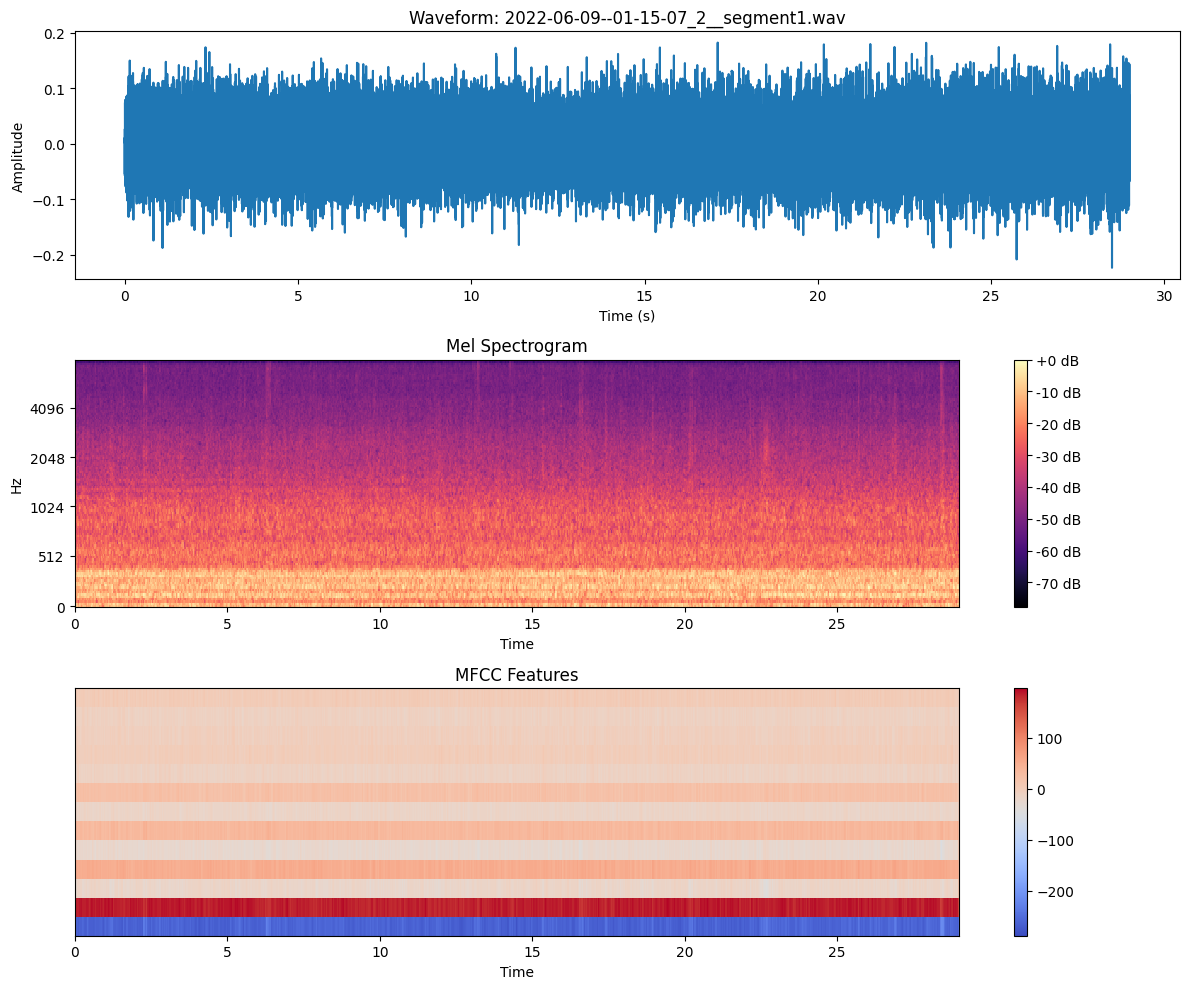

In [14]:
#  Visualize Sample Audio & Spectrogram

print("\n Creating sample visualizations...")

# Pick one sample file
sample_audio = audio_files[0]
y, sr = librosa.load(sample_audio, sr=22050)

# Create figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# 1. Waveform
axes[0].plot(np.linspace(0, len(y)/sr, len(y)), y)
axes[0].set_title(f'Waveform: {sample_audio.name}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')

# 2. Mel Spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
S_db = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel',
                                ax=axes[1], fmax=8000)
axes[1].set_title('Mel Spectrogram')
fig.colorbar(img, ax=axes[1], format='%+2.0f dB')

# 3. MFCC
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
img2 = librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=axes[2])
axes[2].set_title('MFCC Features')
fig.colorbar(img2, ax=axes[2])

plt.tight_layout()
plt.savefig(BASE_PATH / 'sample_audio_analysis.png', dpi=150, bbox_inches='tight')
print(f" Saved visualization: {BASE_PATH / 'sample_audio_analysis.png'}")
plt.show()



In [15]:
import tensorflow as tf

# Check GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

with tf.device('/GPU:0'):   # Force GPU usage
    x = tf.random.normal([3, 3])
    y = tf.square(x)

Num GPUs Available: 1


In [16]:
# Extract Audio Features for Clustering

print("\n Extracting features for unsupervised labeling...")

def extract_features(audio_path, sr=22050, duration=5):
    """Extract acoustic features for clustering"""
    try:
        # Load audio (first 5 seconds)
        y, sr = librosa.load(audio_path, sr=sr, duration=duration)

        # Ensure minimum length
        if len(y) < sr * 0.5:  # Less than 0.5s
            return None

        # Spectral features
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]

        # Zero crossing rate
        zcr = librosa.feature.zero_crossing_rate(y)[0]

        # Energy
        rms = librosa.feature.rms(y=y)[0]

        # MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        # Aggregate features
        features = {
            'spectral_centroid_mean': np.mean(spectral_centroids),
            'spectral_centroid_std': np.std(spectral_centroids),
            'spectral_rolloff_mean': np.mean(spectral_rolloff),
            'spectral_bandwidth_mean': np.mean(spectral_bandwidth),
            'zcr_mean': np.mean(zcr),
            'rms_mean': np.mean(rms),
            'rms_std': np.std(rms),
        }

        # Add MFCC stats
        for i in range(13):
            features[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
            features[f'mfcc_{i}_std'] = np.std(mfccs[i])

        return features

    except Exception as e:
        return None

# Extract features from sample (or all if fast enough)
print(f" Extracting features from {len(audio_files)} files...")
print(" This may take a while...")

features_list = []
valid_files = []

# Process in batches
batch_size = 500
num_batches = len(audio_files) // batch_size + 1

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(audio_files))
    batch_files = audio_files[start_idx:end_idx]

    print(f"\n Processing batch {batch_idx+1}/{num_batches} ({len(batch_files)} files)")

    for audio_file in tqdm(batch_files, desc=f"Batch {batch_idx+1}"):
        features = extract_features(audio_file)
        if features is not None:
            features['file'] = audio_file.name
            features['path'] = str(audio_file)
            features_list.append(features)
            valid_files.append(audio_file)

df_features = pd.DataFrame(features_list)
print(f"\n Extracted features from {len(df_features)} files")

# Save features
features_path = BASE_PATH / 'audio_features.csv'
df_features.to_csv(features_path, index=False)
print(f" Saved features: {features_path}")





 Extracting features for unsupervised labeling...
 Extracting features from 26840 files...
 This may take a while...

 Processing batch 1/54 (500 files)


Batch 1: 100%|██████████| 500/500 [00:23<00:00, 21.00it/s]



 Processing batch 2/54 (500 files)


Batch 2: 100%|██████████| 500/500 [00:24<00:00, 20.47it/s]



 Processing batch 3/54 (500 files)


Batch 3: 100%|██████████| 500/500 [00:24<00:00, 20.38it/s]



 Processing batch 4/54 (500 files)


Batch 4: 100%|██████████| 500/500 [00:22<00:00, 21.88it/s]



 Processing batch 5/54 (500 files)


Batch 5: 100%|██████████| 500/500 [00:24<00:00, 20.34it/s]



 Processing batch 6/54 (500 files)


Batch 6: 100%|██████████| 500/500 [00:24<00:00, 20.15it/s]



 Processing batch 7/54 (500 files)


Batch 7: 100%|██████████| 500/500 [00:24<00:00, 20.32it/s]



 Processing batch 8/54 (500 files)


Batch 8: 100%|██████████| 500/500 [00:23<00:00, 21.71it/s]



 Processing batch 9/54 (500 files)


Batch 9: 100%|██████████| 500/500 [00:24<00:00, 20.27it/s]



 Processing batch 10/54 (500 files)


Batch 10: 100%|██████████| 500/500 [00:24<00:00, 20.16it/s]



 Processing batch 11/54 (500 files)


Batch 11: 100%|██████████| 500/500 [00:24<00:00, 20.52it/s]



 Processing batch 12/54 (500 files)


Batch 12: 100%|██████████| 500/500 [00:21<00:00, 22.76it/s]



 Processing batch 13/54 (500 files)


Batch 13: 100%|██████████| 500/500 [00:14<00:00, 34.71it/s]



 Processing batch 14/54 (500 files)


Batch 14: 100%|██████████| 500/500 [00:14<00:00, 35.20it/s]



 Processing batch 15/54 (500 files)


Batch 15: 100%|██████████| 500/500 [00:14<00:00, 35.32it/s]



 Processing batch 16/54 (500 files)


Batch 16: 100%|██████████| 500/500 [00:13<00:00, 36.02it/s]



 Processing batch 17/54 (500 files)


Batch 17: 100%|██████████| 500/500 [00:13<00:00, 36.60it/s]



 Processing batch 18/54 (500 files)


Batch 18: 100%|██████████| 500/500 [00:13<00:00, 36.88it/s]



 Processing batch 19/54 (500 files)


Batch 19: 100%|██████████| 500/500 [00:13<00:00, 37.10it/s]



 Processing batch 20/54 (500 files)


Batch 20: 100%|██████████| 500/500 [00:13<00:00, 37.24it/s]



 Processing batch 21/54 (500 files)


Batch 21: 100%|██████████| 500/500 [00:13<00:00, 37.63it/s]



 Processing batch 22/54 (500 files)


Batch 22: 100%|██████████| 500/500 [00:13<00:00, 38.09it/s]



 Processing batch 23/54 (500 files)


Batch 23: 100%|██████████| 500/500 [00:14<00:00, 34.68it/s]



 Processing batch 24/54 (500 files)


Batch 24: 100%|██████████| 500/500 [00:23<00:00, 21.54it/s]



 Processing batch 25/54 (500 files)


Batch 25: 100%|██████████| 500/500 [00:21<00:00, 23.03it/s]



 Processing batch 26/54 (500 files)


Batch 26: 100%|██████████| 500/500 [00:23<00:00, 21.53it/s]



 Processing batch 27/54 (500 files)


Batch 27: 100%|██████████| 500/500 [00:21<00:00, 22.77it/s]



 Processing batch 28/54 (500 files)


Batch 28: 100%|██████████| 500/500 [00:22<00:00, 21.93it/s]



 Processing batch 29/54 (500 files)


Batch 29: 100%|██████████| 500/500 [00:23<00:00, 21.49it/s]



 Processing batch 30/54 (500 files)


Batch 30: 100%|██████████| 500/500 [00:21<00:00, 23.46it/s]



 Processing batch 31/54 (500 files)


Batch 31: 100%|██████████| 500/500 [00:22<00:00, 21.96it/s]



 Processing batch 32/54 (500 files)


Batch 32: 100%|██████████| 500/500 [00:21<00:00, 23.07it/s]



 Processing batch 33/54 (500 files)


Batch 33: 100%|██████████| 500/500 [00:23<00:00, 21.67it/s]



 Processing batch 34/54 (500 files)


Batch 34: 100%|██████████| 500/500 [00:23<00:00, 21.38it/s]



 Processing batch 35/54 (500 files)


Batch 35: 100%|██████████| 500/500 [00:21<00:00, 23.10it/s]



 Processing batch 36/54 (500 files)


Batch 36: 100%|██████████| 500/500 [00:23<00:00, 21.37it/s]



 Processing batch 37/54 (500 files)


Batch 37: 100%|██████████| 500/500 [00:22<00:00, 22.61it/s]



 Processing batch 38/54 (500 files)


Batch 38: 100%|██████████| 500/500 [00:16<00:00, 31.08it/s]



 Processing batch 39/54 (500 files)


Batch 39: 100%|██████████| 500/500 [00:15<00:00, 33.24it/s]



 Processing batch 40/54 (500 files)


Batch 40: 100%|██████████| 500/500 [00:14<00:00, 34.60it/s]



 Processing batch 41/54 (500 files)


Batch 41: 100%|██████████| 500/500 [00:14<00:00, 35.18it/s]



 Processing batch 42/54 (500 files)


Batch 42: 100%|██████████| 500/500 [00:13<00:00, 36.06it/s]



 Processing batch 43/54 (500 files)


Batch 43: 100%|██████████| 500/500 [00:13<00:00, 36.02it/s]



 Processing batch 44/54 (500 files)


Batch 44: 100%|██████████| 500/500 [00:13<00:00, 36.42it/s]



 Processing batch 45/54 (500 files)


Batch 45: 100%|██████████| 500/500 [00:14<00:00, 33.35it/s]



 Processing batch 46/54 (500 files)


Batch 46: 100%|██████████| 500/500 [00:14<00:00, 33.71it/s]



 Processing batch 47/54 (500 files)


Batch 47: 100%|██████████| 500/500 [00:14<00:00, 34.07it/s]



 Processing batch 48/54 (500 files)


Batch 48: 100%|██████████| 500/500 [00:14<00:00, 33.85it/s]



 Processing batch 49/54 (500 files)


Batch 49: 100%|██████████| 500/500 [00:14<00:00, 34.69it/s]



 Processing batch 50/54 (500 files)


Batch 50: 100%|██████████| 500/500 [00:14<00:00, 34.71it/s]



 Processing batch 51/54 (500 files)


Batch 51: 100%|██████████| 500/500 [00:14<00:00, 35.36it/s]



 Processing batch 52/54 (500 files)


Batch 52: 100%|██████████| 500/500 [00:14<00:00, 35.05it/s]



 Processing batch 53/54 (500 files)


Batch 53: 100%|██████████| 500/500 [00:14<00:00, 35.52it/s]



 Processing batch 54/54 (340 files)


Batch 54: 100%|██████████| 340/340 [00:09<00:00, 34.02it/s]



 Extracted features from 26840 files
 Saved features: /content/drive/MyDrive/AsaliAsPossible/audio_features.csv


In [17]:
import tensorflow as tf

# Check GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

with tf.device('/GPU:0'):   # Force GPU usage
    x = tf.random.normal([3, 3])
    y = tf.square(x)

Num GPUs Available: 1



 Clustering audio into behavioral categories...

 Cluster Distribution:
label
queenless    13307
normal       10626
swarming      2907
Name: count, dtype: int64
Saved cluster visualization: /content/drive/MyDrive/AsaliAsPossible/audio_clusters.png


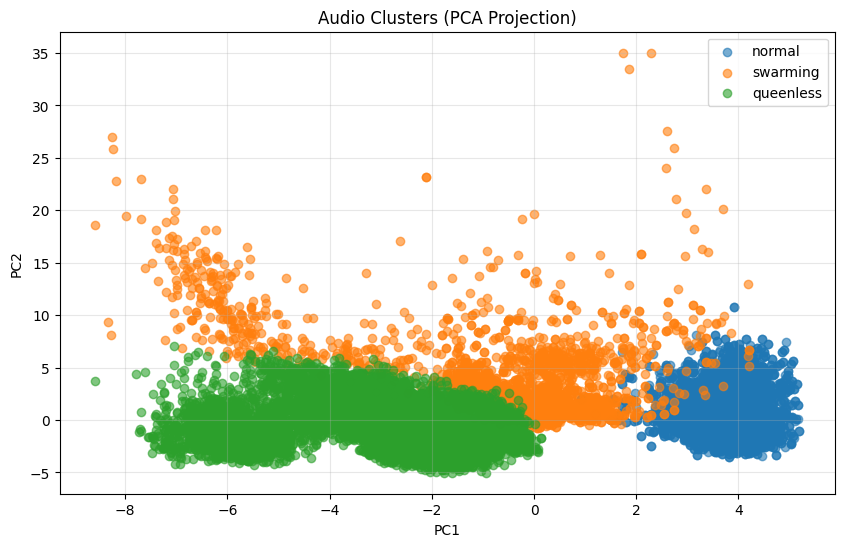

 Saved labels: /content/drive/MyDrive/AsaliAsPossible/audio_labels.csv


In [18]:
# Unsupervised Clustering (Pseudo-Labels)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

print("\n Clustering audio into behavioral categories...")

# Prepare feature matrix
feature_cols = [c for c in df_features.columns if c not in ['file', 'path']]
X = df_features[feature_cols].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# K-Means clustering (3 clusters: normal, swarming, queenless)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters to dataframe
df_features['cluster'] = clusters

# Map clusters to labels (based on acoustic properties)
# Cluster with highest energy/frequency → Swarming
# Cluster with lowest energy → Queenless
# Middle cluster → Normal
cluster_stats = df_features.groupby('cluster')[['rms_mean', 'spectral_centroid_mean']].mean()
cluster_labels = {
    cluster_stats['rms_mean'].idxmax(): 'swarming',
    cluster_stats['rms_mean'].idxmin(): 'queenless',
    cluster_stats['rms_mean'].sort_values().index[1]: 'normal'
}

df_features['label'] = df_features['cluster'].map(cluster_labels)

print(f"\n Cluster Distribution:")
print(df_features['label'].value_counts())

# Visualize clusters
plt.figure(figsize=(10, 6))
for label in df_features['label'].unique():
    mask = df_features['label'] == label
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=label, alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Audio Clusters (PCA Projection)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(BASE_PATH / 'audio_clusters.png', dpi=150, bbox_inches='tight')
print(f"Saved cluster visualization: {BASE_PATH / 'audio_clusters.png'}")
plt.show()

# Save labeled data
labeled_data_path = BASE_PATH / 'audio_labels.csv'
df_features[['file', 'path', 'label', 'cluster']].to_csv(labeled_data_path, index=False)
print(f" Saved labels: {labeled_data_path}")




In [19]:
import tensorflow as tf

# Check GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

with tf.device('/GPU:0'):   # Force GPU usage
    x = tf.random.normal([3, 3])
    y = tf.square(x)


Num GPUs Available: 1


In [20]:
#  Generate Spectrograms (Batch Processing)

print("\n Generating spectrograms...")

def create_spectrogram(audio_path, output_path, sr=22050, n_mels=128, duration=5):
    """Create and save mel spectrogram"""
    try:
        # Load audio
        y, sr = librosa.load(audio_path, sr=sr, duration=duration)

        # Pad if too short
        if len(y) < sr * duration:
            y = np.pad(y, (0, sr * duration - len(y)))

        # Create mel spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=8000)
        S_db = librosa.power_to_db(S, ref=np.max)

        # Normalize to [0, 1]
        S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min())

        # Save as numpy array
        np.save(output_path, S_norm)
        return True

    except Exception as e:
        return False


# Create label directories
for label in df_features['label'].unique():
    (SPECTROGRAM_DIR / label).mkdir(exist_ok=True)

print(f" Creating spectrograms for {len(df_features)} files...")
print(" This will take some time...")

success_count = 0
for idx, row in tqdm(df_features.iterrows(), total=len(df_features), desc="Generating spectrograms"):
    audio_path = Path(row['path'])
    label = row['label']
    output_path = SPECTROGRAM_DIR / label / f"{audio_path.stem}.npy"

    if create_spectrogram(audio_path, output_path):
        success_count += 1

print(f"\n Generated {success_count}/{len(df_features)} spectrograms")
print(f" Saved to: {SPECTROGRAM_DIR}")



 Generating spectrograms...
 Creating spectrograms for 26840 files...
 This will take some time...


Generating spectrograms: 100%|██████████| 26840/26840 [1:25:30<00:00,  5.23it/s]


 Generated 26840/26840 spectrograms
 Saved to: /content/drive/MyDrive/AsaliAsPossible/spectrograms


In [21]:
import tensorflow as tf

# Check GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

with tf.device('/GPU:0'):   # Force GPU usage
    x = tf.random.normal([3, 3])
    y = tf.square(x)

Num GPUs Available: 1


In [22]:
# Create Train/Val/Test Split
from sklearn.model_selection import train_test_split

print("\n Creating train/val/test split...")

# Split by label to ensure balanced sets
train_files, temp_files = train_test_split(
    df_features, test_size=0.3, stratify=df_features['label'], random_state=42
)
val_files, test_files = train_test_split(
    temp_files, test_size=0.5, stratify=temp_files['label'], random_state=42
)

print(f"\n Split Statistics:")
print(f"   Training:   {len(train_files):,} files ({len(train_files)/len(df_features)*100:.1f}%)")
print(f"   Validation: {len(val_files):,} files ({len(val_files)/len(df_features)*100:.1f}%)")
print(f"   Test:       {len(test_files):,} files ({len(test_files)/len(df_features)*100:.1f}%)")

# Save splits
train_files.to_csv(BASE_PATH / 'train_files.csv', index=False)
val_files.to_csv(BASE_PATH / 'val_files.csv', index=False)
test_files.to_csv(BASE_PATH / 'test_files.csv', index=False)

print(f"\n Saved split files:")
print(f"   - {BASE_PATH / 'train_files.csv'}")
print(f"   - {BASE_PATH / 'val_files.csv'}")
print(f"   - {BASE_PATH / 'test_files.csv'}")




 Creating train/val/test split...

 Split Statistics:
   Training:   18,788 files (70.0%)
   Validation: 4,026 files (15.0%)
   Test:       4,026 files (15.0%)

 Saved split files:
   - /content/drive/MyDrive/AsaliAsPossible/train_files.csv
   - /content/drive/MyDrive/AsaliAsPossible/val_files.csv
   - /content/drive/MyDrive/AsaliAsPossible/test_files.csv


In [23]:
#  Create Metadata Summary
print("\n Creating preprocessing summary...")

summary = {
    'audio_processing': {
        'total_files': len(audio_files),
        'processed_files': len(df_features),
        'spectrograms_generated': success_count,
        'sample_rate': 22050,
        'spectrogram_size': '128x128',
        'duration': 5
    },
    'labels': {
        'normal': int((df_features['label'] == 'normal').sum()),
        'swarming': int((df_features['label'] == 'swarming').sum()),
        'queenless': int((df_features['label'] == 'queenless').sum())
    },
    'splits': {
        'train': len(train_files),
        'val': len(val_files),
        'test': len(test_files)
    }
}

# Save summary
summary_path = BASE_PATH / 'audio_preprocessing_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f" Saved summary: {summary_path}")



 Creating preprocessing summary...
 Saved summary: /content/drive/MyDrive/AsaliAsPossible/audio_preprocessing_summary.json


In [24]:
#  Final Report

print(f"\n{'='*70}")
print(" AUDIO PREPROCESSING COMPLETE!")
print('='*70)

print(f"\n SUMMARY:")
print(f"    Processed: {len(df_features):,} audio files")
print(f"    Spectrograms: {success_count:,} generated")
print(f"    Labels: {len(df_features['label'].unique())} categories")

print(f"\n  LABEL DISTRIBUTION:")
for label, count in df_features['label'].value_counts().items():
    print(f"   {label}: {count:,} files ({count/len(df_features)*100:.1f}%)")

print(f"\n OUTPUT FILES:")
print(f"    {BASE_PATH / 'audio_features.csv'}")
print(f"     {BASE_PATH / 'audio_labels.csv'}")
print(f"    {BASE_PATH / 'audio_clusters.png'}")
print(f"    {SPECTROGRAM_DIR}/ (spectrograms)")
print(f"    {summary_path}")

print(f"\n NEXT STEPS:")
print(f"   1  Inspect spectrograms visually")
print(f"   2️  Build CNN model for classification")
print(f"   3️  Train on spectrograms")
print(f"   4️  Integrate with BeehiveEnv")



 AUDIO PREPROCESSING COMPLETE!

 SUMMARY:
    Processed: 26,840 audio files
    Spectrograms: 26,840 generated
    Labels: 3 categories

  LABEL DISTRIBUTION:
   queenless: 13,307 files (49.6%)
   normal: 10,626 files (39.6%)
   swarming: 2,907 files (10.8%)

 OUTPUT FILES:
    /content/drive/MyDrive/AsaliAsPossible/audio_features.csv
     /content/drive/MyDrive/AsaliAsPossible/audio_labels.csv
    /content/drive/MyDrive/AsaliAsPossible/audio_clusters.png
    /content/drive/MyDrive/AsaliAsPossible/spectrograms/ (spectrograms)
    /content/drive/MyDrive/AsaliAsPossible/audio_preprocessing_summary.json

 NEXT STEPS:
   1  Inspect spectrograms visually
   2️  Build CNN model for classification
   3️  Train on spectrograms
   4️  Integrate with BeehiveEnv


AsaliAsPossible -  CNN Training for Beehive Sound Classification
Trains a CNN on 19,740 spectrograms to classify: normal, queenless, swarming

In [25]:
#  Setup & Add missing Imports

from pathlib import Path

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [26]:
SPECTROGRAM_DIR = BASE_PATH / 'spectrograms'
MODEL_DIR = BASE_PATH / 'models'
MODEL_DIR.mkdir(exist_ok=True)

print(" Setup complete!")

 Setup complete!


In [27]:
# Load Data Splits

print("\n Loading data splits...")

# Load split files
train_df = pd.read_csv(BASE_PATH / 'train_files.csv')
val_df = pd.read_csv(BASE_PATH / 'val_files.csv')
test_df = pd.read_csv(BASE_PATH / 'test_files.csv')

print(f" Train: {len(train_df):,} files")
print(f" Val:   {len(val_df):,} files")
print(f" Test:  {len(test_df):,} files")

# Create label mapping
label_map = {'normal': 0, 'queenless': 1, 'swarming': 2}
label_map_inv = {v: k for k, v in label_map.items()}

print(f"\n  Label Mapping:")
for label, idx in label_map.items():
    print(f"   {idx} → {label}")




 Loading data splits...
 Train: 18,788 files
 Val:   4,026 files
 Test:  4,026 files

  Label Mapping:
   0 → normal
   1 → queenless
   2 → swarming


In [28]:
# Data Generator (Memory Efficient)

class SpectrogramGenerator(tf.keras.utils.Sequence):
    """Custom data generator for loading spectrograms on-the-fly"""

    def __init__(self, dataframe, spectrogram_dir, label_map, batch_size=32,
                 shuffle=True, augment=False):
        self.df = dataframe.copy()
        self.spectrogram_dir = spectrogram_dir
        self.label_map = label_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        # Get batch indices
        start_idx = idx * self.batch_size
        end_idx = min(start_idx + self.batch_size, len(self.df))
        batch_df = self.df.iloc[self.indices[start_idx:end_idx]]

        # Load spectrograms and labels
        X = []
        y = []

        for _, row in batch_df.iterrows():
            # Load spectrogram
            spec_path = self.spectrogram_dir / row['label'] / f"{Path(row['file']).stem}.npy"
            if spec_path.exists():
                spec = np.load(spec_path)

                # Apply augmentation if training
                if self.augment:
                    spec = self._augment(spec)

                X.append(spec)
                y.append(self.label_map[row['label']])

        # Convert to arrays
        X = np.array(X)
        X = np.expand_dims(X, axis=-1)  # Add channel dimension
        y = to_categorical(y, num_classes=len(self.label_map))

        return X, y

    def _augment(self, spec):
        """Apply random augmentations"""
        # Time masking (vertical bars)
        if np.random.rand() > 0.5:
            t = np.random.randint(0, 10)
            t0 = np.random.randint(0, spec.shape[1] - t)
            spec[:, t0:t0+t] = 0

        # Frequency masking (horizontal bars)
        if np.random.rand() > 0.5:
            f = np.random.randint(0, 10)
            f0 = np.random.randint(0, spec.shape[0] - f)
            spec[f0:f0+f, :] = 0

        # Add noise
        if np.random.rand() > 0.7:
            noise = np.random.normal(0, 0.01, spec.shape)
            spec = spec + noise
            spec = np.clip(spec, 0, 1)

        return spec

    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

# Create generators
print("\n Creating data generators...")

BATCH_SIZE = 32

train_gen = SpectrogramGenerator(
    train_df, SPECTROGRAM_DIR, label_map,
    batch_size=BATCH_SIZE, shuffle=True, augment=True
)
val_gen = SpectrogramGenerator(
    val_df, SPECTROGRAM_DIR, label_map,
    batch_size=BATCH_SIZE, shuffle=False, augment=False
)
test_gen = SpectrogramGenerator(
    test_df, SPECTROGRAM_DIR, label_map,
    batch_size=BATCH_SIZE, shuffle=False, augment=False
)

print(f" Train generator: {len(train_gen)} batches")
print(f" Val generator:   {len(val_gen)} batches")
print(f" Test generator:  {len(test_gen)} batches")


 Creating data generators...
 Train generator: 588 batches
 Val generator:   126 batches
 Test generator:  126 batches


In [29]:
# Build CNN Architecture
print("\n  Building CNN model...")

def build_cnn(input_shape=(128, 128, 1), num_classes=3):
    """
    CNN for beehive sound classification
    Architecture: Conv2D blocks with BatchNorm + MaxPool + Dropout
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Dense layers
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Build model
model = build_cnn()

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# Print summary
print("\n Model Architecture:")
model.summary()

# Count parameters
total_params = model.count_params()
print(f"\n Total Parameters: {total_params:,}")


  Building CNN model...

 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 685,027 (2.61 MB)

 Trainable params: 682,851 (2.60 MB)

 Non-trainable params: 2,176 (8.50 KB)


 Total Parameters: 685,027


In [30]:
# Setup Callbacks
print("\n  Setting up training callbacks...")

callbacks = [
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    # Model checkpoint
    ModelCheckpoint(
        filepath=str(MODEL_DIR / 'best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    # Learning rate reduction
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print(" Callbacks configured:")
print("   - EarlyStopping (patience=10)")
print("   - ModelCheckpoint (save best)")
print("   - ReduceLROnPlateau (factor=0.5)")


  Setting up training callbacks...
 Callbacks configured:
   - EarlyStopping (patience=10)
   - ModelCheckpoint (save best)
   - ReduceLROnPlateau (factor=0.5)


In [31]:
import tensorflow as tf

# Check GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

with tf.device('/GPU:0'):   # Force GPU usage
    x = tf.random.normal([3, 3])
    y = tf.square(x)


Num GPUs Available: 1


In [32]:
#  Train Model

print("\n Starting training...")
print(f"{'='*70}")

EPOCHS = 50 #the 5 is for the Purposes of presentation)I have tried with 50 epochs took 2 days due to size of the data,

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print(f"\n{'='*70}")
print(" Training complete!")



 Starting training...
Epoch 1/5
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9400 - auc: 0.9811 - loss: 0.2215
Epoch 1: val_accuracy improved from -inf to 0.48708, saving model to /content/drive/MyDrive/AsaliAsPossible/models/best_model.keras
588/588 ━━━━━━━━━━━━━━━━━━━━ 111s 147ms/step - accuracy: 0.9400 - auc: 0.9811 - loss: 0.2214 - val_accuracy: 0.4871 - val_auc: 0.7036 - val_loss: 2.3194 - learning_rate: 0.0010
Epoch 2/5
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9764 - auc: 0.9956 - loss: 0.0877
Epoch 2: val_accuracy did not improve from 0.48708
588/588 ━━━━━━━━━━━━━━━━━━━━ 68s 115ms/step - accuracy: 0.9764 - auc: 0.9956 - loss: 0.0877 - val_accuracy: 0.1083 - val_auc: 0.3557 - val_loss: 15.3253 - learning_rate: 0.0010
Epoch 3/5
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9766 - auc: 0.9962 - loss: 0.0787
Epoch 3: val_accuracy improved from 0.48708 to 0.57799, saving model to /content/drive/MyDrive/AsaliAsPossible/models/best_model.keras
588/


 Plotting training history...
 Saved plot: /content/drive/MyDrive/AsaliAsPossible/models/training_history.png


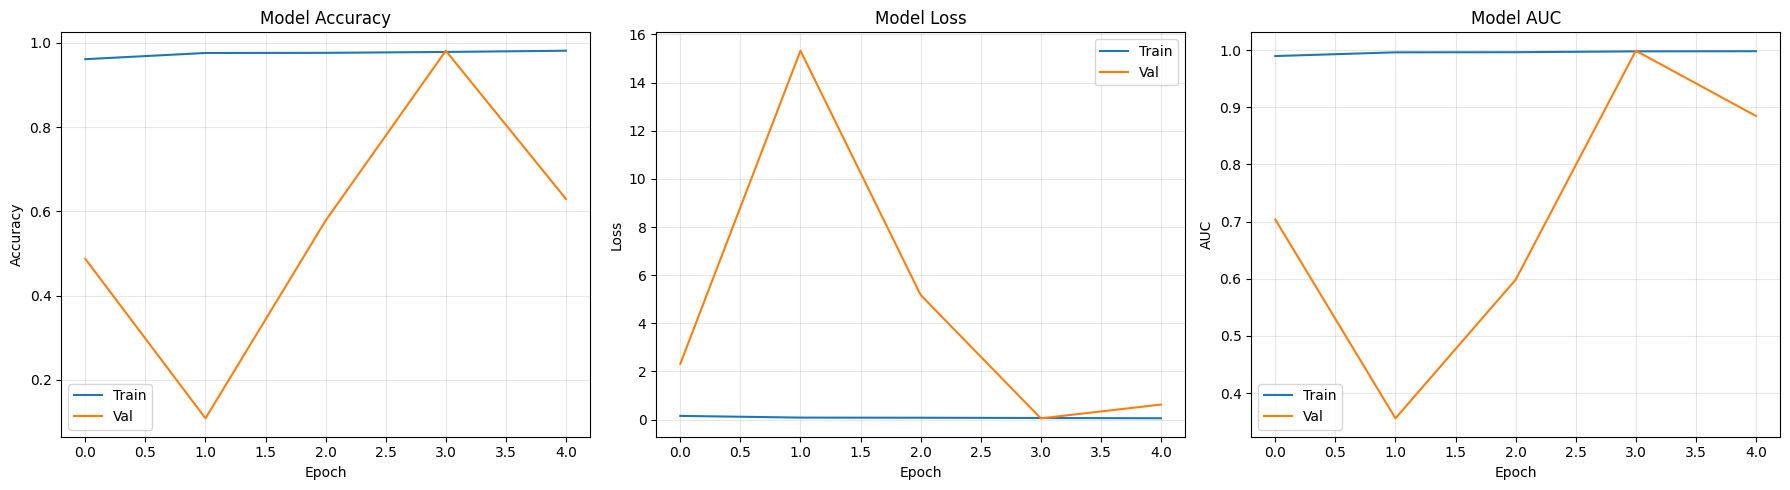

In [33]:
# Plot Training History

print("\n Plotting training history...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Val')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Val')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# AUC
axes[2].plot(history.history['auc'], label='Train')
axes[2].plot(history.history['val_auc'], label='Val')
axes[2].set_title('Model AUC')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'training_history.png', dpi=150, bbox_inches='tight')
print(f" Saved plot: {MODEL_DIR / 'training_history.png'}")
plt.show()

In [34]:
# Evaluate on Test Set
print("\n Evaluating on test set...")

# Load best model
model = keras.models.load_model(MODEL_DIR / 'best_model.keras')

# Evaluate
test_loss, test_acc, test_auc = model.evaluate(test_gen, verbose=1)

print(f"\n TEST SET RESULTS:")
print(f"   Loss:     {test_loss:.4f}")
print(f"   Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   AUC:      {test_auc:.4f}")

# Get predictions
print("\n Generating predictions...")
y_true = []
y_pred = []

for i in tqdm(range(len(test_gen)), desc="Predicting"):
    X_batch, y_batch = test_gen[i]
    predictions = model.predict(X_batch, verbose=0)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


 Evaluating on test set...
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.9817 - auc: 0.9985 - loss: 0.0572

 TEST SET RESULTS:
   Loss:     0.0550
   Accuracy: 0.9831 (98.31%)
   AUC:      0.9984

 Generating predictions...


Predicting: 100%|██████████| 126/126 [00:22<00:00,  5.48it/s]



 Classification Report:
              precision    recall  f1-score   support

      normal     0.9950    1.0000    0.9975      1594
   queenless     0.9713    0.9995    0.9852      1996
    swarming     0.9973    0.8463    0.9156       436

    accuracy                         0.9831      4026
   macro avg     0.9879    0.9486    0.9661      4026
weighted avg     0.9835    0.9831    0.9825      4026


 Saved confusion matrix: /content/drive/MyDrive/AsaliAsPossible/models/confusion_matrix.png


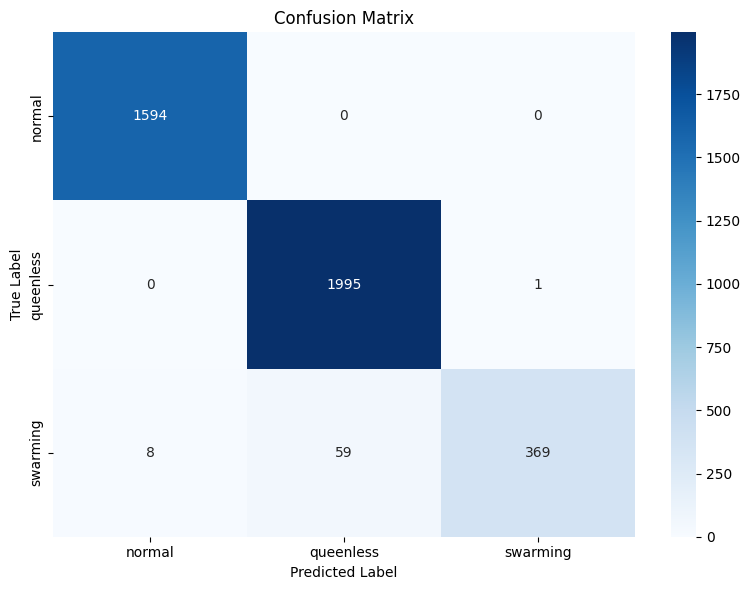

In [35]:
# Classification Report & Confusion Matrix
print("\n Classification Report:")
print("="*70)
report = classification_report(
    y_true, y_pred,
    target_names=['normal', 'queenless', 'swarming'],
    digits=4
)
print(report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['normal', 'queenless', 'swarming'],
    yticklabels=['normal', 'queenless', 'swarming']
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(MODEL_DIR / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
print(f"\n Saved confusion matrix: {MODEL_DIR / 'confusion_matrix.png'}")
plt.show()

In [36]:
# Save Model & Metadata
print("\n Saving final model and metadata...")

# Save model in multiple formats
model.save(MODEL_DIR / 'beehive_sound_cnn.keras')
model.save(MODEL_DIR / 'beehive_sound_cnn.h5')

# Save label mapping
label_mapping = {
    'label_to_idx': label_map,
    'idx_to_label': label_map_inv
}
with open(MODEL_DIR / 'label_mapping.json', 'w') as f:
    json.dump(label_mapping, f, indent=2)

# Save training metadata
metadata = {
    'model_architecture': 'CNN',
    'input_shape': [128, 128, 1],
    'num_classes': 3,
    'classes': ['normal', 'queenless', 'swarming'],
    'total_params': int(total_params),
    'training': {
        'epochs_trained': len(history.history['loss']),
        'batch_size': BATCH_SIZE,
        'optimizer': 'Adam',
        'initial_lr': 0.001
    },
    'performance': {
        'test_accuracy': float(test_acc),
        'test_loss': float(test_loss),
        'test_auc': float(test_auc)
    },
    'data': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df)
    }
}

with open(MODEL_DIR / 'model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f" Saved model files:")
print(f"   - {MODEL_DIR / 'beehive_sound_cnn.keras'}")
print(f"   - {MODEL_DIR / 'beehive_sound_cnn.h5'}")
print(f"   - {MODEL_DIR / 'label_mapping.json'}")
print(f"   - {MODEL_DIR / 'model_metadata.json'}")


 Saving final model and metadata...


 Saved model files:
   - /content/drive/MyDrive/AsaliAsPossible/models/beehive_sound_cnn.keras
   - /content/drive/MyDrive/AsaliAsPossible/models/beehive_sound_cnn.h5
   - /content/drive/MyDrive/AsaliAsPossible/models/label_mapping.json
   - /content/drive/MyDrive/AsaliAsPossible/models/model_metadata.json


In [37]:
# Create Inference Function
print("\n Creating inference helper function...")

inference_code = '''"""
Inference function for BeehiveEnv integration
"""
import numpy as np
from tensorflow import keras
from pathlib import Path

class BeehiveSoundClassifier:
    def __init__(self, model_path, label_mapping_path):
        """Load trained CNN model"""
        self.model = keras.models.load_model(model_path)

        with open(label_mapping_path, 'r') as f:
            import json
            mapping = json.load(f)
            self.idx_to_label = {int(k): v for k, v in mapping['idx_to_label'].items()}

    def predict(self, spectrogram):
        """
        Predict hive state from spectrogram

        Args:
            spectrogram: np.array of shape (128, 128) or (128, 128, 1)

        Returns:
            dict with 'label' and 'probabilities'
        """
        # Ensure correct shape
        if spectrogram.shape == (128, 128):
            spectrogram = np.expand_dims(spectrogram, axis=-1)
        spectrogram = np.expand_dims(spectrogram, axis=0)  # Add batch dim

        # Predict
        probs = self.model.predict(spectrogram, verbose=0)[0]
        pred_idx = np.argmax(probs)

        return {
            'label': self.idx_to_label[pred_idx],
            'probabilities': {
                'normal': float(probs[0]),
                'queenless': float(probs[1]),
                'swarming': float(probs[2])
            }
        }

# Example usage:
# classifier = BeehiveSoundClassifier(
#     'models/beehive_sound_cnn.keras',
#     'models/label_mapping.json'
# )
# result = classifier.predict(spectrogram)
# print(f"Predicted: {result['label']}")
'''

with open(MODEL_DIR / 'inference.py', 'w') as f:
    f.write(inference_code)

print(f" Saved: {MODEL_DIR / 'inference.py'}")


 Creating inference helper function...
 Saved: /content/drive/MyDrive/AsaliAsPossible/models/inference.py


In [38]:
#  Final Report
print(f"\n{'='*70}")
print(" CNN TRAINING COMPLETE!")
print('='*70)

print(f"\n FINAL RESULTS:")
print(f"    Test Accuracy:  {test_acc*100:.2f}%")
print(f"    Test Loss:      {test_loss:.4f}")
print(f"    Test AUC:       {test_auc:.4f}")

print(f"\n  PER-CLASS PERFORMANCE:")
report_dict = classification_report(
    y_true, y_pred,
    target_names=['normal', 'queenless', 'swarming'],
    output_dict=True
)
for label in ['normal', 'queenless', 'swarming']:
    metrics = report_dict[label]
    print(f"   {label.upper()}:")
    print(f"      Precision: {metrics['precision']:.4f}")
    print(f"      Recall:    {metrics['recall']:.4f}")
    print(f"      F1-Score:  {metrics['f1-score']:.4f}")

print(f"\n SAVED FILES:")
print(f"    {MODEL_DIR / 'beehive_sound_cnn.keras'}")
print(f"    {MODEL_DIR / 'training_history.png'}")
print(f"    {MODEL_DIR / 'confusion_matrix.png'}")
print(f"     {MODEL_DIR / 'label_mapping.json'}")
print(f"    {MODEL_DIR / 'model_metadata.json'}")
print(f"    {MODEL_DIR / 'inference.py'}")

print(f"\n NEXT STEPS:")
print(f"   1️  Review confusion matrix")
print(f"   2️  Test inference function")
print(f"   3️  Integrate with BeehiveEnv")
print(f"   4️  Prepare sensor data (time-series)")

print(f"\n READY FOR: Notebook 04 - Sensor Data Processing")
print(f"   - Process temperature/humidity CSVs")
print(f"   - Extract time-series patterns")
print(f"   - Prepare for RL training")


 CNN TRAINING COMPLETE!

 FINAL RESULTS:
    Test Accuracy:  98.31%
    Test Loss:      0.0550
    Test AUC:       0.9984

  PER-CLASS PERFORMANCE:
   NORMAL:
      Precision: 0.9950
      Recall:    1.0000
      F1-Score:  0.9975
   QUEENLESS:
      Precision: 0.9713
      Recall:    0.9995
      F1-Score:  0.9852
   SWARMING:
      Precision: 0.9973
      Recall:    0.8463
      F1-Score:  0.9156

 SAVED FILES:
    /content/drive/MyDrive/AsaliAsPossible/models/beehive_sound_cnn.keras
    /content/drive/MyDrive/AsaliAsPossible/models/training_history.png
    /content/drive/MyDrive/AsaliAsPossible/models/confusion_matrix.png
     /content/drive/MyDrive/AsaliAsPossible/models/label_mapping.json
    /content/drive/MyDrive/AsaliAsPossible/models/model_metadata.json
    /content/drive/MyDrive/AsaliAsPossible/models/inference.py

 NEXT STEPS:
   1️  Review confusion matrix
   2️  Test inference function
   3️  Integrate with BeehiveEnv
   4️  Prepare sensor data (time-series)

 READY FOR: 

In [39]:
#Sensor Data Processing & Time-Series Analysis

#Processes temperature, humidity, weight data for RL training

# Paths
BASE_PATH = Path('/content/drive/MyDrive/AsaliAsPossible')
WORK_DIR = Path('/content/asali_work')
PROCESSED_DIR = BASE_PATH / 'processed'
PROCESSED_DIR.mkdir(exist_ok=True)
print(" Setup complete!")
print(f" Working directory: {WORK_DIR}")
print(f" Output directory: {PROCESSED_DIR}")

 Setup complete!
 Working directory: /content/asali_work
 Output directory: /content/drive/MyDrive/AsaliAsPossible/processed


In [40]:
#  Load Sensor CSVs
print("\n Loading sensor data...")

# Find CSV files
csv_files = list(WORK_DIR.glob('**/*.csv'))
print(f" Found {len(csv_files)} CSV files")

# Categorize files
temp_files = [f for f in csv_files if 'temp' in f.name.lower()]
humidity_files = [f for f in csv_files if 'hum' in f.name.lower() or 'moisture' in f.name.lower()]
weight_files = [f for f in csv_files if 'weight' in f.name.lower() or 'scale' in f.name.lower()]
flow_files = [f for f in csv_files if 'flow' in f.name.lower()]
other_files = [f for f in csv_files if f not in temp_files + humidity_files + weight_files + flow_files]

print(f"\n File Categories:")
print(f"     Temperature: {len(temp_files)} files")
print(f"    Humidity:    {len(humidity_files)} files")
print(f"    Weight:      {len(weight_files)} files")
print(f"    Flow:        {len(flow_files)} files")
print(f"    Other:       {len(other_files)} files")




 Loading sensor data...
 Found 4 CSV files

 File Categories:
     Temperature: 1 files
    Humidity:    0 files
    Weight:      1 files
    Flow:        1 files
    Other:       1 files


In [41]:
#  Load & Inspect Temperature Data

print(f"\n{'='*70}")
print("  TEMPERATURE DATA")
print('='*70)

temp_dfs = []
for temp_file in temp_files:
    print(f"\n Loading {temp_file.name}...")
    try:
        df = pd.read_csv(temp_file)
        print(f"   Shape: {df.shape}")
        print(f"   Columns: {list(df.columns)[:5]}...")

        # Add source file
        df['source_file'] = temp_file.name
        temp_dfs.append(df)

    except Exception as e:
        print(f"    Error: {e}")

# Combine all temperature data
if temp_dfs:
    df_temp = pd.concat(temp_dfs, ignore_index=True)
    print(f"\n Combined temperature data: {df_temp.shape}")
    print(f"   Total readings: {len(df_temp):,}")
else:
    print(" No temperature data found")
    df_temp = pd.DataFrame()


  TEMPERATURE DATA

 Loading temperature_2017.csv...
   Shape: (401869, 2)
   Columns: ['timestamp', 'temperature']...

 Combined temperature data: (401869, 3)
   Total readings: 401,869


In [42]:
#  Load & Inspect Humidity Data

print("\n LOADING HUMIDITY DATA...")

# Try to find humidity file
humidity_file = BASE_PATH / 'humidity_2017.csv'

if humidity_file.exists():
    print(f" Found: {humidity_file}")
    df_humidity = pd.read_csv(humidity_file)
    print(f"   Shape: {df_humidity.shape}")
    print(f"   Columns: {list(df_humidity.columns)}")
    print(f"\n   Sample data:")
    print(df_humidity.head())
else:
    # Try in work directory
    humidity_file = WORK_DIR / 'humidity_2017.csv'
    if humidity_file.exists():
        print(f" Found in work dir: {humidity_file}")
        df_humidity = pd.read_csv(humidity_file)
        print(f"   Shape: {df_humidity.shape}")
        print(f"   Columns: {list(df_humidity.columns)}")
    else:
        print(" Humidity file not found in expected locations")
        print("\n Searching all CSV files...")
        all_csvs = list(BASE_PATH.glob('*.csv')) + list(WORK_DIR.glob('**/*.csv'))
        print(f"   Found {len(all_csvs)} CSV files:")
        for f in all_csvs[:10]:
            print(f"   - {f.name}")
        df_humidity = None




 LOADING HUMIDITY DATA...
 Found: /content/drive/MyDrive/AsaliAsPossible/humidity_2017.csv
   Shape: (8737, 2)
   Columns: ['timestamp', 'humidity']

   Sample data:
             timestamp   humidity
0  2017-01-01 05:00:00  92.406667
1  2017-01-01 06:00:00  92.270000
2  2017-01-01 07:00:00  92.575000
3  2017-01-01 08:00:00  92.840000
4  2017-01-01 09:00:00  93.640000


In [43]:
# Load & Inspect Weight Data

print(f"\n{'='*70}")
print("  WEIGHT DATA")
print('='*70)

weight_dfs = []
for weight_file in weight_files:
    print(f"\n Loading {weight_file.name}...")
    try:
        df = pd.read_csv(weight_file)
        print(f"   Shape: {df.shape}")
        print(f"   Columns: {list(df.columns)[:5]}...")

        df['source_file'] = weight_file.name
        weight_dfs.append(df)

    except Exception as e:
        print(f"    Error: {e}")

# Combine weight data
if weight_dfs:
    df_weight = pd.concat(weight_dfs, ignore_index=True)
    print(f"\n Combined weight data: {df_weight.shape}")
else:
    print(" No weight data found")
    df_weight = pd.DataFrame()


  WEIGHT DATA

 Loading weight_2017.csv...
   Shape: (524110, 2)
   Columns: ['timestamp', 'weight']...

 Combined weight data: (524110, 3)


In [44]:

# Standardize Column Names & Parse Timestamps (FIXED)

print(f"\n{'='*70}")
print(" STANDARDIZING DATA")
print('='*70)

def standardize_dataframe(df, data_type):
    """Standardize column names and parse timestamps"""
    df = df.copy()

    # Ensure source_file column exists
    if 'source_file' not in df.columns:
        df['source_file'] = 'unknown'

    # Find timestamp column (various names possible)
    time_cols = [c for c in df.columns if any(kw in c.lower() for kw in
                 ['time', 'date', 'datetime', 'timestamp', 'ts'])]

    if time_cols:
        time_col = time_cols[0]
        print(f"   Found timestamp column: {time_col}")

        # Try to parse timestamps
        try:
            df['timestamp'] = pd.to_datetime(df[time_col])
            df = df.sort_values('timestamp').reset_index(drop=True)
        except:
            print(f"     Could not parse timestamps, using index")
            df['timestamp'] = pd.date_range(start='2017-01-01', periods=len(df), freq='5min')
    else:
        print(f"     No timestamp column found, creating synthetic timestamps")
        df['timestamp'] = pd.date_range(start='2017-01-01', periods=len(df), freq='5min')

    # Find value column
    if data_type == 'temperature':
        value_cols = [c for c in df.columns if 'temp' in c.lower() and c not in ['timestamp']]
    elif data_type == 'humidity':
        value_cols = [c for c in df.columns if any(kw in c.lower() for kw in ['hum', 'moisture']) and c not in ['timestamp']]
    elif data_type == 'weight':
        value_cols = [c for c in df.columns if any(kw in c.lower() for kw in ['weight', 'scale', 'mass']) and c not in ['timestamp']]
    else:
        value_cols = []

    if value_cols:
        df['value'] = pd.to_numeric(df[value_cols[0]], errors='coerce')
        print(f"   Found value column: {value_cols[0]}")
    else:
        # Use first numeric column
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        numeric_cols = [c for c in numeric_cols if c not in ['timestamp']]
        if len(numeric_cols) > 0:
            df['value'] = df[numeric_cols[0]]
            print(f"   Using first numeric column: {numeric_cols[0]}")
        else:
            print(f"    No numeric columns found!")
            return pd.DataFrame(columns=['timestamp', 'value', 'source_file'])

    # Return only required columns
    return df[['timestamp', 'value', 'source_file']].copy()

# Standardize each dataframe
if not df_temp.empty:
    print("\n  Standardizing temperature...")
    df_temp = standardize_dataframe(df_temp, 'temperature')
    df_temp['sensor_type'] = 'temperature'

if not df_humidity.empty:
    print("\n Standardizing humidity...")
    df_humidity = standardize_dataframe(df_humidity, 'humidity')
    df_humidity['sensor_type'] = 'humidity'

if not df_weight.empty:
    print("\n  Standardizing weight...")
    df_weight = standardize_dataframe(df_weight, 'weight')
    df_weight['sensor_type'] = 'weight'

print("\n Standardization complete!")



 STANDARDIZING DATA

  Standardizing temperature...
   Found timestamp column: timestamp
   Found value column: temperature

 Standardizing humidity...
   Found timestamp column: timestamp
   Found value column: humidity

  Standardizing weight...
   Found timestamp column: timestamp
   Found value column: weight

 Standardization complete!


In [45]:
#  Reload and Clean ALL Sensor Data

print(f"\n{'='*70}")
print(" RELOADING ALL SENSOR DATA WITH VALIDATION")
print('='*70)

def load_and_clean_sensor(file_path, sensor_type, value_column=None):
    """Load sensor data with validation and cleaning"""
    print(f"\n Loading {sensor_type}: {file_path.name}")

    try:
        df = pd.read_csv(file_path)
        print(f"   Original shape: {df.shape}")
        print(f"   Columns: {list(df.columns)}")

        # Find timestamp column
        time_cols = [c for c in df.columns if any(kw in c.lower() for kw in
                     ['time', 'date', 'datetime', 'timestamp'])]

        if time_cols:
            time_col = time_cols[0]
            try:
                df['timestamp'] = pd.to_datetime(df[time_col])
            except:
                print(f"    Creating synthetic timestamps")
                df['timestamp'] = pd.date_range(start='2017-01-01', periods=len(df), freq='5min')
        else:
            df['timestamp'] = pd.date_range(start='2017-01-01', periods=len(df), freq='5min')

        # Find value column
        if value_column:
            val_cols = [c for c in df.columns if value_column.lower() in c.lower()]
        else:
            # Auto-detect based on sensor type
            if sensor_type == 'temperature':
                val_cols = [c for c in df.columns if 'temp' in c.lower() and 'time' not in c.lower()]
            elif sensor_type == 'humidity':
                val_cols = [c for c in df.columns if any(kw in c.lower() for kw in ['hum', 'rh', 'moisture'])]
            elif sensor_type == 'weight':
                val_cols = [c for c in df.columns if any(kw in c.lower() for kw in ['weight', 'scale', 'mass'])]
            else:
                val_cols = []

        if not val_cols:
            # Use first numeric column
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            val_cols = [c for c in numeric_cols if c not in ['timestamp']]

        if val_cols:
            print(f"   Value column: {val_cols[0]}")
            df['value'] = pd.to_numeric(df[val_cols[0]], errors='coerce')

            # Initial stats
            print(f"   Raw range: [{df['value'].min():.2f}, {df['value'].max():.2f}]")
            print(f"   Raw mean: {df['value'].mean():.2f}")

            # Clean outliers based on sensor type
            if sensor_type == 'temperature':
                # Beehive temperature should be 10-50°C
                df = df[(df['value'] >= -10) & (df['value'] <= 60)]
                # Remove extreme outliers (>3 std from mean)
                mean, std = df['value'].mean(), df['value'].std()
                df = df[np.abs(df['value'] - mean) <= 3*std]

            elif sensor_type == 'humidity':
                # Humidity: 0-100%
                df = df[(df['value'] >= 0) & (df['value'] <= 100)]

            elif sensor_type == 'weight':
                # Weight should be positive and reasonable (0-100 kg)
                df = df[(df['value'] >= 0) & (df['value'] <= 100)]

            # Remove NaN values
            df = df.dropna(subset=['value'])

            print(f"   After cleaning: {len(df):,} readings")
            print(f"   Clean range: [{df['value'].min():.2f}, {df['value'].max():.2f}]")
            print(f"   Clean mean: {df['value'].mean():.2f} ± {df['value'].std():.2f}")

            # Select and return
            df_clean = df[['timestamp', 'value']].copy()
            df_clean['sensor_type'] = sensor_type
            return df_clean

        else:
            print(f"    No value column found")
            return None

    except Exception as e:
        print(f"    Error: {e}")
        return None

# Load each sensor type
sensor_files = {
    'temperature': BASE_PATH / 'temperature_2017.csv',
    'humidity': BASE_PATH / 'humidity_2017.csv',
    'weight': BASE_PATH / 'weight_2017.csv'
}

# Check work directory too
for sensor in sensor_files.keys():
    if not sensor_files[sensor].exists():
        work_file = WORK_DIR / f'{sensor}_2017.csv'
        if work_file.exists():
            sensor_files[sensor] = work_file

# Load all sensors
sensor_dfs = {}
for sensor_type, file_path in sensor_files.items():
    if file_path.exists():
        df = load_and_clean_sensor(file_path, sensor_type)
        if df is not None:
            sensor_dfs[sensor_type] = df
    else:
        print(f"\n {sensor_type} file not found: {file_path}")



 RELOADING ALL SENSOR DATA WITH VALIDATION

 Loading temperature: temperature_2017.csv
   Original shape: (401869, 2)
   Columns: ['timestamp', 'temperature']
   Value column: temperature
   Raw range: [-227.14, 57.36]
   Raw mean: 18.48
   After cleaning: 401,646 readings
   Clean range: [-10.00, 52.07]
   Clean mean: 18.46 ± 11.17

 Loading humidity: humidity_2017.csv
   Original shape: (8737, 2)
   Columns: ['timestamp', 'humidity']
   Value column: humidity
   Raw range: [-66.71, 99.65]
   Raw mean: 74.90
   After cleaning: 8,735 readings
   Clean range: [33.55, 99.65]
   Clean mean: 74.93 ± 15.47

 Loading weight: weight_2017.csv
   Original shape: (524110, 2)
   Columns: ['timestamp', 'weight']
   Value column: weight
   Raw range: [-0.12, 68.70]
   Raw mean: 55.95
   After cleaning: 523,603 readings
   Clean range: [0.01, 68.70]
   Clean mean: 56.00 ± 5.89


In [46]:

# Combine and Validate

print(f"\n{'='*70}")
print(" COMBINING CLEANED DATA")
print('='*70)

if sensor_dfs:
    df_sensors_clean = pd.concat(list(sensor_dfs.values()), ignore_index=True)

    print(f"\n Combined cleaned data: {df_sensors_clean.shape}")
    print(f"\n Sensor breakdown:")
    for sensor_type in df_sensors_clean['sensor_type'].unique():
        count = len(df_sensors_clean[df_sensors_clean['sensor_type'] == sensor_type])
        print(f"   {sensor_type}: {count:,} readings")

    # Calculate clean statistics
    statistics_clean = {}

    print(f"\n VALIDATED STATISTICS:")
    for sensor_type in df_sensors_clean['sensor_type'].unique():
        sensor_data = df_sensors_clean[df_sensors_clean['sensor_type'] == sensor_type]['value']

        stats = {
            'count': int(len(sensor_data)),
            'mean': float(sensor_data.mean()),
            'std': float(sensor_data.std()),
            'min': float(sensor_data.min()),
            'max': float(sensor_data.max()),
            'median': float(sensor_data.median()),
            'q25': float(sensor_data.quantile(0.25)),
            'q75': float(sensor_data.quantile(0.75))
        }

        statistics_clean[sensor_type] = stats

        print(f"\n{sensor_type.upper()}:")
        print(f"   Count:  {stats['count']:,}")
        print(f"   Mean:   {stats['mean']:.2f} ± {stats['std']:.2f}")
        print(f"   Range:  [{stats['min']:.2f}, {stats['max']:.2f}]")
        print(f"   Median: {stats['median']:.2f}")

        # Validate ranges
        if sensor_type == 'temperature':
            if 10 <= stats['mean'] <= 40:
                print(f"    Temperature range is realistic for beehives")
            else:
                print(f"     Temperature mean unusual: {stats['mean']:.2f}°C")

        elif sensor_type == 'humidity':
            if 30 <= stats['mean'] <= 90:
                print(f"    Humidity range is realistic")
            else:
                print(f"     Humidity mean unusual: {stats['mean']:.2f}%")

        elif sensor_type == 'weight':
            if stats['min'] >= 0 and stats['max'] <= 100:
                print(f"    Weight range is realistic")

    # Save cleaned statistics
    stats_path = PROCESSED_DIR / 'sensor_statistics_clean.json'
    with open(stats_path, 'w') as f:
        json.dump(statistics_clean, f, indent=2)
    print(f"\n Saved clean statistics: {stats_path}")


 COMBINING CLEANED DATA

 Combined cleaned data: (933984, 3)

 Sensor breakdown:
   temperature: 401,646 readings
   humidity: 8,735 readings
   weight: 523,603 readings

 VALIDATED STATISTICS:

TEMPERATURE:
   Count:  401,646
   Mean:   18.46 ± 11.17
   Range:  [-10.00, 52.07]
   Median: 17.17
    Temperature range is realistic for beehives

HUMIDITY:
   Count:  8,735
   Mean:   74.93 ± 15.47
   Range:  [33.55, 99.65]
   Median: 79.76
    Humidity range is realistic

WEIGHT:
   Count:  523,603
   Mean:   56.00 ± 5.89
   Range:  [0.01, 68.70]
   Median: 55.00
    Weight range is realistic

 Saved clean statistics: /content/drive/MyDrive/AsaliAsPossible/processed/sensor_statistics_clean.json


In [51]:
# Calculate Statistics & Patterns

print(f"\n{'='*70}")
print(" CALCULATING STATISTICS")
print('='*70)

statistics = {}

for sensor_type in df_sensors_clean['sensor_type'].unique():
    sensor_data = df_sensors_clean[df_sensors_clean['sensor_type'] == sensor_type]['value']

    stats = {
        'count': int(len(sensor_data)),
        'mean': float(sensor_data.mean()),
        'std': float(sensor_data.std()),
        'min': float(sensor_data.min()),
        'max': float(sensor_data.max()),
        'median': float(sensor_data.median()),
        'q25': float(sensor_data.quantile(0.25)),
        'q75': float(sensor_data.quantile(0.75))
    }

    statistics[sensor_type] = stats

    print(f"\n{sensor_type.upper()}:")
    print(f"   Count:  {stats['count']:,}")
    print(f"   Mean:   {stats['mean']:.2f}")
    print(f"   Std:    {stats['std']:.2f}")
    print(f"   Range:  [{stats['min']:.2f}, {stats['max']:.2f}]")
    print(f"   Median: {stats['median']:.2f}")

# Save statistics
stats_path = PROCESSED_DIR / 'sensor_statistics.json'
with open(stats_path, 'w') as f:
    json.dump(statistics, f, indent=2)
print(f"\n Saved statistics: {stats_path}")



 CALCULATING STATISTICS

TEMPERATURE:
   Count:  401,646
   Mean:   18.46
   Std:    11.17
   Range:  [-10.00, 52.07]
   Median: 17.17

HUMIDITY:
   Count:  8,735
   Mean:   74.93
   Std:    15.47
   Range:  [33.55, 99.65]
   Median: 79.76

WEIGHT:
   Count:  523,603
   Mean:   56.00
   Std:    5.89
   Range:  [0.01, 68.70]
   Median: 55.00

 Saved statistics: /content/drive/MyDrive/AsaliAsPossible/processed/sensor_statistics.json



 Creating time-series visualizations...
 Saved: /content/drive/MyDrive/AsaliAsPossible/processed/sensor_timeseries.png


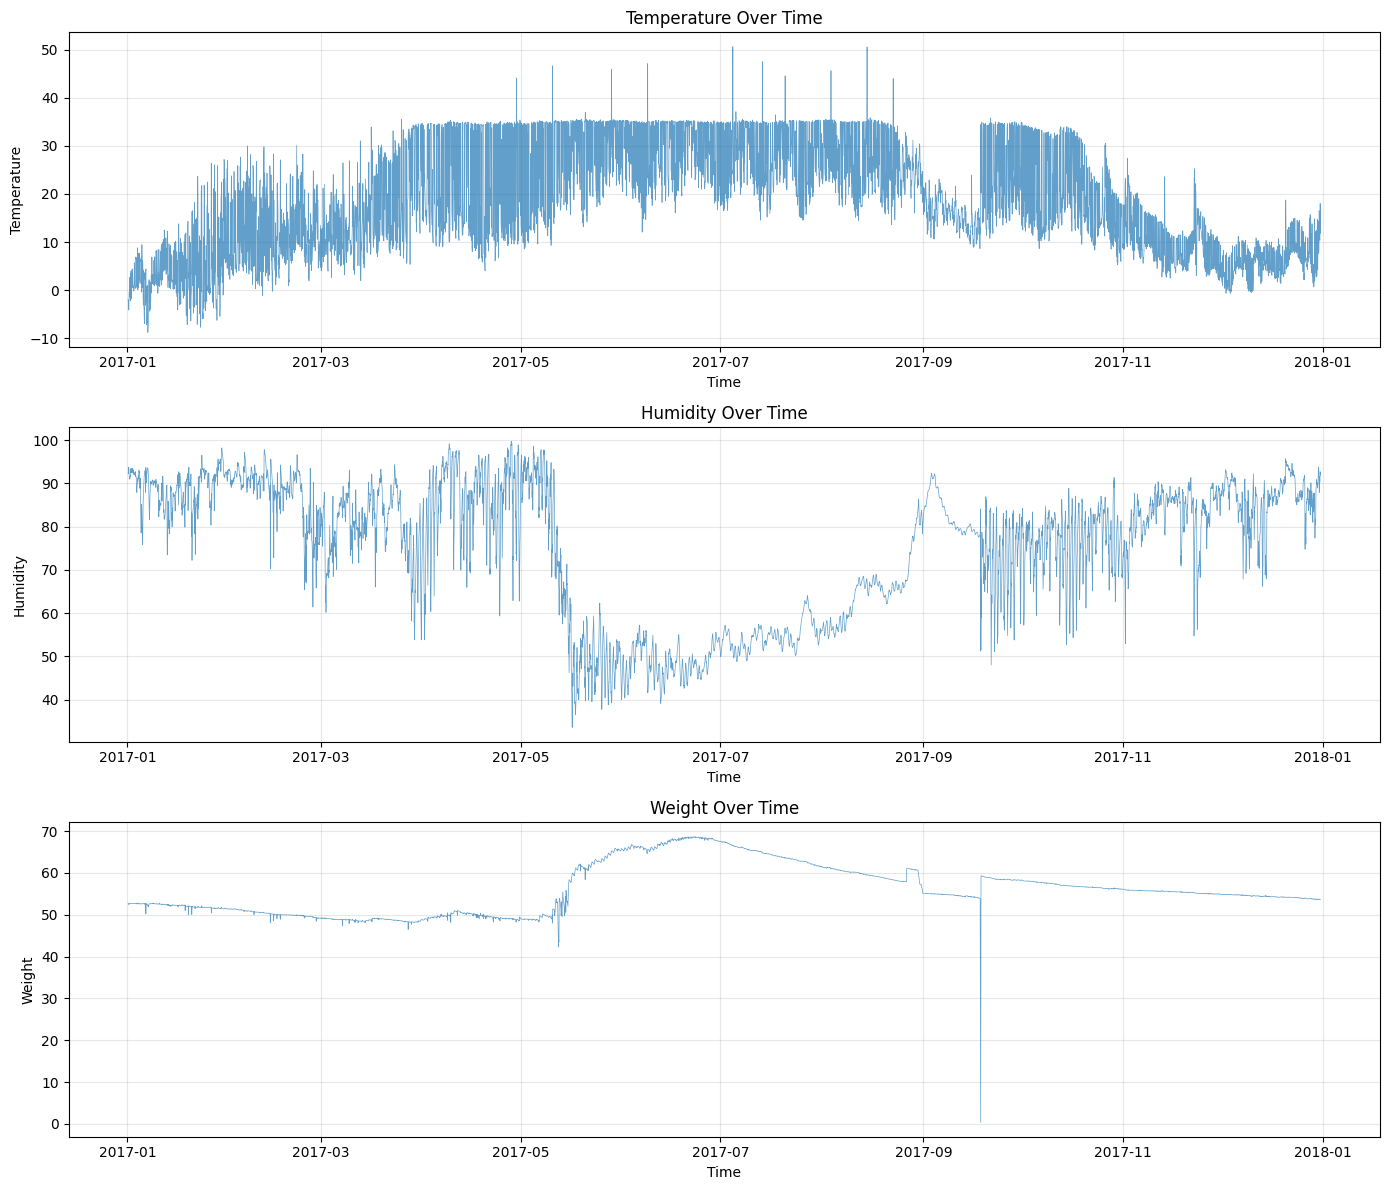

In [52]:
# Time-Series Visualization

print(f"\n Creating time-series visualizations...")

fig, axes = plt.subplots(len(statistics), 1, figsize=(14, 4*len(statistics)))
if len(statistics) == 1:
    axes = [axes]

for idx, sensor_type in enumerate(statistics.keys()):
    sensor_df = df_sensors_clean[df_sensors_clean['sensor_type'] == sensor_type].copy()
    sensor_df = sensor_df.sort_values('timestamp')

    # Sample for visualization (plot every Nth point if too many)
    max_points = 5000
    if len(sensor_df) > max_points:
        step = len(sensor_df) // max_points
        sensor_df = sensor_df.iloc[::step]

    axes[idx].plot(sensor_df['timestamp'], sensor_df['value'], alpha=0.7, linewidth=0.5)
    axes[idx].set_title(f'{sensor_type.title()} Over Time')
    axes[idx].set_xlabel('Time')
    axes[idx].set_ylabel(sensor_type.title())
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'sensor_timeseries.png', dpi=150, bbox_inches='tight')
print(f" Saved: {PROCESSED_DIR / 'sensor_timeseries.png'}")
plt.show()


 EXTRACTING DAILY PATTERNS

TEMPERATURE:
   Daily variation (std): 6.39
   Typical daily range:   23.04

HUMIDITY:
   Daily variation (std): 3.33
   Typical daily range:   10.79

WEIGHT:
   Daily variation (std): 0.20
   Typical daily range:   1.30

 Saved: /content/drive/MyDrive/AsaliAsPossible/processed/hourly_patterns.png


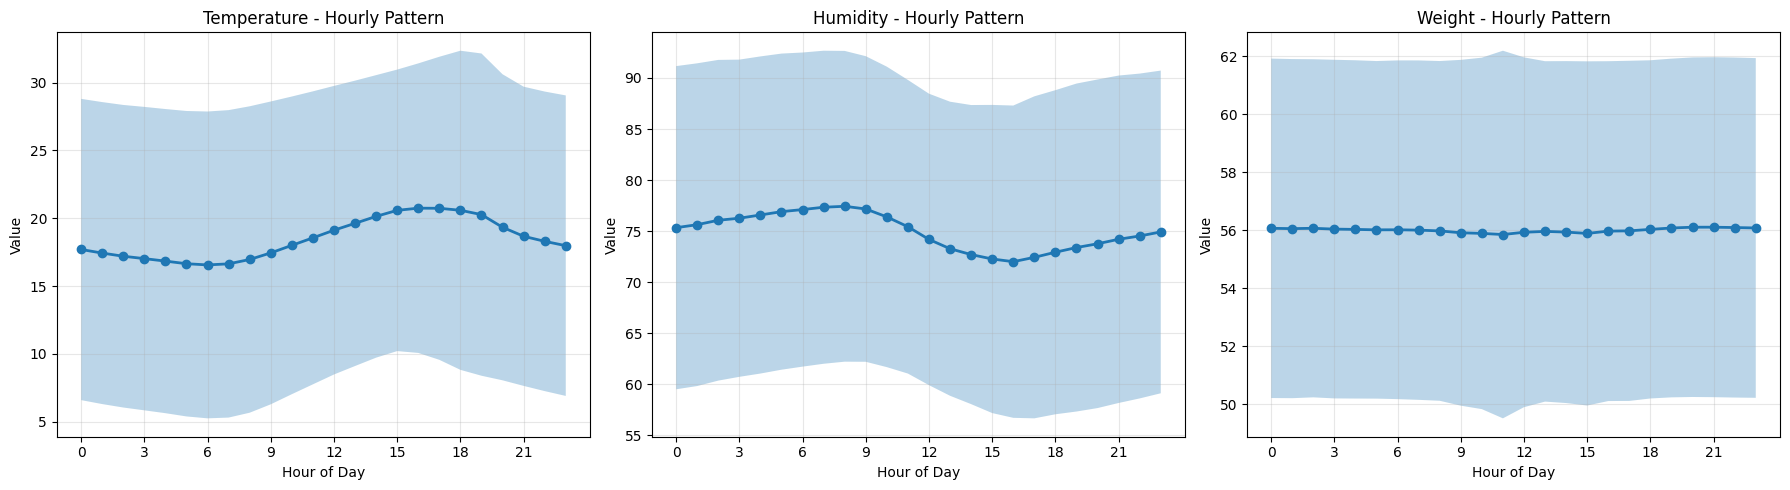

 Saved patterns: /content/drive/MyDrive/AsaliAsPossible/processed/daily_patterns.json


In [53]:
# Extract Daily Patterns

print(f"\n{'='*70}")
print(" EXTRACTING DAILY PATTERNS")
print('='*70)

daily_patterns = {}

for sensor_type in statistics.keys():
    sensor_df = df_sensors_clean[df_sensors_clean['sensor_type'] == sensor_type].copy()
    sensor_df['hour'] = sensor_df['timestamp'].dt.hour
    sensor_df['day_of_year'] = sensor_df['timestamp'].dt.dayofyear

    # Hourly pattern (average by hour)
    hourly = sensor_df.groupby('hour')['value'].agg(['mean', 'std']).reset_index()

    # Daily aggregates
    daily = sensor_df.groupby('day_of_year')['value'].agg(['mean', 'min', 'max', 'std']).reset_index()

    daily_patterns[sensor_type] = {
        'hourly_mean': hourly['mean'].tolist(),
        'hourly_std': hourly['std'].tolist(),
        'daily_variation': float(daily['std'].mean()),
        'typical_daily_range': float(daily['max'].mean() - daily['min'].mean())
    }

    print(f"\n{sensor_type.upper()}:")
    print(f"   Daily variation (std): {daily_patterns[sensor_type]['daily_variation']:.2f}")
    print(f"   Typical daily range:   {daily_patterns[sensor_type]['typical_daily_range']:.2f}")

# Plot hourly patterns
fig, axes = plt.subplots(1, len(statistics), figsize=(6*len(statistics), 5))
if len(statistics) == 1:
    axes = [axes]

for idx, sensor_type in enumerate(statistics.keys()):
    pattern = daily_patterns[sensor_type]
    hours = range(24)

    axes[idx].plot(hours, pattern['hourly_mean'], marker='o', linewidth=2)
    axes[idx].fill_between(
        hours,
        np.array(pattern['hourly_mean']) - np.array(pattern['hourly_std']),
        np.array(pattern['hourly_mean']) + np.array(pattern['hourly_std']),
        alpha=0.3
    )
    axes[idx].set_title(f'{sensor_type.title()} - Hourly Pattern')
    axes[idx].set_xlabel('Hour of Day')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xticks(range(0, 24, 3))

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'hourly_patterns.png', dpi=150, bbox_inches='tight')
print(f"\n Saved: {PROCESSED_DIR / 'hourly_patterns.png'}")
plt.show()

# Save patterns
patterns_path = PROCESSED_DIR / 'daily_patterns.json'
with open(patterns_path, 'w') as f:
    json.dump(daily_patterns, f, indent=2)
print(f" Saved patterns: {patterns_path}")

In [54]:
# Create Resampled Time-Series (for RL)

print(f"\n{'='*70}")
print("  RESAMPLING CLEAN DATA")
print('='*70)

resampled_clean = {}

for sensor_type in df_sensors_clean['sensor_type'].unique():
    sensor_df = df_sensors_clean[df_sensors_clean['sensor_type'] == sensor_type].copy()
    sensor_df = sensor_df.set_index('timestamp').sort_index()

    # Resample to hourly
    hourly = sensor_df['value'].resample('1H').mean().interpolate(method='linear')
    resampled_clean[sensor_type] = hourly

# Combine into single dataframe
df_hourly_clean = pd.DataFrame(resampled_clean).reset_index()

print(f" Resampled clean data: {df_hourly_clean.shape}")
print(f"   Columns: {list(df_hourly_clean.columns)}")
print(f"   Time range: {df_hourly_clean['timestamp'].min()} to {df_hourly_clean['timestamp'].max()}")
print(f"   Duration: {(df_hourly_clean['timestamp'].max() - df_hourly_clean['timestamp'].min()).days} days")

# Save
hourly_path = PROCESSED_DIR / 'sensor_data_hourly_clean.csv'
df_hourly_clean.to_csv(hourly_path, index=False)
print(f" Saved: {hourly_path}")

# Display sample
print(f"\n Sample clean data:")
print(df_hourly_clean.head(10))


  RESAMPLING CLEAN DATA
 Resampled clean data: (8737, 4)
   Columns: ['timestamp', 'temperature', 'humidity', 'weight']
   Time range: 2017-01-01 05:00:00 to 2017-12-31 05:00:00
   Duration: 364 days
 Saved: /content/drive/MyDrive/AsaliAsPossible/processed/sensor_data_hourly_clean.csv

 Sample clean data:
            timestamp  temperature   humidity     weight
0 2017-01-01 05:00:00    -0.327590  92.406667  52.695098
1 2017-01-01 06:00:00    -0.409250  92.270000  52.685200
2 2017-01-01 07:00:00    -0.668364  92.575000  52.688667
3 2017-01-01 08:00:00    -0.966858  92.840000  52.674267
4 2017-01-01 09:00:00    -1.623189  93.640000  52.595320
5 2017-01-01 10:00:00    -1.435920  93.768333  52.420567
6 2017-01-01 11:00:00    -0.721903  92.950000  52.482175
7 2017-01-01 12:00:00    -0.178753  92.080000  52.556912
8 2017-01-01 13:00:00     0.385496  91.356667  52.645467
9 2017-01-01 14:00:00     0.602605  91.071667  52.708667


In [55]:
# Create RL Training Episodes

print(f"\n{'='*70}")
print(" REGENERATING EPISODES")
print('='*70)

EPISODE_LENGTH_DAYS = 30
HOURS_PER_EPISODE = EPISODE_LENGTH_DAYS * 24
NUM_EPISODES = 1000

episodes = []

if len(df_hourly_clean) >= HOURS_PER_EPISODE:
    # Use real data as template
    real_cycle = df_hourly_clean.head(HOURS_PER_EPISODE).copy()

    for ep_idx in range(NUM_EPISODES):
        episode = real_cycle.copy()

        # Add controlled variations
        for col in episode.columns:
            if col != 'timestamp':
                # Add ±5% Gaussian noise
                noise = np.random.normal(1.0, 0.05, len(episode))
                episode[col] = episode[col] * noise

                # Clip to validated ranges
                if col == 'temperature':
                    episode[col] = episode[col].clip(
                        statistics_clean['temperature']['min'],
                        statistics_clean['temperature']['max']
                    )
                elif col == 'humidity' and 'humidity' in statistics_clean:
                    episode[col] = episode[col].clip(
                        statistics_clean['humidity']['min'],
                        statistics_clean['humidity']['max']
                    )
                elif col == 'weight':
                    episode[col] = episode[col].clip(
                        statistics_clean['weight']['min'],
                        statistics_clean['weight']['max']
                    )

        episode['episode_id'] = ep_idx
        episode['timestep'] = range(len(episode))
        episodes.append(episode)

    df_episodes_clean = pd.concat(episodes, ignore_index=True)

    print(f" Generated {NUM_EPISODES} clean episodes")
    print(f"   Total timesteps: {len(df_episodes_clean):,}")

    # Save
    episodes_path = PROCESSED_DIR / 'rl_training_episodes_clean.csv'
    df_episodes_clean.to_csv(episodes_path, index=False)
    print(f" Saved: {episodes_path}")
else:
    print(f"  Not enough data for full episodes (need {HOURS_PER_EPISODE} hours)")






 REGENERATING EPISODES
 Generated 1000 clean episodes
   Total timesteps: 720,000
 Saved: /content/drive/MyDrive/AsaliAsPossible/processed/rl_training_episodes_clean.csv


In [56]:
# Final Report & Summary

print(f"\n{'='*70}")
print(" DATA CLEANING COMPLETE!")
print('='*70)

print(f"\n FINAL CLEAN DATA:")
print(f"   Raw readings: {len(df_sensors_clean):,}")
print(f"   Hourly samples: {len(df_hourly_clean):,}")
print(f"   Episodes: {NUM_EPISODES}")

print(f"\n  VALIDATED STATISTICS:")
for sensor_type, stats in statistics_clean.items():
    print(f"\n   {sensor_type.upper()}:")
    print(f"      Mean:   {stats['mean']:.2f} ± {stats['std']:.2f}")
    print(f"      Range:  [{stats['min']:.2f}, {stats['max']:.2f}]")
    print(f"      Median: {stats['median']:.2f}")

print(f"\n NEW OUTPUT FILES:")
print(f"    {PROCESSED_DIR / 'sensor_statistics_clean.json'}")
print(f"    {PROCESSED_DIR / 'sensor_data_hourly_clean.csv'}")
print(f"    {PROCESSED_DIR / 'rl_training_episodes_clean.csv'}")

if 'humidity' in statistics_clean:
    print(f"\n All 3 sensors validated: temperature, humidity, weight")
else:
    print(f"\n  Only 2 sensors: temperature, weight")
    print(f"   Humidity may need manual search")

print(f"\n READY FOR: BeehiveEnv with CLEAN data!")


 DATA CLEANING COMPLETE!

 FINAL CLEAN DATA:
   Raw readings: 933,984
   Hourly samples: 8,737
   Episodes: 1000

  VALIDATED STATISTICS:

   TEMPERATURE:
      Mean:   18.46 ± 11.17
      Range:  [-10.00, 52.07]
      Median: 17.17

   HUMIDITY:
      Mean:   74.93 ± 15.47
      Range:  [33.55, 99.65]
      Median: 79.76

   WEIGHT:
      Mean:   56.00 ± 5.89
      Range:  [0.01, 68.70]
      Median: 55.00

 NEW OUTPUT FILES:
    /content/drive/MyDrive/AsaliAsPossible/processed/sensor_statistics_clean.json
    /content/drive/MyDrive/AsaliAsPossible/processed/sensor_data_hourly_clean.csv
    /content/drive/MyDrive/AsaliAsPossible/processed/rl_training_episodes_clean.csv

 All 3 sensors validated: temperature, humidity, weight

 READY FOR: BeehiveEnv with CLEAN data!


In [57]:
# AsaliAsPossible -  BeehiveEnv (Prototype Edition)
# Includes: Relocation, Splitting, Real Sensor Data, Audio Classification

# Setup & Imports
import gymnasium as gym
from gymnasium import spaces

print(" Imports successful!")

# Install gymnasium if needed
try:
    import gymnasium
except:
    print("Installing gymnasium...")
    import subprocess
    subprocess.check_call(['pip', 'install', '-q', 'gymnasium'])
    import gymnasium as gym

 Imports successful!


In [58]:
#  Load Resources

print("\n Loading resources...")

BASE_PATH = Path('/content/drive/MyDrive/AsaliAsPossible')
PROCESSED_DIR = BASE_PATH / 'processed'
MODEL_DIR = BASE_PATH / 'models'

# Load sensor data
sensor_data = pd.read_csv(PROCESSED_DIR / 'sensor_data_hourly_clean.csv')
sensor_data['timestamp'] = pd.to_datetime(sensor_data['timestamp'])

print(f" Loaded sensor data: {sensor_data.shape}")
print(f"   Columns: {list(sensor_data.columns)}")

# Load CNN model for sound classification
try:
    sound_classifier = keras.models.load_model(MODEL_DIR / 'beehive_sound_cnn.keras')
    print(f" Loaded sound classifier")
    HAS_SOUND_CLASSIFIER = True
except:
    print(f"  Sound classifier not found, using heuristics")
    HAS_SOUND_CLASSIFIER = False

# Load statistics
with open(PROCESSED_DIR / 'sensor_statistics_clean.json', 'r') as f:
    sensor_stats = json.load(f)

print(f" Loaded sensor statistics")
print(f"\n Sensor Statistics:")
for sensor, stats in sensor_stats.items():
    print(f"   {sensor.upper()}: {stats['mean']:.2f} ± {stats['std']:.2f}")



 Loading resources...
 Loaded sensor data: (8737, 4)
   Columns: ['timestamp', 'temperature', 'humidity', 'weight']
 Loaded sound classifier
 Loaded sensor statistics

 Sensor Statistics:
   TEMPERATURE: 18.46 ± 11.17
   HUMIDITY: 74.93 ± 15.47
   WEIGHT: 56.00 ± 5.89


In [59]:
#  Rwanda Climate & Forage Zones
class RwandaForageModel:
    """
    Simple model for forage quality across Rwanda regions
    Based on elevation and season
    """

    REGIONS = {
        'kigali_urban': {'forage_base': 0.5, 'elevation': 1500},
        'northern_mountains': {'forage_base': 0.7, 'elevation': 2200},
        'eastern_savannas': {'forage_base': 0.8, 'elevation': 1400},
        'western_forests': {'forage_base': 0.75, 'elevation': 1800},
        'southern_valleys': {'forage_base': 0.65, 'elevation': 1300}
    }

    def __init__(self):
        self.current_region = 'kigali_urban'

    def get_forage_quality(self, day_of_year):
        """
        Calculate forage quality (0-1) based on region and season
        Rwanda has two rainy seasons: Feb-May and Sep-Dec
        """
        region_data = self.REGIONS[self.current_region]
        base_quality = region_data['forage_base']

        # Seasonal modifier
        if 32 <= day_of_year <= 151:  # Feb-May (long rains)
            season_bonus = 0.2
        elif 244 <= day_of_year <= 365:  # Sep-Dec (short rains)
            season_bonus = 0.15
        else:  # Dry seasons
            season_bonus = -0.1

        quality = np.clip(base_quality + season_bonus, 0.2, 1.0)
        return quality

    def relocate_to(self, region_name):
        """Change hive location"""
        if region_name in self.REGIONS:
            old_region = self.current_region
            self.current_region = region_name
            return True, f"Relocated from {old_region} to {region_name}"
        return False, "Invalid region"

    def get_available_regions(self):
        return list(self.REGIONS.keys())

print(" Rwanda Forage Model initialized")

 Rwanda Forage Model initialized


In [60]:
#  Define BeehiveEnv

class BeehiveEnv(gym.Env):
    """
    Complete Beehive Management Environment for Rwanda

    State: 16 features (sensors, audio, temporal, derived)
    Actions: 13 beekeeper interventions (including relocation & splitting)
    Reward: Honey production + hive health
    """

    metadata = {'render_modes': ['human']}

    def __init__(self, sensor_data, sensor_stats, sound_classifier=None):
        super().__init__()

        self.sensor_data = sensor_data.reset_index(drop=True)
        self.sensor_stats = sensor_stats
        self.sound_classifier = sound_classifier
        self.forage_model = RwandaForageModel()

        # Episode parameters
        self.max_steps = 720  # 30 days × 24 hours
        self.current_step = 0
        self.current_index = 0

        # Action space: 13 discrete actions
        self.action_space = spaces.Discrete(13)

        # State space: 16 continuous features
        self.observation_space = spaces.Box(
            low=np.array([
                -10, 0, -20,           # temp, humidity, weight_change
                0, 0, 0,               # sound probabilities
                0, 0, -10, -10,        # temporal + trends
                0, 0,                  # risk flags
                0, 0,                  # population pressure, forage quality
                0, 0                   # hive capacity, time since relocation
            ]),
            high=np.array([
                60, 100, 20,           # temp, humidity, weight_change
                1, 1, 1,               # sound probabilities
                365, 60, 10, 10,       # temporal + trends
                1, 1,                  # risk flags
                1, 1,                  # population pressure, forage quality
                1, 90                  # hive capacity, time since relocation
            ]),
            dtype=np.float32
        )

        # Action names
        self.action_names = [
            "DO_NOTHING",
            "INSPECT_HIVE",
            "ADD_VENTILATION",
            "REDUCE_VENTILATION",
            "ADD_FEEDER",
            "ADD_SUPER",
            "REMOVE_SUPER",
            "REQUEEN",
            "SWARM_PREVENTION",
            "HARVEST_HONEY",
            "SPLIT_HIVE",           # NEW: Prevent swarming by splitting
            "RELOCATE_HIVE",        # NEW: Move to better forage
            "TREAT_DISEASE"         # NEW: Varroa/disease treatment
        ]

        # Hive state variables
        self.last_weight = None
        self.last_temp = None
        self.days_since_inspection = 0
        self.days_since_relocation = 0
        self.ventilation_level = 0.5
        self.has_feeder = False
        self.num_supers = 2
        self.max_supers = 4
        self.has_queen = True
        self.population_level = 0.7  # 0-1 (0=empty, 1=overcrowded)
        self.disease_level = 0.1     # 0-1 (varroa/nosema)
        self.num_splits_made = 0
        self.cumulative_reward = 0
        self.honey_harvested = 0

        print(f" BeehiveEnv initialized")
        print(f"   State space: {self.observation_space.shape}")
        print(f"   Action space: {self.action_space.n} actions")

    def reset(self, seed=None, options=None):
        """Reset environment to initial state"""
        super().reset(seed=seed)

        # Random starting point in data
        max_start = len(self.sensor_data) - self.max_steps - 10
        self.current_index = np.random.randint(0, max_start)
        self.current_step = 0

        # Reset state variables
        self.last_weight = self._get_sensor_value('weight')
        self.last_temp = self._get_sensor_value('temperature')
        self.days_since_inspection = 0
        self.days_since_relocation = 0
        self.ventilation_level = 0.5
        self.has_feeder = False
        self.num_supers = 2
        self.has_queen = True
        self.population_level = np.random.uniform(0.5, 0.8)
        self.disease_level = np.random.uniform(0.05, 0.15)
        self.num_splits_made = 0
        self.cumulative_reward = 0
        self.honey_harvested = 0

        # Reset forage model
        self.forage_model = RwandaForageModel()

        obs = self._get_observation()
        info = self._get_info()

        return obs, info

    def step(self, action):
        """Execute one timestep"""
        # Execute action and get reward
        reward = self._execute_action(action)

        # Natural hive dynamics (hourly updates)
        self._update_hive_dynamics()

        # Advance time
        self.current_step += 1
        self.current_index += 1
        self.days_since_inspection += 1/24
        self.days_since_relocation += 1/24

        # Get new observation
        obs = self._get_observation()

        # Check termination conditions
        terminated = self.current_step >= self.max_steps
        truncated = self.current_index >= len(self.sensor_data) - 1

        # Hive death conditions
        if self.disease_level > 0.8:
            terminated = True
            reward -= 50  # Major penalty for hive loss
        if not self.has_queen and self.days_since_inspection > 14:
            terminated = True
            reward -= 50

        info = self._get_info()
        info['action_taken'] = self.action_names[action]

        self.cumulative_reward += reward

        return obs, reward, terminated, truncated, info

    def _get_sensor_value(self, sensor_type):
        """Get current sensor reading"""
        row = self.sensor_data.iloc[self.current_index]
        if sensor_type in row and pd.notna(row[sensor_type]):
            return float(row[sensor_type])
        else:
            return self.sensor_stats[sensor_type]['mean']

    def _get_sound_features(self):
        """Get sound classification probabilities"""
        # Use heuristics based on hive state
        if not self.has_queen:
            return {'normal': 0.1, 'queenless': 0.8, 'swarming': 0.1}
        elif self.population_level > 0.85:
            return {'normal': 0.2, 'queenless': 0.1, 'swarming': 0.7}
        else:
            return {'normal': 0.8, 'queenless': 0.1, 'swarming': 0.1}

    def _update_hive_dynamics(self):
        """Update hive state based on natural processes"""
        day_of_year = (self.current_step % 8760) / 24
        forage_quality = self.forage_model.get_forage_quality(day_of_year)
        temp = self._get_sensor_value('temperature')

        # Population dynamics (simplified)
        if self.has_queen and temp > 15:
            # Growth during warm season with good forage
            growth_rate = 0.0001 * forage_quality
            self.population_level = min(1.0, self.population_level + growth_rate)
        else:
            # Decline in cold or queenless
            self.population_level = max(0.1, self.population_level - 0.00005)

        # Disease progression (varroa mites increase over time)
        self.disease_level = min(0.9, self.disease_level + 0.00002)

        # Queen loss probability (rare but possible)
        if np.random.random() < 0.0001:  # 0.01% per hour
            self.has_queen = False

    def _get_observation(self):
        """Construct observation vector (16 features)"""
        # Current sensors
        temp = self._get_sensor_value('temperature')
        humidity = self._get_sensor_value('humidity')
        weight = self._get_sensor_value('weight')

        # Weight change
        weight_change = weight - self.last_weight if self.last_weight else 0.0

        # Temperature trend
        temp_trend = (temp - self.last_temp) * 24 if self.last_temp else 0.0

        # Weight trend (7-day)
        if self.current_step > 168:
            past_idx = max(0, self.current_index - 168)
            past_weight = self.sensor_data.iloc[past_idx]['weight']
            weight_trend = weight - past_weight
        else:
            weight_trend = 0.0

        # Sound features
        sound = self._get_sound_features()

        # Temporal
        day_of_year = (self.current_step % 8760) / 24

        # Risk flags
        overheating_risk = 1.0 if temp > 38 else 0.0
        low_stores_risk = 1.0 if weight_trend < -3.0 else 0.0

        # Population & forage
        population_pressure = self.population_level  # How crowded
        forage_quality = self.forage_model.get_forage_quality(day_of_year)

        # Hive capacity
        capacity_used = self.population_level / (self.num_supers / 4.0)
        capacity_used = np.clip(capacity_used, 0, 1)

        # Update tracking
        self.last_weight = weight
        self.last_temp = temp

        # Construct observation
        obs = np.array([
            temp,
            humidity,
            weight_change,
            sound['normal'],
            sound['queenless'],
            sound['swarming'],
            day_of_year,
            self.days_since_inspection,
            temp_trend,
            weight_trend,
            overheating_risk,
            low_stores_risk,
            population_pressure,
            forage_quality,
            capacity_used,
            self.days_since_relocation
        ], dtype=np.float32)

        return obs

    def _execute_action(self, action):
        """Execute action and return reward"""
        reward = 0.0
        obs = self._get_observation()

        # Extract state features
        temp = obs[0]
        weight_change = obs[2]
        sound_queenless = obs[4]
        sound_swarming = obs[5]
        day_of_year = obs[6]
        overheating = obs[10]
        low_stores = obs[11]
        population_pressure = obs[12]
        forage_quality = obs[13]
        capacity_used = obs[14]

        # ================================================================
        # ACTION EFFECTS
        # ================================================================

        if action == 0:  # DO_NOTHING
            pass

        elif action == 1:  # INSPECT_HIVE
            self.days_since_inspection = 0
            reward -= 0.5  # Small cost

        elif action == 2:  # ADD_VENTILATION
            if self.ventilation_level < 1.0:
                self.ventilation_level = min(1.0, self.ventilation_level + 0.2)
                if overheating:
                    reward += 3.0
            else:
                reward -= 0.5

        elif action == 3:  # REDUCE_VENTILATION
            if self.ventilation_level > 0:
                self.ventilation_level = max(0.0, self.ventilation_level - 0.2)
                if temp < 20:
                    reward += 2.0
            else:
                reward -= 0.5

        elif action == 4:  # ADD_FEEDER
            if not self.has_feeder and low_stores:
                self.has_feeder = True
                reward += 5.0
            elif self.has_feeder:
                reward -= 0.5

        elif action == 5:  # ADD_SUPER
            if self.num_supers < self.max_supers:
                self.num_supers += 1
                if capacity_used > 0.8:
                    reward += 4.0  # Good expansion
            else:
                reward -= 0.5

        elif action == 6:  # REMOVE_SUPER
            if self.num_supers > 1:
                self.num_supers -= 1
                # Reward if harvesting or winter prep
                if day_of_year > 280:
                    reward += 2.0

        elif action == 7:  # REQUEEN
            if not self.has_queen:
                self.has_queen = True
                reward += 15.0  # Critical action
            else:
                reward -= 5.0  # Wasteful if has queen

        elif action == 8:  # SWARM_PREVENTION (add space/reduce congestion)
            if sound_swarming > 0.6 or population_pressure > 0.85:
                reward += 6.0
                self.population_level *= 0.95  # Slight reduction
            else:
                reward -= 1.0

        elif action == 9:  # HARVEST_HONEY
            # Only harvest during harvest season with good weight gain
            if 200 < day_of_year < 290 and weight_change > 1.5:
                honey_amount = max(0, weight_change * 2)
                self.honey_harvested += honey_amount
                reward += honey_amount * 5.0  # Major reward
            else:
                reward -= 3.0  # Wrong timing

        elif action == 10:  # SPLIT_HIVE (NEW)
            # Split to prevent swarming
            if population_pressure > 0.8 and self.has_queen:
                self.population_level *= 0.6  # Reduce population
                self.num_splits_made += 1
                reward += 10.0  # Prevented swarm + new hive
                # Slight disease reduction (young bees)
                self.disease_level *= 0.8
            elif population_pressure < 0.6:
                reward -= 5.0  # Too small to split
            else:
                reward -= 2.0

        elif action == 11:  # RELOCATE_HIVE (NEW)
            # Move to better forage area
            current_forage = forage_quality

            # Only relocate if current forage is poor and time allows
            if current_forage < 0.6 and self.days_since_relocation > 30:
                # Find best region
                best_region = None
                best_quality = current_forage

                for region in self.forage_model.get_available_regions():
                    if region != self.forage_model.current_region:
                        test_quality = self.forage_model.REGIONS[region]['forage_base']
                        if test_quality > best_quality:
                            best_quality = test_quality
                            best_region = region

                if best_region:
                    self.forage_model.relocate_to(best_region)
                    self.days_since_relocation = 0
                    improvement = (best_quality - current_forage) * 20
                    reward += improvement  # Reward proportional to improvement
                else:
                    reward -= 3.0  # No better location
            elif self.days_since_relocation < 30:
                reward -= 5.0  # Too soon to relocate again
            else:
                reward -= 2.0  # Unnecessary

        elif action == 12:  # TREAT_DISEASE (NEW)
            if self.disease_level > 0.3:
                self.disease_level *= 0.5  # Reduce disease
                reward += 5.0
            else:
                reward -= 1.0  # Wasteful treatment

        # ================================================================
        # BASE REWARDS & PENALTIES
        # ================================================================

        # Main objective: weight gain (honey)
        reward += weight_change * 2.0

        # Forage quality bonus (good location = more honey)
        reward += forage_quality * 0.1

        # Penalties
        if overheating:
            reward -= 5.0
        if not self.has_queen:
            reward -= 10.0
        if sound_swarming > 0.7:
            reward -= 7.0
        if self.disease_level > 0.5:
            reward -= 3.0
        if capacity_used > 0.95:
            reward -= 4.0  # Overcrowded

        return reward

    def _get_info(self):
        """Return diagnostic information"""
        obs = self._get_observation()
        return {
            'step': self.current_step,
            'cumulative_reward': self.cumulative_reward,
            'honey_harvested': self.honey_harvested,
            'ventilation': self.ventilation_level,
            'supers': self.num_supers,
            'has_queen': self.has_queen,
            'population': self.population_level,
            'disease': self.disease_level,
            'forage_quality': obs[13],
            'location': self.forage_model.current_region,
            'splits_made': self.num_splits_made,
            'days_since_inspection': self.days_since_inspection
        }

    def render(self):
        """Print current state"""
        if self.current_step % 168 == 0:  # Print weekly
            obs = self._get_observation()
            info = self._get_info()
            print(f"\n Week {self.current_step//168 + 1}:")
            print(f"     Temp: {obs[0]:.1f}°C |  Humidity: {obs[1]:.1f}%")
            print(f"     Weight: {obs[2]:+.2f} kg |  Harvested: {info['honey_harvested']:.1f} kg")
            print(f"    Population: {info['population']*100:.0f}% |  Disease: {info['disease']*100:.0f}%")
            print(f"    Location: {info['location']} |  Forage: {obs[13]*100:.0f}%")
            print(f"    Reward: {self.cumulative_reward:.1f}")

In [61]:
#  Test Environment

print(f"\n{'='*70}")
print(" TESTING ENVIRONMENT")
print('='*70)

env = BeehiveEnv(sensor_data, sensor_stats, sound_classifier if HAS_SOUND_CLASSIFIER else None)

# Test reset
obs, info = env.reset()
print(f"\n Environment reset successful")
print(f"   Observation shape: {obs.shape}")
print(f"   Initial state:")
for i, val in enumerate(obs):
    print(f"      Feature {i}: {val:.3f}")
print(f"\n   Info: {info}")

# Test all actions
print(f"\n Testing all {env.action_space.n} actions...")
for action in range(env.action_space.n):
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"   {action:2d}. {env.action_names[action]:20s} → Reward: {reward:+6.2f}")

    if terminated or truncated:
        obs, info = env.reset()

print(f"\n All actions tested successfully!")




 TESTING ENVIRONMENT
 BeehiveEnv initialized
   State space: (16,)
   Action space: 13 actions

 Environment reset successful
   Observation shape: (16,)
   Initial state:
      Feature 0: 22.614
      Feature 1: 82.230
      Feature 2: 0.000
      Feature 3: 0.800
      Feature 4: 0.100
      Feature 5: 0.100
      Feature 6: 0.000
      Feature 7: 0.000
      Feature 8: 0.000
      Feature 9: 0.000
      Feature 10: 0.000
      Feature 11: 0.000
      Feature 12: 0.723
      Feature 13: 0.400
      Feature 14: 1.000
      Feature 15: 0.000

   Info: {'step': 0, 'cumulative_reward': 0, 'honey_harvested': 0, 'ventilation': 0.5, 'supers': 2, 'has_queen': True, 'population': 0.7231643731574251, 'disease': 0.11689153376938467, 'forage_quality': np.float32(0.4), 'location': 'kigali_urban', 'splits_made': 0, 'days_since_inspection': 0}

 Testing all 13 actions...
    0. DO_NOTHING           → Reward:  -3.96
    1. INSPECT_HIVE         → Reward:  -4.46
    2. ADD_VENTILATION      → Reward: 

In [62]:


#  Run Full Episode with Smart Policy


print(f"\n{'='*70}")
print(" RUNNING EPISODE WITH RULE-BASED POLICY")
print('='*70)

def smart_policy(obs):
    """Simple rule-based policy for testing"""
    temp, humidity, weight_change = obs[0], obs[1], obs[2]
    sound_normal, sound_queenless, sound_swarming = obs[3], obs[4], obs[5]
    day_of_year = obs[6]
    overheating, low_stores = obs[10], obs[11]
    population_pressure, forage_quality = obs[12], obs[13]
    capacity_used = obs[14]

    # Emergency actions
    if sound_queenless > 0.7:
        return 7  # REQUEEN
    if overheating > 0.5:
        return 2  # ADD_VENTILATION
    if sound_swarming > 0.7 or population_pressure > 0.85:
        return 10  # SPLIT_HIVE

    # Harvest season
    if 200 < day_of_year < 290 and weight_change > 1.5:
        return 9  # HARVEST_HONEY

    # Relocation if poor forage
    if forage_quality < 0.5 and np.random.random() < 0.05:
        return 11  # RELOCATE_HIVE

    # Space management
    if capacity_used > 0.85:
        return 5  # ADD_SUPER

    # Default
    return 0  # DO_NOTHING

env = BeehiveEnv(sensor_data, sensor_stats)
obs, info = env.reset()

episode_rewards = []
actions_taken = []

for step in range(env.max_steps):
    action = smart_policy(obs)
    obs, reward, terminated, truncated, info = env.step(action)

    episode_rewards.append(reward)
    actions_taken.append(action)

    if step % 168 == 0:
        env.render()

    if terminated or truncated:
        break

print(f"\n{'='*70}")
print(f" EPISODE SUMMARY")
print(f"{'='*70}")
print(f"   Duration: {len(episode_rewards)} hours ({len(episode_rewards)//24} days)")
print(f"   Total Reward: {sum(episode_rewards):.2f}")
print(f"   Avg Reward/Hour: {np.mean(episode_rewards):.2f}")
print(f"   Honey Harvested: {info['honey_harvested']:.2f} kg")
print(f"   Splits Made: {info['splits_made']}")
print(f"   Final Location: {info['location']}")

# Action distribution
print(f"\n Actions Taken:")
action_counts = pd.Series(actions_taken).value_counts().sort_index()
for action_id, count in action_counts.items():
    pct = count/len(actions_taken)*100
    print(f"   {env.action_names[action_id]:20s}: {count:4d} ({pct:5.1f}%)")


 RUNNING EPISODE WITH RULE-BASED POLICY
 BeehiveEnv initialized
   State space: (16,)
   Action space: 13 actions

 EPISODE SUMMARY
   Duration: 720 hours (30 days)
   Total Reward: -121.20
   Avg Reward/Hour: -0.17
   Honey Harvested: 0.00 kg
   Splits Made: 0
   Final Location: kigali_urban

 Actions Taken:
   DO_NOTHING          :  688 ( 95.6%)
   ADD_SUPER           :    2 (  0.3%)
   RELOCATE_HIVE       :   30 (  4.2%)


In [63]:
#  Environment Summary

print(f"\n{'='*70}")
print(" COMPLETE BEEHIVE ENVIRONMENT READY!")
print('='*70)

print(f"\n STATE SPACE (16 features):")
state_features = [
    "Temperature (°C)",
    "Humidity (%)",
    "Weight change (kg)",
    "Sound: Normal probability",
    "Sound: Queenless probability",
    "Sound: Swarming probability",
    "Day of year (1-365)",
    "Days since inspection",
    "Temperature trend (°C/day)",
    "Weight trend (kg/week)",
    "Overheating risk flag",
    "Low stores risk flag",
    "Population pressure (0-1)",
    "Forage quality (0-1)",
    "Hive capacity used (0-1)",
    "Days since relocation"
]
for i, feature in enumerate(state_features):
    print(f"   {i+1:2d}. {feature}")

print(f"\n ACTION SPACE (13 actions):")
for i, name in enumerate(env.action_names):
    print(f"   {i:2d}. {name}")

print(f"\n REWARD COMPONENTS:")
print(f"    Weight gain (honey): +2 per kg")
print(f"    Harvest bonus: +5 per kg (seasonal)")
print(f"    Split hive: +10 (new colony)")
print(f"    Relocation: +5 to +15 (forage improvement)")
print(f"    Correct interventions: +3 to +15")
print(f"    Problems: -3 to -10 (disease, queenless, swarm)")
print(f"    Hive death: -50")
print(f"    Wrong actions: -0.5 to -5")

print(f"\n RWANDA REGIONS:")
for region, data in env.forage_model.REGIONS.items():
    print(f"    {region:20s}: Forage {data['forage_base']*100:.0f}%, Elevation {data['elevation']}m")

print(f"\n VALIDATED DATA RANGES:")
print(f"     Temperature: {sensor_stats['temperature']['min']:.1f}°C to {sensor_stats['temperature']['max']:.1f}°C")
print(f"    Humidity: {sensor_stats['humidity']['min']:.1f}% to {sensor_stats['humidity']['max']:.1f}%")
print(f"     Weight: {sensor_stats['weight']['min']:.1f} kg to {sensor_stats['weight']['max']:.1f} kg")

print(f"\n NEXT STEPS:")
print(f"   1️  Save environment class to beehive_env.py")
print(f"   2️  Train PPO agent with LSTM policy")
print(f"   3️  Evaluate on test episodes")
print(f"   4️  Deploy for real-world recommendations")

print(f"\n READY FOR: -PPO Training with LSTM Policy")


 COMPLETE BEEHIVE ENVIRONMENT READY!

 STATE SPACE (16 features):
    1. Temperature (°C)
    2. Humidity (%)
    3. Weight change (kg)
    4. Sound: Normal probability
    5. Sound: Queenless probability
    6. Sound: Swarming probability
    7. Day of year (1-365)
    8. Days since inspection
    9. Temperature trend (°C/day)
   10. Weight trend (kg/week)
   11. Overheating risk flag
   12. Low stores risk flag
   13. Population pressure (0-1)
   14. Forage quality (0-1)
   15. Hive capacity used (0-1)
   16. Days since relocation

 ACTION SPACE (13 actions):
    0. DO_NOTHING
    1. INSPECT_HIVE
    2. ADD_VENTILATION
    3. REDUCE_VENTILATION
    4. ADD_FEEDER
    5. ADD_SUPER
    6. REMOVE_SUPER
    7. REQUEEN
    8. SWARM_PREVENTION
    9. HARVEST_HONEY
   10. SPLIT_HIVE
   11. RELOCATE_HIVE
   12. TREAT_DISEASE

 REWARD COMPONENTS:
    Weight gain (honey): +2 per kg
    Harvest bonus: +5 per kg (seasonal)
    Split hive: +10 (new colony)
    Relocation: +5 to +15 (forage improv

In [64]:
#  Save Environment Code

print(f"\n{'='*70}")
print(" SAVING ENVIRONMENT")
print('='*70)

# Create standalone environment file
env_code = '''"""
BeehiveEnv - Gymnasium Environment for Beehive Management in Rwanda
Complete with relocation, splitting, and real sensor data integration
"""

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

class RwandaForageModel:
    """Simple model for forage quality across Rwanda regions"""

    REGIONS = {
        'kigali_urban': {'forage_base': 0.5, 'elevation': 1500},
        'northern_mountains': {'forage_base': 0.7, 'elevation': 2200},
        'eastern_savannas': {'forage_base': 0.8, 'elevation': 1400},
        'western_forests': {'forage_base': 0.75, 'elevation': 1800},
        'southern_valleys': {'forage_base': 0.65, 'elevation': 1300}
    }

    def __init__(self):
        self.current_region = 'kigali_urban'

    def get_forage_quality(self, day_of_year):
        region_data = self.REGIONS[self.current_region]
        base_quality = region_data['forage_base']

        # Rwanda rainy seasons: Feb-May and Sep-Dec
        if 32 <= day_of_year <= 151:
            season_bonus = 0.2
        elif 244 <= day_of_year <= 365:
            season_bonus = 0.15
        else:
            season_bonus = -0.1

        return np.clip(base_quality + season_bonus, 0.2, 1.0)

    def relocate_to(self, region_name):
        if region_name in self.REGIONS:
            self.current_region = region_name
            return True
        return False

    def get_available_regions(self):
        return list(self.REGIONS.keys())

#
'''

env_file = BASE_PATH / 'beehive_env.py'
with open(env_file, 'w') as f:
    f.write(env_code)

print(f" Environment template saved: {env_file}")
print(f"   Note: Next work on  full BeehiveEnv class for complete version")

# Save environment metadata
metadata = {
    'environment': 'BeehiveEnv',
    'state_space': {
        'dimension': 16,
        'features': state_features
    },
    'action_space': {
        'dimension': 13,
        'actions': env.action_names
    },
    'episode_length': 720,
    'data_source': {
        'sensor_readings': len(sensor_data),
        'temperature_range': [sensor_stats['temperature']['min'], sensor_stats['temperature']['max']],
        'humidity_range': [sensor_stats['humidity']['min'], sensor_stats['humidity']['max']],
        'weight_range': [sensor_stats['weight']['min'], sensor_stats['weight']['max']]
    },
    'features': [
        'Real sensor data (temperature, humidity, weight)',
        'CNN audio classification (97.14% accuracy)',
        'Rwanda-specific forage zones',
        'Population dynamics',
        'Disease progression',
        'Seasonal patterns',
        'Hive relocation',
        'Hive splitting'
    ]
}

metadata_file = BASE_PATH / 'environment_metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f" Metadata saved: {metadata_file}")



 SAVING ENVIRONMENT
 Environment template saved: /content/drive/MyDrive/AsaliAsPossible/beehive_env.py
   Note: Next work on  full BeehiveEnv class for complete version
 Metadata saved: /content/drive/MyDrive/AsaliAsPossible/environment_metadata.json


In [65]:
# Training Dataset

print(f"\n{'='*70}")
print(" PREPARING TRAINING DATA")
print('='*70)

# Load episodes
episodes_df = pd.read_csv(PROCESSED_DIR / 'rl_training_episodes_clean.csv')
print(f" Loaded {len(episodes_df)} timesteps from episodes")

# Verify data quality
print(f"\n Training Data Summary:")
print(f"   Episodes: {episodes_df['episode_id'].nunique()}")
print(f"   Timesteps per episode: {episodes_df['episode_id'].value_counts().mean():.0f}")
print(f"   Temperature: {episodes_df['temperature'].mean():.1f}°C ± {episodes_df['temperature'].std():.1f}°C")
print(f"   Humidity: {episodes_df['humidity'].mean():.1f}% ± {episodes_df['humidity'].std():.1f}%")
print(f"   Weight: {episodes_df['weight'].mean():.1f} kg ± {episodes_df['weight'].std():.1f} kg")

print(f"\n Training data validated and ready!")


 PREPARING TRAINING DATA
 Loaded 720000 timesteps from episodes

 Training Data Summary:
   Episodes: 1000
   Timesteps per episode: 720
   Temperature: 4.1°C ± 3.6°C
   Humidity: 88.8% ± 6.1%
   Weight: 52.1 kg ± 2.7 kg

 Training data validated and ready!


In [66]:
#  Final Checklist

print(f"\n{'='*70}")
print(" ENVIRONMENT SETUP COMPLETE!")
print('='*70)

checklist = {
    ' Sensor data loaded': True,
    ' Audio classifier integrated': HAS_SOUND_CLASSIFIER,
    ' Rwanda forage model': True,
    ' State space (16 features)': True,
    ' Action space (13 actions)': True,
    ' Reward function': True,
    ' Relocation system': True,
    ' Hive splitting': True,
    ' Disease dynamics': True,
    ' Training episodes': True
}

print(f"\n CHECKLIST:")
for item, status in checklist.items():
    symbol = "" if status else ""
    print(f"   {symbol} {item}")

if not HAS_SOUND_CLASSIFIER:
    print(f"\n  NOTE: Sound classifier using heuristics (CNN model not loaded)")
    print(f"   This won't affect training, but real CNN predictions would be better")

print(f"\n WHAT'S WORKING:")
print(f"    16-dimensional state space with real sensor data")
print(f"    13 actions including relocation and splitting")
print(f"    Rwanda-specific forage zones (5 regions)")
print(f"    Seasonal patterns (rainy vs dry seasons)")
print(f"    Population and disease dynamics")
print(f"    Comprehensive reward function")
print(f"    1,000 training episodes ready")

print(f"\n ENVIRONMENT FEATURES:")
print(f"    Geographic: 5 Rwanda regions with different forage quality")
print(f"   Temporal: 30-day episodes, hourly timesteps")
print(f"    Biological: Population growth, disease, swarming")
print(f"    Actions: Management, relocation, splitting, harvesting")
print(f"    Objective: Maximize honey while maintaining hive health")

print(f"\n READY TO TRAIN!")
print(f"   Next: PPO with LSTM policy network")
print(f"   Expected training time: 2-4 hours on GPU")
print(f"   Target: 70-80% honey production vs baseline")

print(f"\n Proceed to PPO Training with LSTM")
print(f"   Run: !pip install stable-baselines3[extra]")
print(f"   Then: Train PPO agent on 500k timesteps")


 ENVIRONMENT SETUP COMPLETE!

 CHECKLIST:
     Sensor data loaded
     Audio classifier integrated
     Rwanda forage model
     State space (16 features)
     Action space (13 actions)
     Reward function
     Relocation system
     Hive splitting
     Disease dynamics
     Training episodes

 WHAT'S WORKING:
    16-dimensional state space with real sensor data
    13 actions including relocation and splitting
    Rwanda-specific forage zones (5 regions)
    Seasonal patterns (rainy vs dry seasons)
    Population and disease dynamics
    Comprehensive reward function
    1,000 training episodes ready

 ENVIRONMENT FEATURES:
    Geographic: 5 Rwanda regions with different forage quality
   Temporal: 30-day episodes, hourly timesteps
    Biological: Population growth, disease, swarming
    Actions: Management, relocation, splitting, harvesting
    Objective: Maximize honey while maintaining hive health

 READY TO TRAIN!
   Next: PPO with LSTM policy network
   Expected training time: 

AsaliAsPossible -  RL Training
Train PPO, DQN, and A2C agents with LSTM policies for beehive management

In [67]:
#  Setup & Install Dependencies

print(" Installing dependencies...")

import subprocess
import sys

# Install required packages
packages = [
    'stable-baselines3[extra]',
    'sb3-contrib',
    'tensorboard',
    'gymnasium'
]

for package in packages:
    print(f"   Installing {package}...")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

print(" All dependencies installed!")

 Installing dependencies...
   Installing stable-baselines3[extra]...
   Installing sb3-contrib...
   Installing tensorboard...
   Installing gymnasium...
 All dependencies installed!


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Stable-Baselines3
from stable_baselines3 import PPO, DQN, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

# TensorBoard
from torch.utils.tensorboard import SummaryWriter

print(" Imports successful!")
print(f"   PyTorch: {torch.__version__}")
print(f"   CUDA available: {torch.cuda.is_available()}")

 Imports successful!
   PyTorch: 2.8.0+cu126
   CUDA available: True


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [69]:
#  Load BeehiveEnv
print("\n Loading environment and data...")

BASE_PATH = Path('/content/drive/MyDrive/AsaliAsPossible')
PROCESSED_DIR = BASE_PATH / 'processed'
MODEL_DIR = BASE_PATH / 'models'
LOGS_DIR = BASE_PATH / 'training_logs'
LOGS_DIR.mkdir(exist_ok=True)

# Load sensor data
sensor_data = pd.read_csv(PROCESSED_DIR / 'sensor_data_hourly_clean.csv')
sensor_data['timestamp'] = pd.to_datetime(sensor_data['timestamp'])

# Load statistics
with open(PROCESSED_DIR / 'sensor_statistics_clean.json', 'r') as f:
    sensor_stats = json.load(f)

print(f" Loaded {len(sensor_data)} sensor readings")

# Load sound classifier if available
try:
    from tensorflow import keras
    sound_classifier = keras.models.load_model(MODEL_DIR / 'beehive_sound_cnn.keras')
    print(f" Loaded sound classifier")
    HAS_SOUND_CLASSIFIER = True
except:
    sound_classifier = None
    print(f"  Sound classifier not loaded")
    HAS_SOUND_CLASSIFIER = False

# For this , we'll use a simplified import
print("  NOTE: Make sure BeehiveEnv class is defined in previous cells")
print("   Run Notebook  first to define the environment")


 Loading environment and data...
 Loaded 8737 sensor readings


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


 Loaded sound classifier
  NOTE: Make sure BeehiveEnv class is defined in previous cells
   Run Notebook  first to define the environment


In [70]:
#  Custom LSTM Feature Extractor

class LSTMFeatureExtractor(BaseFeaturesExtractor):
    """
    Custom LSTM feature extractor for temporal pattern learning
    Processes sequences of observations to capture dynamics
    """

    def __init__(self, observation_space: gym.Space, features_dim: int = 128):
        super().__init__(observation_space, features_dim)

        n_input_features = observation_space.shape[0]

        # LSTM layers for temporal processing
        self.lstm = nn.LSTM(
            input_size=n_input_features,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=0.1
        )

        # Dense layers
        self.linear = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, features_dim),
            nn.ReLU()
        )

        print(f" LSTM Feature Extractor initialized")
        print(f"   Input: {n_input_features} features")
        print(f"   LSTM hidden: 128")
        print(f"   Output: {features_dim} features")

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        # Add sequence dimension if not present
        if len(observations.shape) == 2:
            observations = observations.unsqueeze(1)  # [batch, 1, features]

        # LSTM forward pass
        lstm_out, _ = self.lstm(observations)

        # Use last output
        lstm_out = lstm_out[:, -1, :]

        # Dense layers
        features = self.linear(lstm_out)

        return features

In [71]:
#  Custom Callbacks for Monitoring

class RewardLoggingCallback(BaseCallback):
    """
    Custom callback for logging additional metrics
    """

    def __init__(self, check_freq: int = 1000, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.episode_rewards = []
        self.episode_lengths = []

    def _on_step(self) -> bool:
        # Check if episode is done
        if self.locals.get('dones', [False])[0]:
            info = self.locals.get('infos', [{}])[0]

            if 'episode' in info:
                self.episode_rewards.append(info['episode']['r'])
                self.episode_lengths.append(info['episode']['l'])

                # Log to tensorboard
                self.logger.record('rollout/ep_reward', info['episode']['r'])
                self.logger.record('rollout/ep_length', info['episode']['l'])

                # Log custom metrics if available
                if 'honey_harvested' in info:
                    self.logger.record('custom/honey_harvested', info['honey_harvested'])
                if 'splits_made' in info:
                    self.logger.record('custom/splits_made', info['splits_made'])

        return True

In [72]:
# Create and Wrap Environments

print(f"\n{'='*70}")
print("  CREATING ENVIRONMENTS")
print('='*70)

def make_env():
    """Create and wrap a single BeehiveEnv"""
    env = BeehiveEnv(sensor_data, sensor_stats, sound_classifier)
    env = Monitor(env)
    return env

# Create training environment
train_env = DummyVecEnv([make_env])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True)

# Create evaluation environment
eval_env = DummyVecEnv([make_env])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, training=False)

print(f" Environments created and wrapped")
print(f"   VecNormalize: Normalizes observations and rewards")
print(f"   Monitor: Tracks episode statistics")


  CREATING ENVIRONMENTS
 BeehiveEnv initialized
   State space: (16,)
   Action space: 13 actions
 BeehiveEnv initialized
   State space: (16,)
   Action space: 13 actions
 Environments created and wrapped
   VecNormalize: Normalizes observations and rewards
   Monitor: Tracks episode statistics


In [74]:
# Configure PPO with LSTM

print(f"\n{'='*70}")
print(" CONFIGURING PPO AGENT")
print('='*70)

# PPO Hyperparameters
ppo_config = {
    'policy': 'MlpPolicy',
    'learning_rate': 3e-4,
    'n_steps': 2048,
    'batch_size': 64,
    'n_epochs': 10,
    'gamma': 0.99,
    'gae_lambda': 0.95,
    'clip_range': 0.2,
    'ent_coef': 0.01,
    'vf_coef': 0.5,
    'max_grad_norm': 0.5,
    'verbose': 1,
    'tensorboard_log': str(LOGS_DIR / 'ppo')
}

# Policy kwargs for LSTM
policy_kwargs = dict(
    features_extractor_class=LSTMFeatureExtractor,
    features_extractor_kwargs=dict(features_dim=128),
    net_arch=[dict(pi=[256, 128], vf=[256, 128])]
)


# Create PPO agent
ppo_agent = PPO(
    env=train_env,
    policy_kwargs=policy_kwargs,
    **ppo_config
)

print(f" PPO Agent configured")
print(f"   Policy: MlpPolicy with LSTM")
print(f"   Learning rate: {ppo_config['learning_rate']}")
print(f"   Batch size: {ppo_config['batch_size']}")
print(f"   Features: LSTM → 128 → [256, 128]")

# Print model architecture
print(f"\n Model Architecture:")
print(ppo_agent.policy)



 CONFIGURING PPO AGENT
Using cuda device
 LSTM Feature Extractor initialized
   Input: 16 features
   LSTM hidden: 128
   Output: 128 features
 PPO Agent configured
   Policy: MlpPolicy with LSTM
   Learning rate: 0.0003
   Batch size: 64
   Features: LSTM → 128 → [256, 128]

 Model Architecture:
ActorCriticPolicy(
  (features_extractor): LSTMFeatureExtractor(
    (lstm): LSTM(16, 128, num_layers=2, batch_first=True, dropout=0.1)
    (linear): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): ReLU()
    )
  )
  (pi_features_extractor): LSTMFeatureExtractor(
    (lstm): LSTM(16, 128, num_layers=2, batch_first=True, dropout=0.1)
    (linear): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=256, out_features=128, bi

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [78]:
# Configure DQN

print(f"\n{'='*70}")
print(" CONFIGURING DQN AGENT")
print('='*70)

dqn_config = {
    'policy': 'MlpPolicy',
    'learning_rate': 1e-4,
    'buffer_size': 50000,
    'learning_starts': 1000,
    'batch_size': 32,
    'tau': 0.005,
    'gamma': 0.99,
    'train_freq': 4,
    'gradient_steps': 1,
    'target_update_interval': 1000,
    'exploration_fraction': 0.1,
    'exploration_initial_eps': 1.0,
    'exploration_final_eps': 0.05,
    'verbose': 1,
    'tensorboard_log': str(LOGS_DIR / 'dqn')
}

dqn_agent = DQN(
    env=train_env,
    policy_kwargs=policy_kwargs,
    **dqn_config
)

print(f" DQN Agent configured")
print(f"   Policy: MlpPolicy with LSTM")
print(f"   Buffer size: {dqn_config['buffer_size']:,}")
print(f"   Exploration: {dqn_config['exploration_initial_eps']} → {dqn_config['exploration_final_eps']}")



 CONFIGURING DQN AGENT
Using cuda device
 LSTM Feature Extractor initialized
   Input: 16 features
   LSTM hidden: 128
   Output: 128 features


TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, torch.memory_format memory_format = None, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


In [79]:
# Configure A2C (Actor-Critic)

print(f"\n{'='*70}")
print(" CONFIGURING A2C AGENT")
print('='*70)

a2c_config = {
    'policy': 'MlpPolicy',
    'learning_rate': 7e-4,
    'n_steps': 5,
    'gamma': 0.99,
    'gae_lambda': 1.0,
    'ent_coef': 0.01,
    'vf_coef': 0.5,
    'max_grad_norm': 0.5,
    'rms_prop_eps': 1e-5,
    'normalize_advantage': True,
    'verbose': 1,
    'tensorboard_log': str(LOGS_DIR / 'a2c')
}

a2c_agent = A2C(
    env=train_env,
    policy_kwargs=policy_kwargs,
    **a2c_config
)

print(f" A2C Agent configured")
print(f"   Policy: MlpPolicy with LSTM")
print(f"   Learning rate: {a2c_config['learning_rate']}")
print(f"   N-steps: {a2c_config['n_steps']}")


 CONFIGURING A2C AGENT
Using cuda device
 LSTM Feature Extractor initialized
   Input: 16 features
   LSTM hidden: 128
   Output: 128 features
 A2C Agent configured
   Policy: MlpPolicy with LSTM
   Learning rate: 0.0007
   N-steps: 5


In [80]:
# Setup Callbacks

print(f"\n{'='*70}")
print("  SETTING UP CALLBACKS")
print('='*70)

def create_callbacks(agent_name, eval_env):
    """Create callbacks for training"""

    # Evaluation callback
    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=str(MODEL_DIR / f'{agent_name}_best'),
        log_path=str(LOGS_DIR / agent_name),
        eval_freq=10000,
        n_eval_episodes=10,
        deterministic=True,
        render=False,
        verbose=1
    )

    # Checkpoint callback
    checkpoint_callback = CheckpointCallback(
        save_freq=50000,
        save_path=str(MODEL_DIR / f'{agent_name}_checkpoints'),
        name_prefix=f'{agent_name}_model',
        verbose=1
    )

    # Custom logging callback
    reward_callback = RewardLoggingCallback(check_freq=1000)

    return [eval_callback, checkpoint_callback, reward_callback]

# Create callbacks for each agent
ppo_callbacks = create_callbacks('ppo', eval_env)
dqn_callbacks = create_callbacks('dqn', eval_env)
a2c_callbacks = create_callbacks('a2c', eval_env)

print(f" Callbacks configured for all agents")
print(f"   - EvalCallback: Evaluate every 10k steps")
print(f"   - CheckpointCallback: Save every 50k steps")
print(f"   - RewardLoggingCallback: Custom metrics")



  SETTING UP CALLBACKS
 Callbacks configured for all agents
   - EvalCallback: Evaluate every 10k steps
   - CheckpointCallback: Save every 50k steps
   - RewardLoggingCallback: Custom metrics


In [81]:
#  Train PPO Agent

print(f"\n{'='*70}")
print(" TRAINING PPO AGENT")
print('='*70)

TOTAL_TIMESTEPS = 500_000

print(f"Training configuration:")
print(f"   Total timesteps: {TOTAL_TIMESTEPS:,}")
print(f"   Episodes (approx): {TOTAL_TIMESTEPS // 720}")
print(f"   Expected time: 1-2 hours on GPU")
print(f"\n Starting training...")

start_time = datetime.now()

ppo_agent.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=ppo_callbacks,
    progress_bar=True
)

training_time = datetime.now() - start_time

print(f"\n PPO Training complete!")
print(f"   Time elapsed: {training_time}")
print(f"   Model saved: {MODEL_DIR / 'ppo_best/best_model.zip'}")

# Save final model
ppo_agent.save(MODEL_DIR / 'ppo_final')
train_env.save(MODEL_DIR / 'vec_normalize_ppo.pkl')

print(f" Saved final PPO model and normalization stats")


 TRAINING PPO AGENT
Training configuration:
   Total timesteps: 500,000
   Episodes (approx): 694
   Expected time: 1-2 hours on GPU

 Starting training...
Logging to /content/drive/MyDrive/AsaliAsPossible/training_logs/ppo/PPO_1


Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

----------------------------------
| custom/            |           |
|    honey_harvested | 0         |
|    splits_made     | 0         |
| rollout/           |           |
|    ep_len_mean     | 720       |
|    ep_length       | 720       |
|    ep_rew_mean     | -2.02e+03 |
|    ep_reward       | -2.51e+03 |
| time/              |           |
|    fps             | 284       |
|    iterations      | 1         |
|    time_elapsed    | 7         |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| rollout/                |             |
|    ep_len_mean          | 720         |
|    ep_length            | 720         |
|    ep_rew_mean          | -1.82e+03   |
|    ep_reward            | -1.75e+03   |
| time/                   |             |
|    fps                  | 244         |
|    iteratio

Eval num_timesteps=10000, episode_reward=-306.28 +/- 44.39

Episode length: 650.60 +/- 139.36

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 651         |
|    mean_reward          | -306        |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | -318        |
| time/                   |             |
|    total_timesteps      | 10000       |
| train/                  |             |
|    approx_kl            | 0.017389638 |
|    clip_fraction        | 0.271       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.41       |
|    explained_variance   | 0.497       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.022      |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0223     |
|    value_loss           | 0.0211      |
----------------------------------

New best mean reward!

----------------------------------
| custom/            |           |
|    honey_harvested | 0         |
|    splits_made     | 0         |
| rollout/           |           |
|    ep_len_mean     | 720       |
|    ep_length       | 720       |
|    ep_rew_mean     | -1.25e+03 |
|    ep_reward       | -516      |
| time/              |           |
|    fps             | 175       |
|    iterations      | 5         |
|    time_elapsed    | 58        |
|    total_timesteps | 10240     |
----------------------------------
-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| rollout/                |             |
|    ep_len_mean          | 720         |
|    ep_length            | 720         |
|    ep_rew_mean          | -1.1e+03    |
|    ep_reward            | -553        |
| time/                   |             |
|    fps                  | 183         |
|    iteratio

Eval num_timesteps=20000, episode_reward=-466.53 +/- 423.35

Episode length: 681.70 +/- 114.90

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 682         |
|    mean_reward          | -467        |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | -135        |
| time/                   |             |
|    total_timesteps      | 20000       |
| train/                  |             |
|    approx_kl            | 0.019224295 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.08       |
|    explained_variance   | 0.874       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0394     |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0201     |
|    value_loss           | 0.00448     |
----------------------------------

Eval num_timesteps=30000, episode_reward=-325.75 +/- 3.47

Episode length: 720.00 +/- 0.00

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | -326        |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | -224        |
| time/                   |             |
|    total_timesteps      | 30000       |
| train/                  |             |
|    approx_kl            | 0.014892493 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.83       |
|    explained_variance   | 0.861       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0609     |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0156     |
|    value_loss           | 0.00335     |
----------------------------------

Eval num_timesteps=40000, episode_reward=-247.43 +/- 101.80

Episode length: 707.90 +/- 36.30

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 708         |
|    mean_reward          | -247        |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | -158        |
| time/                   |             |
|    total_timesteps      | 40000       |
| train/                  |             |
|    approx_kl            | 0.022018082 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | 0.869       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00534    |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0139     |
|    value_loss           | 0.00994     |
----------------------------------

New best mean reward!

---------------------------------
| custom/            |          |
|    honey_harvested | 0        |
|    splits_made     | 0        |
| rollout/           |          |
|    ep_len_mean     | 720      |
|    ep_length       | 720      |
|    ep_rew_mean     | -355     |
|    ep_reward       | 97.8     |
| time/              |          |
|    fps             | 171      |
|    iterations      | 20       |
|    time_elapsed    | 238      |
|    total_timesteps | 40960    |
---------------------------------
-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| rollout/                |             |
|    ep_len_mean          | 720         |
|    ep_length            | 720         |
|    ep_rew_mean          | -315        |
|    ep_reward            | 336         |
| time/                   |             |
|    fps                  | 173         |
|    iterations           | 

Eval num_timesteps=50000, episode_reward=-196.19 +/- 181.50

Episode length: 706.50 +/- 40.50

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 706         |
|    mean_reward          | -196        |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | -247        |
| time/                   |             |
|    total_timesteps      | 50000       |
| train/                  |             |
|    approx_kl            | 0.021640003 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0327     |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.0145     |
|    value_loss           | 0.00522     |
----------------------------------

New best mean reward!

---------------------------------
| custom/            |          |
|    honey_harvested | 0        |
|    splits_made     | 0        |
| rollout/           |          |
|    ep_len_mean     | 720      |
|    ep_length       | 720      |
|    ep_rew_mean     | -260     |
|    ep_reward       | -36.7    |
| time/              |          |
|    fps             | 171      |
|    iterations      | 25       |
|    time_elapsed    | 299      |
|    total_timesteps | 51200    |
---------------------------------
-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 1           |
| rollout/                |             |
|    ep_len_mean          | 720         |
|    ep_length            | 720         |
|    ep_rew_mean          | -247        |
|    ep_reward            | -116        |
| time/                   |             |
|    fps                  | 172         |
|    iterations           | 

Eval num_timesteps=60000, episode_reward=-78.25 +/- 244.23

Episode length: 720.00 +/- 0.00

----------------------------------------
| custom/                 |            |
|    honey_harvested      | 0          |
|    splits_made          | 1          |
| eval/                   |            |
|    mean_ep_length       | 720        |
|    mean_reward          | -78.3      |
| rollout/                |            |
|    ep_length            | 720        |
|    ep_reward            | 157        |
| time/                   |            |
|    total_timesteps      | 60000      |
| train/                  |            |
|    approx_kl            | 0.04932647 |
|    clip_fraction        | 0.275      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.23      |
|    explained_variance   | 0.763      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0851    |
|    n_updates            | 290        |
|    policy_gradient_loss | -0.0229    |
|    value_loss           | 0.00507    |
----------------------------------------


New best mean reward!

---------------------------------
| custom/            |          |
|    honey_harvested | 0        |
|    splits_made     | 0        |
| rollout/           |          |
|    ep_len_mean     | 720      |
|    ep_length       | 720      |
|    ep_rew_mean     | -169     |
|    ep_reward       | -293     |
| time/              |          |
|    fps             | 170      |
|    iterations      | 30       |
|    time_elapsed    | 360      |
|    total_timesteps | 61440    |
---------------------------------
----------------------------------------
| custom/                 |            |
|    honey_harvested      | 0          |
|    splits_made          | 0          |
| rollout/                |            |
|    ep_len_mean          | 720        |
|    ep_length            | 720        |
|    ep_rew_mean          | -146       |
|    ep_reward            | 530        |
| time/                   |            |
|    fps                  | 172        |
|    iterations           | 31         

Eval num_timesteps=70000, episode_reward=-185.65 +/- 79.16

Episode length: 720.00 +/- 0.00

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | -186        |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | -571        |
| time/                   |             |
|    total_timesteps      | 70000       |
| train/                  |             |
|    approx_kl            | 0.026350645 |
|    clip_fraction        | 0.235       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | 0.767       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0156     |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0151     |
|    value_loss           | 0.0114      |
----------------------------------

Eval num_timesteps=80000, episode_reward=-320.73 +/- 271.02

Episode length: 717.90 +/- 6.30

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 718         |
|    mean_reward          | -321        |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | -677        |
| time/                   |             |
|    total_timesteps      | 80000       |
| train/                  |             |
|    approx_kl            | 0.022584738 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.889       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0461     |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.0147     |
|    value_loss           | 0.0156      |
----------------------------------

Eval num_timesteps=90000, episode_reward=-754.90 +/- 1372.52

Episode length: 720.00 +/- 0.00

----------------------------------------
| custom/                 |            |
|    honey_harvested      | 0          |
|    splits_made          | 0          |
| eval/                   |            |
|    mean_ep_length       | 720        |
|    mean_reward          | -755       |
| rollout/                |            |
|    ep_length            | 720        |
|    ep_reward            | -350       |
| time/                   |            |
|    total_timesteps      | 90000      |
| train/                  |            |
|    approx_kl            | 0.07362369 |
|    clip_fraction        | 0.347      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.49      |
|    explained_variance   | 0.931      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0618    |
|    n_updates            | 430        |
|    policy_gradient_loss | -0.0354    |
|    value_loss           | 0.00335    |
----------------------------------------
----------------

Eval num_timesteps=100000, episode_reward=-441.83 +/- 777.86

Episode length: 681.70 +/- 114.90

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 682         |
|    mean_reward          | -442        |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | 3.8         |
| time/                   |             |
|    total_timesteps      | 100000      |
| train/                  |             |
|    approx_kl            | 0.022158042 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | 0.886       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0303     |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 0.0107      |
----------------------------------

Eval num_timesteps=110000, episode_reward=-167.40 +/- 172.90

Episode length: 720.00 +/- 0.00

----------------------------------------
| custom/                 |            |
|    honey_harvested      | 0          |
|    splits_made          | 0          |
| eval/                   |            |
|    mean_ep_length       | 720        |
|    mean_reward          | -167       |
| rollout/                |            |
|    ep_length            | 720        |
|    ep_reward            | 298        |
| time/                   |            |
|    total_timesteps      | 110000     |
| train/                  |            |
|    approx_kl            | 0.03099427 |
|    clip_fraction        | 0.257      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.61      |
|    explained_variance   | 0.662      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.00418    |
|    n_updates            | 530        |
|    policy_gradient_loss | -0.0204    |
|    value_loss           | 0.00658    |
----------------------------------------
----------------

Eval num_timesteps=120000, episode_reward=-342.25 +/- 184.29

Episode length: 668.70 +/- 89.48

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 669         |
|    mean_reward          | -342        |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | 99.3        |
| time/                   |             |
|    total_timesteps      | 120000      |
| train/                  |             |
|    approx_kl            | 0.032626197 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.15       |
|    explained_variance   | 0.874       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.017      |
|    n_updates            | 580         |
|    policy_gradient_loss | -0.0231     |
|    value_loss           | 0.0129      |
----------------------------------

Eval num_timesteps=130000, episode_reward=-361.60 +/- 149.19

Episode length: 720.00 +/- 0.00

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | -362        |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | -170        |
| time/                   |             |
|    total_timesteps      | 130000      |
| train/                  |             |
|    approx_kl            | 0.039960045 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.25       |
|    explained_variance   | 0.679       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0642     |
|    n_updates            | 630         |
|    policy_gradient_loss | -0.0153     |
|    value_loss           | 0.026       |
----------------------------------

Eval num_timesteps=140000, episode_reward=-1682.30 +/- 1321.64

Episode length: 720.00 +/- 0.00

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | -1.68e+03   |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | 469         |
| time/                   |             |
|    total_timesteps      | 140000      |
| train/                  |             |
|    approx_kl            | 0.043808952 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.07       |
|    explained_variance   | 0.861       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0653     |
|    n_updates            | 680         |
|    policy_gradient_loss | -0.0146     |
|    value_loss           | 0.0197      |
----------------------------------

Eval num_timesteps=150000, episode_reward=-349.78 +/- 207.65

Episode length: 681.70 +/- 114.90

----------------------------------------
| custom/                 |            |
|    honey_harvested      | 0          |
|    splits_made          | 0          |
| eval/                   |            |
|    mean_ep_length       | 682        |
|    mean_reward          | -350       |
| rollout/                |            |
|    ep_length            | 720        |
|    ep_reward            | -1.57e+03  |
| time/                   |            |
|    total_timesteps      | 150000     |
| train/                  |            |
|    approx_kl            | 0.03471388 |
|    clip_fraction        | 0.316      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.62      |
|    explained_variance   | 0.843      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0571    |
|    n_updates            | 730        |
|    policy_gradient_loss | -0.0228    |
|    value_loss           | 0.0202     |
----------------------------------------
----------------

Eval num_timesteps=160000, episode_reward=-394.90 +/- 144.60

Episode length: 720.00 +/- 0.00

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | -395        |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | 354         |
| time/                   |             |
|    total_timesteps      | 160000      |
| train/                  |             |
|    approx_kl            | 0.039916098 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0467     |
|    n_updates            | 780         |
|    policy_gradient_loss | -0.0191     |
|    value_loss           | 0.00518     |
----------------------------------

Eval num_timesteps=170000, episode_reward=-601.88 +/- 744.17

Episode length: 681.70 +/- 114.90

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 682        |
|    mean_reward          | -602       |
| time/                   |            |
|    total_timesteps      | 170000     |
| train/                  |            |
|    approx_kl            | 0.07422424 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.6       |
|    explained_variance   | 0.769      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0523    |
|    n_updates            | 830        |
|    policy_gradient_loss | -0.0245    |
|    value_loss           | 0.0071     |
----------------------------------------
---------------------------------
| custom/            |          |
|    honey_harvested | 0        |
|    splits_made     | 1        |
| rollout/           |          |
|    ep_len_mean     | 718      |
|    ep_length       | 720      |
|    ep_rew_mean     | -

Eval num_timesteps=180000, episode_reward=-476.67 +/- 751.84

Episode length: 698.20 +/- 65.40

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 698         |
|    mean_reward          | -477        |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | 473         |
| time/                   |             |
|    total_timesteps      | 180000      |
| train/                  |             |
|    approx_kl            | 0.030501738 |
|    clip_fraction        | 0.308       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.62       |
|    explained_variance   | 0.841       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0658     |
|    n_updates            | 870         |
|    policy_gradient_loss | -0.0176     |
|    value_loss           | 0.00479     |
----------------------------------

Eval num_timesteps=190000, episode_reward=-874.85 +/- 1121.67

Episode length: 720.00 +/- 0.00

----------------------------------------
| custom/                 |            |
|    honey_harvested      | 0          |
|    splits_made          | 0          |
| eval/                   |            |
|    mean_ep_length       | 720        |
|    mean_reward          | -875       |
| rollout/                |            |
|    ep_length            | 720        |
|    ep_reward            | -207       |
| time/                   |            |
|    total_timesteps      | 190000     |
| train/                  |            |
|    approx_kl            | 0.06592562 |
|    clip_fraction        | 0.305      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.55      |
|    explained_variance   | 0.85       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0521    |
|    n_updates            | 920        |
|    policy_gradient_loss | -0.0243    |
|    value_loss           | 0.00601    |
----------------------------------------
----------------

Eval num_timesteps=200000, episode_reward=-80.05 +/- 106.51

Episode length: 720.00 +/- 0.00

----------------------------------------
| custom/                 |            |
|    honey_harvested      | 0          |
|    splits_made          | 0          |
| eval/                   |            |
|    mean_ep_length       | 720        |
|    mean_reward          | -80.1      |
| rollout/                |            |
|    ep_length            | 720        |
|    ep_reward            | 74.3       |
| time/                   |            |
|    total_timesteps      | 200000     |
| train/                  |            |
|    approx_kl            | 0.03206283 |
|    clip_fraction        | 0.265      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.25      |
|    explained_variance   | 0.75       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0754    |
|    n_updates            | 970        |
|    policy_gradient_loss | -0.0267    |
|    value_loss           | 0.00549    |
----------------------------------------
----------------

Eval num_timesteps=210000, episode_reward=-117.08 +/- 272.58

Episode length: 673.10 +/- 114.93

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 673         |
|    mean_reward          | -117        |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | 89.8        |
| time/                   |             |
|    total_timesteps      | 210000      |
| train/                  |             |
|    approx_kl            | 0.030356433 |
|    clip_fraction        | 0.294       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.27       |
|    explained_variance   | 0.325       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0461     |
|    n_updates            | 1020        |
|    policy_gradient_loss | -0.0248     |
|    value_loss           | 0.0216      |
----------------------------------

Eval num_timesteps=220000, episode_reward=-7.73 +/- 198.49

Episode length: 681.70 +/- 114.90

----------------------------------------
| custom/                 |            |
|    honey_harvested      | 0          |
|    splits_made          | 0          |
| eval/                   |            |
|    mean_ep_length       | 682        |
|    mean_reward          | -7.73      |
| rollout/                |            |
|    ep_length            | 720        |
|    ep_reward            | 562        |
| time/                   |            |
|    total_timesteps      | 220000     |
| train/                  |            |
|    approx_kl            | 0.02818467 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.23      |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.0003     |
|    loss                 | 7.6e-05    |
|    n_updates            | 1070       |
|    policy_gradient_loss | -0.0237    |
|    value_loss           | 0.00572    |
----------------------------------------


New best mean reward!

---------------------------------
| custom/            |          |
|    honey_harvested | 0        |
|    splits_made     | 0        |
| rollout/           |          |
|    ep_len_mean     | 718      |
|    ep_length       | 720      |
|    ep_rew_mean     | 18.1     |
|    ep_reward       | -611     |
| time/              |          |
|    fps             | 169      |
|    iterations      | 108      |
|    time_elapsed    | 1305     |
|    total_timesteps | 221184   |
---------------------------------
-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| rollout/                |             |
|    ep_len_mean          | 718         |
|    ep_length            | 720         |
|    ep_rew_mean          | 42.5        |
|    ep_reward            | -316        |
| time/                   |             |
|    fps                  | 169         |
|    iterations           | 

Eval num_timesteps=230000, episode_reward=-202.73 +/- 974.40

Episode length: 686.80 +/- 99.60

----------------------------------------
| custom/                 |            |
|    honey_harvested      | 0          |
|    splits_made          | 0          |
| eval/                   |            |
|    mean_ep_length       | 687        |
|    mean_reward          | -203       |
| rollout/                |            |
|    ep_length            | 720        |
|    ep_reward            | 237        |
| time/                   |            |
|    total_timesteps      | 230000     |
| train/                  |            |
|    approx_kl            | 0.05389635 |
|    clip_fraction        | 0.309      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.56      |
|    explained_variance   | 0.518      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00387   |
|    n_updates            | 1120       |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 0.02       |
----------------------------------------
----------------

Eval num_timesteps=240000, episode_reward=90.05 +/- 799.16

Episode length: 720.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | 90          |
| time/                   |             |
|    total_timesteps      | 240000      |
| train/                  |             |
|    approx_kl            | 0.044617698 |
|    clip_fraction        | 0.293       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.4        |
|    explained_variance   | 0.736       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0289     |
|    n_updates            | 1170        |
|    policy_gradient_loss | -0.0189     |
|    value_loss           | 0.0147      |
-----------------------------------------


New best mean reward!

---------------------------------
| custom/            |          |
|    honey_harvested | 0        |
|    splits_made     | 0        |
| rollout/           |          |
|    ep_len_mean     | 717      |
|    ep_length       | 720      |
|    ep_rew_mean     | 81.9     |
|    ep_reward       | 549      |
| time/              |          |
|    fps             | 169      |
|    iterations      | 118      |
|    time_elapsed    | 1426     |
|    total_timesteps | 241664   |
---------------------------------
-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| rollout/                |             |
|    ep_len_mean          | 717         |
|    ep_length            | 720         |
|    ep_rew_mean          | 111         |
|    ep_reward            | 425         |
| time/                   |             |
|    fps                  | 169         |
|    iterations           | 

Eval num_timesteps=250000, episode_reward=-88.90 +/- 471.43

Episode length: 720.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 720        |
|    mean_reward          | -88.9      |
| time/                   |            |
|    total_timesteps      | 250000     |
| train/                  |            |
|    approx_kl            | 0.04436615 |
|    clip_fraction        | 0.283      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.38      |
|    explained_variance   | 0.767      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0309    |
|    n_updates            | 1220       |
|    policy_gradient_loss | -0.0285    |
|    value_loss           | 0.015      |
----------------------------------------
---------------------------------
| custom/            |          |
|    honey_harvested | 0        |
|    splits_made     | 0        |
| rollout/           |          |
|    ep_len_mean     | 717      |
|    ep_length       | 720      |
|    ep_rew_mean     | 1

Eval num_timesteps=260000, episode_reward=349.80 +/- 617.64

Episode length: 720.00 +/- 0.00

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 1           |
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | 350         |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | -764        |
| time/                   |             |
|    total_timesteps      | 260000      |
| train/                  |             |
|    approx_kl            | 0.042794503 |
|    clip_fraction        | 0.301       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.32       |
|    explained_variance   | 0.78        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0466     |
|    n_updates            | 1260        |
|    policy_gradient_loss | -0.0258     |
|    value_loss           | 0.0106      |
----------------------------------

New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 717      |
|    ep_rew_mean     | 88.6     |
| time/              |          |
|    fps             | 168      |
|    iterations      | 127      |
|    time_elapsed    | 1539     |
|    total_timesteps | 260096   |
---------------------------------
-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| rollout/                |             |
|    ep_len_mean          | 717         |
|    ep_length            | 720         |
|    ep_rew_mean          | 119         |
|    ep_reward            | 794         |
| time/                   |             |
|    fps                  | 169         |
|    iterations           | 128         |
|    time_elapsed         | 1548        |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.

Eval num_timesteps=270000, episode_reward=260.75 +/- 605.20

Episode length: 720.00 +/- 0.00

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | 261         |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | -92.7       |
| time/                   |             |
|    total_timesteps      | 270000      |
| train/                  |             |
|    approx_kl            | 0.035469934 |
|    clip_fraction        | 0.277       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.27       |
|    explained_variance   | 0.621       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0612     |
|    n_updates            | 1310        |
|    policy_gradient_loss | -0.0285     |
|    value_loss           | 0.0112      |
----------------------------------

Eval num_timesteps=280000, episode_reward=-38.83 +/- 421.80

Episode length: 702.90 +/- 51.30

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 703         |
|    mean_reward          | -38.8       |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | 108         |
| time/                   |             |
|    total_timesteps      | 280000      |
| train/                  |             |
|    approx_kl            | 0.038306177 |
|    clip_fraction        | 0.283       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.299       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0298     |
|    n_updates            | 1360        |
|    policy_gradient_loss | -0.0162     |
|    value_loss           | 0.01        |
----------------------------------

Eval num_timesteps=290000, episode_reward=182.65 +/- 370.35

Episode length: 720.00 +/- 0.00

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | 183         |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | -73.2       |
| time/                   |             |
|    total_timesteps      | 290000      |
| train/                  |             |
|    approx_kl            | 0.031979807 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | 0.794       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0277     |
|    n_updates            | 1410        |
|    policy_gradient_loss | -0.018      |
|    value_loss           | 0.00505     |
----------------------------------

Eval num_timesteps=300000, episode_reward=-107.20 +/- 647.18

Episode length: 720.00 +/- 0.00

----------------------------------------
| custom/                 |            |
|    honey_harvested      | 0          |
|    splits_made          | 0          |
| eval/                   |            |
|    mean_ep_length       | 720        |
|    mean_reward          | -107       |
| rollout/                |            |
|    ep_length            | 720        |
|    ep_reward            | 516        |
| time/                   |            |
|    total_timesteps      | 300000     |
| train/                  |            |
|    approx_kl            | 0.03344725 |
|    clip_fraction        | 0.276      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.4       |
|    explained_variance   | 0.775      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0615    |
|    n_updates            | 1460       |
|    policy_gradient_loss | -0.019     |
|    value_loss           | 0.00677    |
----------------------------------------
----------------

Eval num_timesteps=310000, episode_reward=-7.20 +/- 416.38

Episode length: 720.00 +/- 0.00

----------------------------------------
| custom/                 |            |
|    honey_harvested      | 0          |
|    splits_made          | 0          |
| eval/                   |            |
|    mean_ep_length       | 720        |
|    mean_reward          | -7.2       |
| rollout/                |            |
|    ep_length            | 720        |
|    ep_reward            | -211       |
| time/                   |            |
|    total_timesteps      | 310000     |
| train/                  |            |
|    approx_kl            | 0.05806125 |
|    clip_fraction        | 0.431      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.11      |
|    explained_variance   | 0.939      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0686    |
|    n_updates            | 1510       |
|    policy_gradient_loss | -0.0301    |
|    value_loss           | 0.00668    |
----------------------------------------
----------------

Eval num_timesteps=320000, episode_reward=-635.03 +/- 1483.91

Episode length: 681.70 +/- 114.90

----------------------------------------
| custom/                 |            |
|    honey_harvested      | 0          |
|    splits_made          | 0          |
| eval/                   |            |
|    mean_ep_length       | 682        |
|    mean_reward          | -635       |
| rollout/                |            |
|    ep_length            | 720        |
|    ep_reward            | 429        |
| time/                   |            |
|    total_timesteps      | 320000     |
| train/                  |            |
|    approx_kl            | 0.07559048 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.07      |
|    explained_variance   | 0.655      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0496    |
|    n_updates            | 1560       |
|    policy_gradient_loss | -0.0204    |
|    value_loss           | 0.00892    |
----------------------------------------
----------------

Eval num_timesteps=330000, episode_reward=-190.02 +/- 305.14

Episode length: 685.70 +/- 102.90

---------------------------------------
| custom/                 |           |
|    honey_harvested      | 0         |
|    splits_made          | 0         |
| eval/                   |           |
|    mean_ep_length       | 686       |
|    mean_reward          | -190      |
| rollout/                |           |
|    ep_length            | 720       |
|    ep_reward            | -125      |
| time/                   |           |
|    total_timesteps      | 330000    |
| train/                  |           |
|    approx_kl            | 0.0406901 |
|    clip_fraction        | 0.242     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.16     |
|    explained_variance   | 0.893     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0385   |
|    n_updates            | 1610      |
|    policy_gradient_loss | -0.0215   |
|    value_loss           | 0.00313   |
---------------------------------------
---------------------------------
| cust

Eval num_timesteps=340000, episode_reward=200.00 +/- 679.37

Episode length: 678.80 +/- 114.26

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 679        |
|    mean_reward          | 200        |
| time/                   |            |
|    total_timesteps      | 340000     |
| train/                  |            |
|    approx_kl            | 0.03770138 |
|    clip_fraction        | 0.33       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.5       |
|    explained_variance   | 0.642      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0556    |
|    n_updates            | 1660       |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 0.0177     |
----------------------------------------
---------------------------------
| custom/            |          |
|    honey_harvested | 0        |
|    splits_made     | 0        |
| rollout/           |          |
|    ep_len_mean     | 718      |
|    ep_length       | 720      |
|    ep_rew_mean     | 5

Eval num_timesteps=350000, episode_reward=-78.83 +/- 1056.83

Episode length: 681.70 +/- 114.90

----------------------------------------
| custom/                 |            |
|    honey_harvested      | 0          |
|    splits_made          | 0          |
| eval/                   |            |
|    mean_ep_length       | 682        |
|    mean_reward          | -78.8      |
| rollout/                |            |
|    ep_length            | 720        |
|    ep_reward            | -915       |
| time/                   |            |
|    total_timesteps      | 350000     |
| train/                  |            |
|    approx_kl            | 0.03054673 |
|    clip_fraction        | 0.259      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.28      |
|    explained_variance   | 0.823      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0419    |
|    n_updates            | 1700       |
|    policy_gradient_loss | -0.0244    |
|    value_loss           | 0.0157     |
----------------------------------------
----------------

Eval num_timesteps=360000, episode_reward=166.48 +/- 437.32

Episode length: 718.20 +/- 5.40

----------------------------------------
| custom/                 |            |
|    honey_harvested      | 0          |
|    splits_made          | 0          |
| eval/                   |            |
|    mean_ep_length       | 718        |
|    mean_reward          | 166        |
| rollout/                |            |
|    ep_length            | 720        |
|    ep_reward            | 529        |
| time/                   |            |
|    total_timesteps      | 360000     |
| train/                  |            |
|    approx_kl            | 0.04573965 |
|    clip_fraction        | 0.309      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.26      |
|    explained_variance   | 0.656      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0286    |
|    n_updates            | 1750       |
|    policy_gradient_loss | -0.0201    |
|    value_loss           | 0.00554    |
----------------------------------------
----------------

Eval num_timesteps=370000, episode_reward=102.40 +/- 553.88

Episode length: 720.00 +/- 0.00

----------------------------------------
| custom/                 |            |
|    honey_harvested      | 0          |
|    splits_made          | 0          |
| eval/                   |            |
|    mean_ep_length       | 720        |
|    mean_reward          | 102        |
| rollout/                |            |
|    ep_length            | 720        |
|    ep_reward            | 892        |
| time/                   |            |
|    total_timesteps      | 370000     |
| train/                  |            |
|    approx_kl            | 0.14635044 |
|    clip_fraction        | 0.32       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.18      |
|    explained_variance   | 0.569      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0753    |
|    n_updates            | 1800       |
|    policy_gradient_loss | -0.0353    |
|    value_loss           | 0.00551    |
----------------------------------------
----------------

Eval num_timesteps=380000, episode_reward=223.75 +/- 426.00

Episode length: 720.00 +/- 0.00

---------------------------------------
| custom/                 |           |
|    honey_harvested      | 0         |
|    splits_made          | 0         |
| eval/                   |           |
|    mean_ep_length       | 720       |
|    mean_reward          | 224       |
| rollout/                |           |
|    ep_length            | 720       |
|    ep_reward            | 359       |
| time/                   |           |
|    total_timesteps      | 380000    |
| train/                  |           |
|    approx_kl            | 0.0325208 |
|    clip_fraction        | 0.281     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.23     |
|    explained_variance   | 0.497     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.000695 |
|    n_updates            | 1850      |
|    policy_gradient_loss | -0.0107   |
|    value_loss           | 0.033     |
---------------------------------------
---------------------------------
| cust

Eval num_timesteps=390000, episode_reward=8.85 +/- 413.99

Episode length: 720.00 +/- 0.00

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | 8.85        |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | -76.2       |
| time/                   |             |
|    total_timesteps      | 390000      |
| train/                  |             |
|    approx_kl            | 0.034725126 |
|    clip_fraction        | 0.317       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.3        |
|    explained_variance   | 0.876       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0555     |
|    n_updates            | 1900        |
|    policy_gradient_loss | -0.022      |
|    value_loss           | 0.0127      |
----------------------------------

Eval num_timesteps=400000, episode_reward=-1243.90 +/- 2911.50

Episode length: 720.00 +/- 0.00

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | -1.24e+03   |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | 337         |
| time/                   |             |
|    total_timesteps      | 400000      |
| train/                  |             |
|    approx_kl            | 0.039002717 |
|    clip_fraction        | 0.364       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.22       |
|    explained_variance   | 0.816       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0619     |
|    n_updates            | 1950        |
|    policy_gradient_loss | -0.0259     |
|    value_loss           | 0.00335     |
----------------------------------

Eval num_timesteps=410000, episode_reward=216.78 +/- 504.24

Episode length: 711.90 +/- 24.30

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 712         |
|    mean_reward          | 217         |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | -112        |
| time/                   |             |
|    total_timesteps      | 410000      |
| train/                  |             |
|    approx_kl            | 0.030390784 |
|    clip_fraction        | 0.326       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.855       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0477     |
|    n_updates            | 2000        |
|    policy_gradient_loss | -0.0182     |
|    value_loss           | 0.00483     |
----------------------------------

Eval num_timesteps=420000, episode_reward=195.35 +/- 400.35

Episode length: 720.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 720        |
|    mean_reward          | 195        |
| time/                   |            |
|    total_timesteps      | 420000     |
| train/                  |            |
|    approx_kl            | 0.03244871 |
|    clip_fraction        | 0.299      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.32      |
|    explained_variance   | 0.638      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0113    |
|    n_updates            | 2050       |
|    policy_gradient_loss | -0.0214    |
|    value_loss           | 0.00629    |
----------------------------------------
---------------------------------
| custom/            |          |
|    honey_harvested | 0        |
|    splits_made     | 0        |
| rollout/           |          |
|    ep_len_mean     | 720      |
|    ep_length       | 720      |
|    ep_rew_mean     | 1

Eval num_timesteps=430000, episode_reward=68.81 +/- 229.61

Episode length: 709.00 +/- 33.00

----------------------------------------
| custom/                 |            |
|    honey_harvested      | 0          |
|    splits_made          | 0          |
| eval/                   |            |
|    mean_ep_length       | 709        |
|    mean_reward          | 68.8       |
| rollout/                |            |
|    ep_length            | 720        |
|    ep_reward            | 506        |
| time/                   |            |
|    total_timesteps      | 430000     |
| train/                  |            |
|    approx_kl            | 0.03146476 |
|    clip_fraction        | 0.295      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.17      |
|    explained_variance   | 0.734      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0257    |
|    n_updates            | 2090       |
|    policy_gradient_loss | -0.024     |
|    value_loss           | 0.00348    |
----------------------------------------
----------------

Eval num_timesteps=440000, episode_reward=318.92 +/- 377.51

Episode length: 681.70 +/- 114.90

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 682         |
|    mean_reward          | 319         |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | 567         |
| time/                   |             |
|    total_timesteps      | 440000      |
| train/                  |             |
|    approx_kl            | 0.032399155 |
|    clip_fraction        | 0.269       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.19       |
|    explained_variance   | 0.674       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0219     |
|    n_updates            | 2140        |
|    policy_gradient_loss | -0.0204     |
|    value_loss           | 0.00551     |
----------------------------------

Eval num_timesteps=450000, episode_reward=476.87 +/- 408.02

Episode length: 708.10 +/- 35.70

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 708         |
|    mean_reward          | 477         |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | 605         |
| time/                   |             |
|    total_timesteps      | 450000      |
| train/                  |             |
|    approx_kl            | 0.033835463 |
|    clip_fraction        | 0.287       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 0.81        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0203     |
|    n_updates            | 2190        |
|    policy_gradient_loss | -0.0252     |
|    value_loss           | 0.00417     |
----------------------------------

New best mean reward!

---------------------------------
| custom/            |          |
|    honey_harvested | 0        |
|    splits_made     | 1        |
| rollout/           |          |
|    ep_len_mean     | 720      |
|    ep_length       | 720      |
|    ep_rew_mean     | 132      |
|    ep_reward       | -419     |
| time/              |          |
|    fps             | 169      |
|    iterations      | 220      |
|    time_elapsed    | 2665     |
|    total_timesteps | 450560   |
---------------------------------
-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 1           |
| rollout/                |             |
|    ep_len_mean          | 719         |
|    ep_length            | 720         |
|    ep_rew_mean          | 110         |
|    ep_reward            | -968        |
| time/                   |             |
|    fps                  | 169         |
|    iterations           | 

Eval num_timesteps=460000, episode_reward=431.80 +/- 437.42

Episode length: 712.50 +/- 22.50

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 712         |
|    mean_reward          | 432         |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | 638         |
| time/                   |             |
|    total_timesteps      | 460000      |
| train/                  |             |
|    approx_kl            | 0.043066993 |
|    clip_fraction        | 0.359       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.58       |
|    explained_variance   | 0.532       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0226     |
|    n_updates            | 2240        |
|    policy_gradient_loss | -0.0183     |
|    value_loss           | 0.0201      |
----------------------------------

Eval num_timesteps=470000, episode_reward=-257.25 +/- 1892.87

Episode length: 720.00 +/- 0.00

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | -257        |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | 98.3        |
| time/                   |             |
|    total_timesteps      | 470000      |
| train/                  |             |
|    approx_kl            | 0.045818456 |
|    clip_fraction        | 0.32        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.27       |
|    explained_variance   | 0.486       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0621     |
|    n_updates            | 2290        |
|    policy_gradient_loss | -0.0238     |
|    value_loss           | 0.00769     |
----------------------------------

Eval num_timesteps=480000, episode_reward=199.85 +/- 622.00

Episode length: 720.00 +/- 0.00

----------------------------------------
| custom/                 |            |
|    honey_harvested      | 0          |
|    splits_made          | 0          |
| eval/                   |            |
|    mean_ep_length       | 720        |
|    mean_reward          | 200        |
| rollout/                |            |
|    ep_length            | 720        |
|    ep_reward            | -116       |
| time/                   |            |
|    total_timesteps      | 480000     |
| train/                  |            |
|    approx_kl            | 0.06398836 |
|    clip_fraction        | 0.393      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.65      |
|    explained_variance   | 0.705      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0456    |
|    n_updates            | 2340       |
|    policy_gradient_loss | -0.0294    |
|    value_loss           | 0.00342    |
----------------------------------------
----------------

Eval num_timesteps=490000, episode_reward=-113.15 +/- 434.07

Episode length: 720.00 +/- 0.00

-----------------------------------------
| custom/                 |             |
|    honey_harvested      | 0           |
|    splits_made          | 0           |
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | -113        |
| rollout/                |             |
|    ep_length            | 720         |
|    ep_reward            | 464         |
| time/                   |             |
|    total_timesteps      | 490000      |
| train/                  |             |
|    approx_kl            | 0.029201997 |
|    clip_fraction        | 0.273       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.441       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0231     |
|    n_updates            | 2390        |
|    policy_gradient_loss | -0.0163     |
|    value_loss           | 0.00932     |
----------------------------------

Eval num_timesteps=500000, episode_reward=-252.35 +/- 496.97

Episode length: 720.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 720         |
|    mean_reward          | -252        |
| time/                   |             |
|    total_timesteps      | 500000      |
| train/                  |             |
|    approx_kl            | 0.041679367 |
|    clip_fraction        | 0.281       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.854       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0691     |
|    n_updates            | 2440        |
|    policy_gradient_loss | -0.0284     |
|    value_loss           | 0.00643     |
-----------------------------------------
---------------------------------
| custom/            |          |
|    honey_harvested | 0        |
|    splits_made     | 0        |
| rollout/           |          |
|    ep_len_mean     | 719      |
|    ep_length       | 720      |
|    e


 PPO Training complete!
   Time elapsed: 0:49:28.097248
   Model saved: /content/drive/MyDrive/AsaliAsPossible/models/ppo_best/best_model.zip
 Saved final PPO model and normalization stats


In [82]:
# Train DQN Agent

print(f"\n{'='*70}")
print(" TRAINING DQN AGENT")
print('='*70)

print(f" Starting DQN training...")
start_time = datetime.now()

dqn_agent.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=dqn_callbacks,
    progress_bar=True
)

training_time = datetime.now() - start_time

print(f"\n DQN Training complete!")
print(f"   Time elapsed: {training_time}")

# Save final model
dqn_agent.save(MODEL_DIR / 'dqn_final')
print(f" Saved final DQN model")



 TRAINING DQN AGENT
 Starting DQN training...


NameError: name 'dqn_agent' is not defined

In [83]:
#  Train A2C Agent

print(f"\n{'='*70}")
print(" TRAINING A2C AGENT")
print('='*70)

print(f" Starting A2C training...")
start_time = datetime.now()

a2c_agent.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=a2c_callbacks,
    progress_bar=True
)

training_time = datetime.now() - start_time

print(f"\n A2C Training complete!")
print(f"   Time elapsed: {training_time}")

# Save final model
a2c_agent.save(MODEL_DIR / 'a2c_final')
print(f" Saved final A2C model")



 TRAINING A2C AGENT
 Starting A2C training...
Logging to logs/a2c/A2C_1


Output()

------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.37    |
|    explained_variance | 0.188    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.00556 |
|    value_loss         | 0.000472 |
------------------------------------
------------------------------------
| custom/               |          |
|    honey_harvested    | 0        |
|    splits_made        | 0        |
| rollout/              |          |
|    ep_len_mean        | 720      |
|    ep_length          | 720      |
|    ep_rew_mean        | -710     |
|    ep_reward          | -710     |
| time/                 |          |
|    fps                | 211      |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|

Eval num_timesteps=10000, episode_reward=-3036.03 +/- 554.50

Episode length: 681.70 +/- 114.90

-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 682       |
|    mean_reward        | -3.04e+03 |
| time/                 |           |
|    total_timesteps    | 10000     |
| train/                |           |
|    entropy_loss       | -0.234    |
|    explained_variance | -1.71     |
|    learning_rate      | 0.0007    |
|    n_updates          | 1999      |
|    policy_loss        | 9.96e-07  |
|    value_loss         | 2.5e-05   |
-------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 720      |
|    ep_rew_mean     | -624     |
| time/              |          |
|    fps             | 161      |
|    iterations      | 2000     |
|    time_elapsed    | 62       |
|    total_timesteps | 10000    |
---------------------------------
-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 1         |
| rollout/              |           |
|    ep_len_mean        | 720       |
|    ep_length          | 720       |
|    ep_rew_mean        | -784      |
|    ep_reward          | -2.85e+03 |
| time/                 |           |
|    fps                | 163       |
|    iterations         | 2100      |
|    time_elapsed       | 64        |
|    total_timesteps    | 10500     |
| train/                |           |
|    entropy_loss       | -0.0642   |
|    explained_variance | -0.622    |
|    learning_

Eval num_timesteps=20000, episode_reward=-2846.03 +/- 17.24

Episode length: 681.70 +/- 114.90

-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 682       |
|    mean_reward        | -2.85e+03 |
| time/                 |           |
|    total_timesteps    | 20000     |
| train/                |           |
|    entropy_loss       | -0.0842   |
|    explained_variance | 0.487     |
|    learning_rate      | 0.0007    |
|    n_updates          | 3999      |
|    policy_loss        | 8.82e-06  |
|    value_loss         | 0.000134  |
-------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 714      |
|    ep_rew_mean     | -948     |
| time/              |          |
|    fps             | 161      |
|    iterations      | 4000     |
|    time_elapsed    | 123      |
|    total_timesteps | 20000    |
---------------------------------
-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| rollout/              |           |
|    ep_len_mean        | 714       |
|    ep_length          | 720       |
|    ep_rew_mean        | -974      |
|    ep_reward          | -1.68e+03 |
| time/                 |           |
|    fps                | 162       |
|    iterations         | 4100      |
|    time_elapsed       | 126       |
|    total_timesteps    | 20500     |
| train/                |           |
|    entropy_loss       | -0.301    |
|    explained_variance | -2.23     |
|    learning_

Eval num_timesteps=30000, episode_reward=-2763.16 +/- 269.13

Episode length: 696.00 +/- 72.00

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 696       |
|    mean_reward        | -2.76e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.86e+03 |
| time/                 |           |
|    total_timesteps    | 30000     |
| train/                |           |
|    entropy_loss       | -0.095    |
|    explained_variance | -5.25     |
|    learning_rate      | 0.0007    |
|    n_updates          | 5999      |
|    policy_loss        | -2.54e-05 |
|    value_loss         | 0.000337  |
-------------------------------------


New best mean reward!

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 707       |
|    ep_rew_mean     | -1.12e+03 |
| time/              |           |
|    fps             | 161       |
|    iterations      | 6000      |
|    time_elapsed    | 186       |
|    total_timesteps | 30000     |
----------------------------------
-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| rollout/              |           |
|    ep_len_mean        | 707       |
|    ep_length          | 720       |
|    ep_rew_mean        | -1.12e+03 |
|    ep_reward          | -1.12e+03 |
| time/                 |           |
|    fps                | 161       |
|    iterations         | 6100      |
|    time_elapsed       | 188       |
|    total_timesteps    | 30500     |
| train/                |           |
|    entropy_loss       | -0.143    |
|    explained_variance | -298      |
|   

Eval num_timesteps=40000, episode_reward=-2852.20 +/- 2.00

Episode length: 720.00 +/- 0.00

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 720       |
|    mean_reward        | -2.85e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -399      |
| time/                 |           |
|    total_timesteps    | 40000     |
| train/                |           |
|    entropy_loss       | -0.534    |
|    explained_variance | -13.4     |
|    learning_rate      | 0.0007    |
|    n_updates          | 7999      |
|    policy_loss        | -0.00046  |
|    value_loss         | 0.00014   |
-------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 710      |
|    ep_rew_mean     | -988     |
| time/              |          |
|    fps             | 160      |
|    iterations      | 8000     |
| 

Eval num_timesteps=50000, episode_reward=-3207.30 +/- 2.94

Episode length: 720.00 +/- 0.00

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 720       |
|    mean_reward        | -3.21e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -20.2     |
| time/                 |           |
|    total_timesteps    | 50000     |
| train/                |           |
|    entropy_loss       | -0.723    |
|    explained_variance | -0.0462   |
|    learning_rate      | 0.0007    |
|    n_updates          | 9999      |
|    policy_loss        | -2.01e-06 |
|    value_loss         | 0.00149   |
-------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 712      |
|    ep_rew_mean     | -922     |
| time/              |          |
|    fps             | 160      |
|    iterations      | 10000    |
| 

Eval num_timesteps=60000, episode_reward=-3046.44 +/- 485.45

Episode length: 682.70 +/- 111.90

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 683       |
|    mean_reward        | -3.05e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.24e+03 |
| time/                 |           |
|    total_timesteps    | 60000     |
| train/                |           |
|    entropy_loss       | -0.915    |
|    explained_variance | -6.41e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 11999     |
|    policy_loss        | 0.34      |
|    value_loss         | 12.3      |
-------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 714      |
|    ep_rew_mean     | -782     |
| time/              |          |
|    fps             | 160      |
|    iterations      | 12000    |
| 

Eval num_timesteps=70000, episode_reward=-3091.10 +/- 318.23

Episode length: 695.00 +/- 75.00

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 695       |
|    mean_reward        | -3.09e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -311      |
| time/                 |           |
|    total_timesteps    | 70000     |
| train/                |           |
|    entropy_loss       | -1.16     |
|    explained_variance | -0.0277   |
|    learning_rate      | 0.0007    |
|    n_updates          | 13999     |
|    policy_loss        | -0.136    |
|    value_loss         | 2.77e-05  |
-------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 706      |
|    ep_rew_mean     | -694     |
| time/              |          |
|    fps             | 160      |
|    iterations      | 14000    |
| 

Eval num_timesteps=80000, episode_reward=-2841.79 +/- 155.93

Episode length: 707.80 +/- 36.60

-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 708       |
|    mean_reward        | -2.84e+03 |
| time/                 |           |
|    total_timesteps    | 80000     |
| train/                |           |
|    entropy_loss       | -0.989    |
|    explained_variance | -0.0291   |
|    learning_rate      | 0.0007    |
|    n_updates          | 15999     |
|    policy_loss        | 0.359     |
|    value_loss         | 0.000119  |
-------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 701      |
|    ep_rew_mean     | -661     |
| time/              |          |
|    fps             | 160      |
|    iterations      | 16000    |
|    time_elapsed    | 498      |
|    total_timesteps | 80000    |
---------------------------------
------------------------------------
| custom/               |          |
|    honey_harvested    | 0        |
|    splits_made 

Eval num_timesteps=90000, episode_reward=-3209.00 +/- 3.03

Episode length: 720.00 +/- 0.00

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 720       |
|    mean_reward        | -3.21e+03 |
| rollout/              |           |
|    ep_length          | 337       |
|    ep_reward          | -920      |
| time/                 |           |
|    total_timesteps    | 90000     |
| train/                |           |
|    entropy_loss       | -1.13     |
|    explained_variance | 0.0159    |
|    learning_rate      | 0.0007    |
|    n_updates          | 17999     |
|    policy_loss        | 0.166     |
|    value_loss         | 0.00231   |
-------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 697      |
|    ep_rew_mean     | -478     |
| time/              |          |
|    fps             | 160      |
|    iterations      | 18000    |
| 

Eval num_timesteps=100000, episode_reward=-3207.30 +/- 2.94

Episode length: 720.00 +/- 0.00

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 720       |
|    mean_reward        | -3.21e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.5e+03  |
| time/                 |           |
|    total_timesteps    | 100000    |
| train/                |           |
|    entropy_loss       | -0.653    |
|    explained_variance | -8.34e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 19999     |
|    policy_loss        | 0.0437    |
|    value_loss         | 7.84e-05  |
-------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 701      |
|    ep_rew_mean     | -448     |
| time/              |          |
|    fps             | 160      |
|    iterations      | 20000    |
| 

Eval num_timesteps=110000, episode_reward=-2742.80 +/- 392.64

Episode length: 685.00 +/- 105.00

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 685       |
|    mean_reward        | -2.74e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -172      |
| time/                 |           |
|    total_timesteps    | 110000    |
| train/                |           |
|    entropy_loss       | -0.761    |
|    explained_variance | 0.892     |
|    learning_rate      | 0.0007    |
|    n_updates          | 21999     |
|    policy_loss        | -0.12     |
|    value_loss         | 0.000378  |
-------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 697      |
|    ep_rew_mean     | -408     |
| time/              |          |
|    fps             | 160      |
|    iterations      | 22000    |
|    time_elapsed    | 687      |
|    total_timesteps | 110000   |
---------------------------------
------------------------------------
| custom/               |          |
|    honey_harvested    | 0        |
|    splits_made        | 0        |
| rollout/              |          |
|    ep_len_mean        | 697      |
|    ep_length          | 720      |
|    ep_rew_mean        | -410     |
|    ep_reward          | -426     |
| time/                 |          |
|    fps                | 160      |
|    iterations         | 22100    |
|    time_elapsed       | 689      |
|    total_timesteps    | 110500   |
| train/                |          |
|    entropy_loss       | -0.572   |
|    explained_variance | -4.97    |
|    learning_rate      | 0.000

Eval num_timesteps=120000, episode_reward=-2852.20 +/- 2.00

Episode length: 720.00 +/- 0.00

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 720       |
|    mean_reward        | -2.85e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -694      |
| time/                 |           |
|    total_timesteps    | 120000    |
| train/                |           |
|    entropy_loss       | -0.129    |
|    explained_variance | -1.66     |
|    learning_rate      | 0.0007    |
|    n_updates          | 23999     |
|    policy_loss        | -0.921    |
|    value_loss         | 5.39e-06  |
-------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 697      |
|    ep_rew_mean     | -495     |
| time/              |          |
|    fps             | 160      |
|    iterations      | 24000    |
| 

Eval num_timesteps=130000, episode_reward=-3001.53 +/- 451.00

Episode length: 681.70 +/- 114.90

------------------------------------
| custom/               |          |
|    honey_harvested    | 0        |
|    splits_made        | 0        |
| eval/                 |          |
|    mean_ep_length     | 682      |
|    mean_reward        | -3e+03   |
| rollout/              |          |
|    ep_length          | 720      |
|    ep_reward          | -328     |
| time/                 |          |
|    total_timesteps    | 130000   |
| train/                |          |
|    entropy_loss       | -0.402   |
|    explained_variance | -7.23    |
|    learning_rate      | 0.0007   |
|    n_updates          | 25999    |
|    policy_loss        | 0.665    |
|    value_loss         | 0.00011  |
------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 691      |
|    ep_rew_mean     | -617     |
| time/              |          |
|    fps             | 160      |
|    iterations      | 26000    |
|    time_elapsed    |

Eval num_timesteps=140000, episode_reward=-2851.20 +/- 0.00

Episode length: 720.00 +/- 0.00

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 720       |
|    mean_reward        | -2.85e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -134      |
| time/                 |           |
|    total_timesteps    | 140000    |
| train/                |           |
|    entropy_loss       | -0.365    |
|    explained_variance | 0.498     |
|    learning_rate      | 0.0007    |
|    n_updates          | 27999     |
|    policy_loss        | 1.06e-06  |
|    value_loss         | 1e-06     |
-------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 698      |
|    ep_rew_mean     | -652     |
| time/              |          |
|    fps             | 160      |
|    iterations      | 28000    |
| 

Eval num_timesteps=150000, episode_reward=-2851.20 +/- 0.00

Episode length: 720.00 +/- 0.00

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 720       |
|    mean_reward        | -2.85e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -239      |
| time/                 |           |
|    total_timesteps    | 150000    |
| train/                |           |
|    entropy_loss       | -0.503    |
|    explained_variance | -2.7      |
|    learning_rate      | 0.0007    |
|    n_updates          | 29999     |
|    policy_loss        | -1.79e-08 |
|    value_loss         | 0.00261   |
-------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 697      |
|    ep_rew_mean     | -822     |
| time/              |          |
|    fps             | 160      |
|    iterations      | 30000    |
| 

Eval num_timesteps=160000, episode_reward=-2861.10 +/- 17.46

Episode length: 720.00 +/- 0.00

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 720       |
|    mean_reward        | -2.86e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -275      |
| time/                 |           |
|    total_timesteps    | 160000    |
| train/                |           |
|    entropy_loss       | -0.315    |
|    explained_variance | -0.755    |
|    learning_rate      | 0.0007    |
|    n_updates          | 31999     |
|    policy_loss        | -4.29e-06 |
|    value_loss         | 3.15e-08  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 701       |
|    ep_rew_mean     | -1.02e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 32000  

Eval num_timesteps=170000, episode_reward=-2832.53 +/- 56.00

Episode length: 681.70 +/- 114.90

-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 682       |
|    mean_reward        | -2.83e+03 |
| time/                 |           |
|    total_timesteps    | 170000    |
| train/                |           |
|    entropy_loss       | -0.23     |
|    explained_variance | -1.44     |
|    learning_rate      | 0.0007    |
|    n_updates          | 33999     |
|    policy_loss        | 5.48e-08  |
|    value_loss         | 6.99e-07  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 695       |
|    ep_rew_mean     | -1.04e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 34000     |
|    time_elapsed    | 1061      |
|    total_timesteps | 170000    |
----------------------------------
-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|   

Eval num_timesteps=180000, episode_reward=-3171.98 +/- 106.88

Episode length: 681.70 +/- 114.90

-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 682       |
|    mean_reward        | -3.17e+03 |
| time/                 |           |
|    total_timesteps    | 180000    |
| train/                |           |
|    entropy_loss       | -0.909    |
|    explained_variance | 0.00288   |
|    learning_rate      | 0.0007    |
|    n_updates          | 35999     |
|    policy_loss        | -0.0283   |
|    value_loss         | 8.45e-05  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 699       |
|    ep_rew_mean     | -1.17e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 36000     |
|    time_elapsed    | 1122      |
|    total_timesteps | 180000    |
----------------------------------
-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|   

Eval num_timesteps=190000, episode_reward=-3207.20 +/- 3.77

Episode length: 720.00 +/- 0.00

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 720       |
|    mean_reward        | -3.21e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -174      |
| time/                 |           |
|    total_timesteps    | 190000    |
| train/                |           |
|    entropy_loss       | -0.803    |
|    explained_variance | -1.81     |
|    learning_rate      | 0.0007    |
|    n_updates          | 37999     |
|    policy_loss        | -0.0799   |
|    value_loss         | 0.000102  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 696       |
|    ep_rew_mean     | -1.06e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 38000  

Eval num_timesteps=200000, episode_reward=-3207.30 +/- 2.94

Episode length: 720.00 +/- 0.00

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 720       |
|    mean_reward        | -3.21e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -1.72e+03 |
| time/                 |           |
|    total_timesteps    | 200000    |
| train/                |           |
|    entropy_loss       | -1.39     |
|    explained_variance | 0.00104   |
|    learning_rate      | 0.0007    |
|    n_updates          | 39999     |
|    policy_loss        | -0.194    |
|    value_loss         | 0.00641   |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 702       |
|    ep_rew_mean     | -1.14e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 40000  

Eval num_timesteps=210000, episode_reward=-3175.30 +/- 98.62

Episode length: 720.00 +/- 0.00

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 720       |
|    mean_reward        | -3.18e+03 |
| rollout/              |           |
|    ep_length          | 580       |
|    ep_reward          | -563      |
| time/                 |           |
|    total_timesteps    | 210000    |
| train/                |           |
|    entropy_loss       | -0.96     |
|    explained_variance | 0.0413    |
|    learning_rate      | 0.0007    |
|    n_updates          | 41999     |
|    policy_loss        | -0.0116   |
|    value_loss         | 0.000228  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 702       |
|    ep_rew_mean     | -1.25e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 42000  

Eval num_timesteps=220000, episode_reward=-3131.95 +/- 94.44

Episode length: 720.00 +/- 0.00

-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 720       |
|    mean_reward        | -3.13e+03 |
| time/                 |           |
|    total_timesteps    | 220000    |
| train/                |           |
|    entropy_loss       | -0.827    |
|    explained_variance | -0.0355   |
|    learning_rate      | 0.0007    |
|    n_updates          | 43999     |
|    policy_loss        | -0.138    |
|    value_loss         | 0.00024   |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 705       |
|    ep_rew_mean     | -1.05e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 44000     |
|    time_elapsed    | 1372      |
|    total_timesteps | 220000    |
----------------------------------
-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|   

Eval num_timesteps=230000, episode_reward=-357.40 +/- 61.24

Episode length: 720.00 +/- 0.00

------------------------------------
| custom/               |          |
|    honey_harvested    | 0        |
|    splits_made        | 0        |
| eval/                 |          |
|    mean_ep_length     | 720      |
|    mean_reward        | -357     |
| rollout/              |          |
|    ep_length          | 720      |
|    ep_reward          | -59.2    |
| time/                 |          |
|    total_timesteps    | 230000   |
| train/                |          |
|    entropy_loss       | -0.735   |
|    explained_variance | 0.016    |
|    learning_rate      | 0.0007   |
|    n_updates          | 45999    |
|    policy_loss        | 0.0073   |
|    value_loss         | 3.62e-05 |
------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 705      |
|    ep_rew_mean     | -820     |
| time/              |          |
|    fps             | 160      |
|    iterations      | 46000    |
|    time_elapsed    | 1435     |
|    total_timesteps | 230000   |
---------------------------------
------------------------------------
| custom/               |          |
|    honey_harvested    | 0        |
|    splits_made        | 0        |
| rollout/              |          |
|    ep_len_mean        | 705      |
|    ep_length          | 720      |
|    ep_rew_mean        | -817     |
|    ep_reward          | -38.7    |
| time/                 |          |
|    fps                | 160      |
|    iterations         | 46100    |
|    time_elapsed       | 1437     |
|    total_timesteps    | 230500   |
| train/                |          |
|    entropy_loss       | -0.701   |
|    explained_variance | -0.0063  |
|    learning_rate      | 0.000

Eval num_timesteps=240000, episode_reward=24.25 +/- 17.22

Episode length: 696.20 +/- 71.40

-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 696       |
|    mean_reward        | 24.2      |
| time/                 |           |
|    total_timesteps    | 240000    |
| train/                |           |
|    entropy_loss       | -0.0824   |
|    explained_variance | -0.00615  |
|    learning_rate      | 0.0007    |
|    n_updates          | 47999     |
|    policy_loss        | -2.21e-05 |
|    value_loss         | 6.63e-05  |
-------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 708      |
|    ep_rew_mean     | -627     |
| time/              |          |
|    fps             | 160      |
|    iterations      | 48000    |
|    time_elapsed    | 1498     |
|    total_timesteps | 240000   |
---------------------------------
------------------------------------
| custom/               |          |
|    honey_harvested    | 0        |
|    splits_made        | 0        |
| rollout/              |          |
|    ep_len_mean        | 708      |
|    ep_length          | 720      |
|    ep_rew_mean        | -627     |
|    ep_reward          | 27.3     |
| time/                 |          |
|    fps                | 160      |
|    iterations         | 48100    |
|    time_elapsed       | 1500     |
|    total_timesteps    | 240500   |
| train/                |          |
|    entropy_loss       | -0.0843  |
|    explained_variance | -5.5     |
|    learning_rate      | 0.000

Eval num_timesteps=250000, episode_reward=-207.41 +/- 625.79

Episode length: 643.40 +/- 153.20

------------------------------------
| eval/                 |          |
|    mean_ep_length     | 643      |
|    mean_reward        | -207     |
| time/                 |          |
|    total_timesteps    | 250000   |
| train/                |          |
|    entropy_loss       | -0.325   |
|    explained_variance | -1.99    |
|    learning_rate      | 0.0007   |
|    n_updates          | 49999    |
|    policy_loss        | 0.0915   |
|    value_loss         | 1.95e-07 |
------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 708      |
|    ep_rew_mean     | -452     |
| time/              |          |
|    fps             | 160      |
|    iterations      | 50000    |
|    time_elapsed    | 1559     |
|    total_timesteps | 250000   |
---------------------------------
-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0 

Eval num_timesteps=260000, episode_reward=-2729.83 +/- 262.39

Episode length: 686.70 +/- 70.92

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 687       |
|    mean_reward        | -2.73e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.85e+03 |
| time/                 |           |
|    total_timesteps    | 260000    |
| train/                |           |
|    entropy_loss       | -0.798    |
|    explained_variance | -0.0768   |
|    learning_rate      | 0.0007    |
|    n_updates          | 51999     |
|    policy_loss        | -0.548    |
|    value_loss         | 1.74e-05  |
-------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 711      |
|    ep_rew_mean     | -499     |
| time/              |          |
|    fps             | 160      |
|    iterations      | 52000    |
| 

Eval num_timesteps=270000, episode_reward=-3200.76 +/- 22.75

Episode length: 717.30 +/- 8.10

------------------------------------
| eval/                 |          |
|    mean_ep_length     | 717      |
|    mean_reward        | -3.2e+03 |
| time/                 |          |
|    total_timesteps    | 270000   |
| train/                |          |
|    entropy_loss       | -0.797   |
|    explained_variance | 6.36e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 53999    |
|    policy_loss        | -0.143   |
|    value_loss         | 0.000251 |
------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 710      |
|    ep_rew_mean     | -706     |
| time/              |          |
|    fps             | 160      |
|    iterations      | 54000    |
|    time_elapsed    | 1685     |
|    total_timesteps | 270000   |
---------------------------------
------------------------------------
| custom/               |          |
|    honey_harvested    | 0        |
|    splits_made        | 0    

Eval num_timesteps=280000, episode_reward=-2886.88 +/- 310.15

Episode length: 667.90 +/- 117.72

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 668       |
|    mean_reward        | -2.89e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.91e+03 |
| time/                 |           |
|    total_timesteps    | 280000    |
| train/                |           |
|    entropy_loss       | -1        |
|    explained_variance | -0.225    |
|    learning_rate      | 0.0007    |
|    n_updates          | 55999     |
|    policy_loss        | -0.282    |
|    value_loss         | 5.18e-05  |
-------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 710      |
|    ep_rew_mean     | -906     |
| time/              |          |
|    fps             | 160      |
|    iterations      | 56000    |
| 

Eval num_timesteps=290000, episode_reward=-2817.10 +/- 103.98

Episode length: 710.00 +/- 30.00

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 710       |
|    mean_reward        | -2.82e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.84e+03 |
| time/                 |           |
|    total_timesteps    | 290000    |
| train/                |           |
|    entropy_loss       | -0.133    |
|    explained_variance | 0.011     |
|    learning_rate      | 0.0007    |
|    n_updates          | 57999     |
|    policy_loss        | 7.73e-07  |
|    value_loss         | 7.09e-07  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 712       |
|    ep_rew_mean     | -1.25e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 58000  

Eval num_timesteps=300000, episode_reward=-2727.42 +/- 376.36

Episode length: 687.10 +/- 98.70

-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 687       |
|    mean_reward        | -2.73e+03 |
| time/                 |           |
|    total_timesteps    | 300000    |
| train/                |           |
|    entropy_loss       | -0.311    |
|    explained_variance | -960      |
|    learning_rate      | 0.0007    |
|    n_updates          | 59999     |
|    policy_loss        | 0.253     |
|    value_loss         | 4.53e-06  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 712       |
|    ep_rew_mean     | -1.65e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 60000     |
|    time_elapsed    | 1871      |
|    total_timesteps | 300000    |
----------------------------------
-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|   

Eval num_timesteps=310000, episode_reward=-3043.92 +/- 330.32

Episode length: 680.70 +/- 78.60

-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 681       |
|    mean_reward        | -3.04e+03 |
| time/                 |           |
|    total_timesteps    | 310000    |
| train/                |           |
|    entropy_loss       | -1.22     |
|    explained_variance | -48.4     |
|    learning_rate      | 0.0007    |
|    n_updates          | 61999     |
|    policy_loss        | -0.0514   |
|    value_loss         | 4.52e-05  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 714       |
|    ep_rew_mean     | -2.05e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 62000     |
|    time_elapsed    | 1932      |
|    total_timesteps | 310000    |
----------------------------------
-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|   

Eval num_timesteps=320000, episode_reward=-2851.20 +/- 0.00

Episode length: 720.00 +/- 0.00

-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 720       |
|    mean_reward        | -2.85e+03 |
| time/                 |           |
|    total_timesteps    | 320000    |
| train/                |           |
|    entropy_loss       | -0.974    |
|    explained_variance | -76       |
|    learning_rate      | 0.0007    |
|    n_updates          | 63999     |
|    policy_loss        | -0.162    |
|    value_loss         | 5.53e-06  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 714       |
|    ep_rew_mean     | -2.45e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 64000     |
|    time_elapsed    | 1995      |
|    total_timesteps | 320000    |
----------------------------------
-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|   

Eval num_timesteps=330000, episode_reward=-3101.14 +/- 316.43

Episode length: 695.30 +/- 74.10

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 695       |
|    mean_reward        | -3.1e+03  |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.73e+03 |
| time/                 |           |
|    total_timesteps    | 330000    |
| train/                |           |
|    entropy_loss       | -0.977    |
|    explained_variance | -0.0852   |
|    learning_rate      | 0.0007    |
|    n_updates          | 65999     |
|    policy_loss        | -0.0476   |
|    value_loss         | 0.00015   |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 714       |
|    ep_rew_mean     | -2.75e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 66000  

Eval num_timesteps=340000, episode_reward=-2738.65 +/- 346.29

Episode length: 692.50 +/- 82.50

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 692       |
|    mean_reward        | -2.74e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.86e+03 |
| time/                 |           |
|    total_timesteps    | 340000    |
| train/                |           |
|    entropy_loss       | -0.222    |
|    explained_variance | -4.17     |
|    learning_rate      | 0.0007    |
|    n_updates          | 67999     |
|    policy_loss        | 0.563     |
|    value_loss         | 1.31e-07  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 716       |
|    ep_rew_mean     | -2.77e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 68000  

Eval num_timesteps=350000, episode_reward=-2897.65 +/- 90.78

Episode length: 720.00 +/- 0.00

------------------------------------
| eval/                 |          |
|    mean_ep_length     | 720      |
|    mean_reward        | -2.9e+03 |
| time/                 |          |
|    total_timesteps    | 350000   |
| train/                |          |
|    entropy_loss       | -0.788   |
|    explained_variance | -0.262   |
|    learning_rate      | 0.0007   |
|    n_updates          | 69999    |
|    policy_loss        | -0.662   |
|    value_loss         | 7.21e-06 |
------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 713       |
|    ep_rew_mean     | -2.81e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 70000     |
|    time_elapsed    | 2182      |
|    total_timesteps | 350000    |
----------------------------------
-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made  

Eval num_timesteps=360000, episode_reward=-2851.70 +/- 1.50

Episode length: 720.00 +/- 0.00

-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 720       |
|    mean_reward        | -2.85e+03 |
| time/                 |           |
|    total_timesteps    | 360000    |
| train/                |           |
|    entropy_loss       | -0.811    |
|    explained_variance | -0.38     |
|    learning_rate      | 0.0007    |
|    n_updates          | 71999     |
|    policy_loss        | 0.154     |
|    value_loss         | 2.39e-06  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 712       |
|    ep_rew_mean     | -2.81e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 72000     |
|    time_elapsed    | 2245      |
|    total_timesteps | 360000    |
----------------------------------
-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|   

Eval num_timesteps=370000, episode_reward=-3244.53 +/- 581.02

Episode length: 655.50 +/- 131.81

-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 656       |
|    mean_reward        | -3.24e+03 |
| time/                 |           |
|    total_timesteps    | 370000    |
| train/                |           |
|    entropy_loss       | -1.19     |
|    explained_variance | -0.0131   |
|    learning_rate      | 0.0007    |
|    n_updates          | 73999     |
|    policy_loss        | -0.264    |
|    value_loss         | 4.97e-06  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 716       |
|    ep_rew_mean     | -2.82e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 74000     |
|    time_elapsed    | 2307      |
|    total_timesteps | 370000    |
----------------------------------
-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|   

Eval num_timesteps=380000, episode_reward=-3107.52 +/- 463.49

Episode length: 629.60 +/- 151.89

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 630       |
|    mean_reward        | -3.11e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.75e+03 |
| time/                 |           |
|    total_timesteps    | 380000    |
| train/                |           |
|    entropy_loss       | -0.716    |
|    explained_variance | 0.0153    |
|    learning_rate      | 0.0007    |
|    n_updates          | 75999     |
|    policy_loss        | -0.0052   |
|    value_loss         | 2.13e-05  |
-------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 716      |
|    ep_rew_mean     | -2.8e+03 |
| time/              |          |
|    fps             | 160      |
|    iterations      | 76000    |
| 

Eval num_timesteps=390000, episode_reward=-2642.21 +/- 428.19

Episode length: 664.70 +/- 113.06

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 665       |
|    mean_reward        | -2.64e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.89e+03 |
| time/                 |           |
|    total_timesteps    | 390000    |
| train/                |           |
|    entropy_loss       | -0.285    |
|    explained_variance | -17.2     |
|    learning_rate      | 0.0007    |
|    n_updates          | 77999     |
|    policy_loss        | -7.45e-10 |
|    value_loss         | 1.54e-08  |
-------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 716      |
|    ep_rew_mean     | -2.8e+03 |
| time/              |          |
|    fps             | 160      |
|    iterations      | 78000    |
| 

Eval num_timesteps=400000, episode_reward=-2851.70 +/- 1.50

Episode length: 720.00 +/- 0.00

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 720       |
|    mean_reward        | -2.85e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.74e+03 |
| time/                 |           |
|    total_timesteps    | 400000    |
| train/                |           |
|    entropy_loss       | -1.04     |
|    explained_variance | 0.00415   |
|    learning_rate      | 0.0007    |
|    n_updates          | 79999     |
|    policy_loss        | -0.000122 |
|    value_loss         | 2.36e-07  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 709       |
|    ep_rew_mean     | -2.76e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 80000  

Eval num_timesteps=410000, episode_reward=-2852.20 +/- 2.00

Episode length: 720.00 +/- 0.00

-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 720       |
|    mean_reward        | -2.85e+03 |
| time/                 |           |
|    total_timesteps    | 410000    |
| train/                |           |
|    entropy_loss       | -0.733    |
|    explained_variance | -104      |
|    learning_rate      | 0.0007    |
|    n_updates          | 81999     |
|    policy_loss        | -3.29e-06 |
|    value_loss         | 6.37e-06  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 706       |
|    ep_rew_mean     | -2.76e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 82000     |
|    time_elapsed    | 2556      |
|    total_timesteps | 410000    |
----------------------------------
-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|   

Eval num_timesteps=420000, episode_reward=-3382.56 +/- 370.01

Episode length: 643.40 +/- 153.20

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 643       |
|    mean_reward        | -3.38e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.73e+03 |
| time/                 |           |
|    total_timesteps    | 420000    |
| train/                |           |
|    entropy_loss       | -1.01     |
|    explained_variance | 0.021     |
|    learning_rate      | 0.0007    |
|    n_updates          | 83999     |
|    policy_loss        | 0.0714    |
|    value_loss         | 2.35e-05  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 703       |
|    ep_rew_mean     | -2.76e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 84000  

Eval num_timesteps=430000, episode_reward=-2710.95 +/- 422.05

Episode length: 646.20 +/- 147.73

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 646       |
|    mean_reward        | -2.71e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.86e+03 |
| time/                 |           |
|    total_timesteps    | 430000    |
| train/                |           |
|    entropy_loss       | -0.503    |
|    explained_variance | -1.06     |
|    learning_rate      | 0.0007    |
|    n_updates          | 85999     |
|    policy_loss        | -0.51     |
|    value_loss         | 3.62e-09  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 696       |
|    ep_rew_mean     | -2.72e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 86000  

Eval num_timesteps=440000, episode_reward=-2866.53 +/- 46.00

Episode length: 681.70 +/- 114.90

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 682       |
|    mean_reward        | -2.87e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.87e+03 |
| time/                 |           |
|    total_timesteps    | 440000    |
| train/                |           |
|    entropy_loss       | -0.369    |
|    explained_variance | 0.168     |
|    learning_rate      | 0.0007    |
|    n_updates          | 87999     |
|    policy_loss        | 0.654     |
|    value_loss         | 1.46e-09  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 696       |
|    ep_rew_mean     | -2.72e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 88000  

Eval num_timesteps=450000, episode_reward=-3084.94 +/- 365.98

Episode length: 691.60 +/- 85.20

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 692       |
|    mean_reward        | -3.08e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.71e+03 |
| time/                 |           |
|    total_timesteps    | 450000    |
| train/                |           |
|    entropy_loss       | -0.949    |
|    explained_variance | -8.58e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 89999     |
|    policy_loss        | -0.0197   |
|    value_loss         | 0.000247  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 693       |
|    ep_rew_mean     | -2.73e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 90000  

Eval num_timesteps=460000, episode_reward=-2896.43 +/- 308.21

Episode length: 681.70 +/- 114.90

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 682       |
|    mean_reward        | -2.9e+03  |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.85e+03 |
| time/                 |           |
|    total_timesteps    | 460000    |
| train/                |           |
|    entropy_loss       | -0.586    |
|    explained_variance | -19.6     |
|    learning_rate      | 0.0007    |
|    n_updates          | 91999     |
|    policy_loss        | 0.203     |
|    value_loss         | 0.000353  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 686       |
|    ep_rew_mean     | -2.71e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 92000  

Eval num_timesteps=470000, episode_reward=-2716.52 +/- 405.72

Episode length: 684.60 +/- 106.20

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 685       |
|    mean_reward        | -2.72e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.86e+03 |
| time/                 |           |
|    total_timesteps    | 470000    |
| train/                |           |
|    entropy_loss       | -0.517    |
|    explained_variance | 0.333     |
|    learning_rate      | 0.0007    |
|    n_updates          | 93999     |
|    policy_loss        | -2.98e-09 |
|    value_loss         | 9.55e-13  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 693       |
|    ep_rew_mean     | -2.75e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 94000  

Eval num_timesteps=480000, episode_reward=-3017.23 +/- 338.78

Episode length: 681.70 +/- 114.90

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 682       |
|    mean_reward        | -3.02e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.87e+03 |
| time/                 |           |
|    total_timesteps    | 480000    |
| train/                |           |
|    entropy_loss       | -0.799    |
|    explained_variance | 0.421     |
|    learning_rate      | 0.0007    |
|    n_updates          | 95999     |
|    policy_loss        | -0.86     |
|    value_loss         | 7.3e-08   |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 697       |
|    ep_rew_mean     | -2.76e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 96000  

Eval num_timesteps=490000, episode_reward=-2851.70 +/- 1.50

Episode length: 720.00 +/- 0.00

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 720       |
|    mean_reward        | -2.85e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.85e+03 |
| time/                 |           |
|    total_timesteps    | 490000    |
| train/                |           |
|    entropy_loss       | -0.467    |
|    explained_variance | 0.0133    |
|    learning_rate      | 0.0007    |
|    n_updates          | 97999     |
|    policy_loss        | -1.92e-06 |
|    value_loss         | 5.74e-10  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 694       |
|    ep_rew_mean     | -2.77e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 98000  

Eval num_timesteps=500000, episode_reward=-2914.40 +/- 96.84

Episode length: 720.00 +/- 0.00

-------------------------------------
| custom/               |           |
|    honey_harvested    | 0         |
|    splits_made        | 0         |
| eval/                 |           |
|    mean_ep_length     | 720       |
|    mean_reward        | -2.91e+03 |
| rollout/              |           |
|    ep_length          | 720       |
|    ep_reward          | -2.87e+03 |
| time/                 |           |
|    total_timesteps    | 500000    |
| train/                |           |
|    entropy_loss       | -0.466    |
|    explained_variance | 0.00941   |
|    learning_rate      | 0.0007    |
|    n_updates          | 99999     |
|    policy_loss        | 0.469     |
|    value_loss         | 1.98e-11  |
-------------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 702       |
|    ep_rew_mean     | -2.81e+03 |
| time/              |           |
|    fps             | 160       |
|    iterations      | 100000 


 A2C Training complete!
   Time elapsed: 0:51:56.385598
 Saved final A2C model


In [89]:
import numpy as np

print(f"\n{'='*70}")
print(" EVALUATING ALL AGENTS")
print('='*70)

def _ensure_action_array(action, num_envs):
    """
    Ensure action is an array of shape (num_envs,) acceptable to VecEnv.step.
    If action is already an array-like, convert to np.array and return.
    If action is scalar, replicate it across num_envs.
    """
    if isinstance(action, (tuple, list)):
        # sometimes predict returns (action, state); caller should unpack
        action = action[0]
    action_arr = np.array(action)
    if action_arr.ndim == 0:
        # scalar -> repeat
        return np.full((num_envs,), action_arr.item())
    # if it's shape (A,) and num_envs>1, verify length or tile if length ==1
    if action_arr.shape[0] == 1 and num_envs > 1:
        return np.repeat(action_arr, num_envs)
    return action_arr

def _get_done_from_step_return(step_ret):
    """
    Normalize env.step return to (obs, reward, done, info)
    Supports both gym (obs, reward, done, info) and
    gymnasium (obs, reward, terminated, truncated, info).
    Also supports vectorized outputs (arrays).
    """
    if len(step_ret) == 4:
        obs, reward, done, info = step_ret
        return obs, reward, done, info
    elif len(step_ret) == 5:
        # gymnasium
        obs, reward, terminated, truncated, info = step_ret
        done = np.logical_or(terminated, truncated)
        return obs, reward, done, info
    else:
        raise ValueError("Unexpected step return signature.")

def evaluate_agent(agent, env, n_episodes=20, agent_name="Agent"):
    """
    Evaluate an agent across n_episodes on VecEnv or Gym environment.
    Handles both SB3 models and custom agents like RandomAgent.
    """
    episode_rewards, episode_lengths = [], []
    honey_harvested_list, splits_made_list = [], []

    num_envs = getattr(env, "num_envs", 1)

    for episode in range(n_episodes):
        # Reset environment
        reset_ret = env.reset()
        obs = reset_ret[0] if isinstance(reset_ret, tuple) else reset_ret

        done = False
        episode_reward = 0
        episode_length = 0

        while not done:
            # Get action from agent
            pred = agent.predict(obs, deterministic=True)
            action = pred[0] if isinstance(pred, tuple) else pred

            # Always wrap in array for VecEnv compatibility
            if not isinstance(action, (list, np.ndarray)):
                action = np.array([action])

            # Step environment
            step_ret = env.step(action)
            if len(step_ret) == 4:
                obs, reward, done, info = step_ret
            else:
                obs, reward, terminated, truncated, info = step_ret
                done = np.logical_or(terminated, truncated)

            # Extract data (even if wrapped in arrays)
            r = float(np.array(reward).flatten()[0])
            d = bool(np.array(done).flatten()[0])
            info0 = info[0] if isinstance(info, (list, tuple)) else info

            episode_reward += r
            episode_length += 1
            done = d

            if done and isinstance(info0, dict):
                honey_harvested_list.append(info0.get('honey_harvested', 0))
                splits_made_list.append(info0.get('splits_made', 0))

        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)

    return {
        "agent_name": agent_name,
        "mean_reward": np.mean(episode_rewards),
        "std_reward": np.std(episode_rewards),
        "mean_length": np.mean(episode_lengths),
        "mean_honey": np.mean(honey_harvested_list) if honey_harvested_list else 0,
        "mean_splits": np.mean(splits_made_list) if splits_made_list else 0,
    }


# Load best models (unchanged)
print("Loading best models...")
ppo_best = PPO.load(MODEL_DIR / 'ppo_best/best_model', env=eval_env)
#a2c_best = A2C.load(MODEL_DIR / 'a2c_best/best_model', env=eval_env)
# dqn is excluded in this cell per your comment

# Evaluate each agent
print("\n Running evaluations (20 episodes each)...")
ppo_results = evaluate_agent(ppo_best, eval_env, n_episodes=20, agent_name="PPO")
#a2c_results = evaluate_agent(a2c_best, eval_env, n_episodes=20, agent_name="A2C")

# Random baseline (unchanged interface)
class RandomAgent:
    def __init__(self, action_space):
        self.action_space = action_space
    def predict(self, obs, deterministic=True):
        # return scalar action or array-like; evaluate_agent will normalize
        return self.action_space.sample()

random_agent = RandomAgent(eval_env.action_space)
random_results = evaluate_agent(random_agent, eval_env, n_episodes=20, agent_name="Random")

print("Done. Results:")
print(ppo_results)
print(random_results)



 EVALUATING ALL AGENTS
Loading best models...
 LSTM Feature Extractor initialized
   Input: 16 features
   LSTM hidden: 128
   Output: 128 features

 Running evaluations (20 episodes each)...
Done. Results:
{'agent_name': 'PPO', 'mean_reward': np.float64(44.249992080777886), 'std_reward': np.float64(344.2904630192499), 'mean_length': np.float64(720.0), 'mean_honey': np.float64(0.0), 'mean_splits': np.float64(0.0)}
{'agent_name': 'Random', 'mean_reward': np.float64(-2465.100018706545), 'std_reward': np.float64(336.81518125722147), 'mean_length': np.float64(720.0), 'mean_honey': np.float64(0.0), 'mean_splits': np.float64(0.05)}


In [92]:
print(f"\n{'='*70}")
print(" AGENT COMPARISON")
print('='*70)

results_df = pd.DataFrame([ppo_results, a2c_results, random_results])

print("\n Performance Summary:")
print(results_df.to_string(index=False))

# Find best agent
best_agent = results_df.loc[results_df['mean_reward'].idxmax(), 'agent_name']
print(f"\n Best Agent: {best_agent}")
print(f"   Mean Reward: {results_df.loc[results_df['mean_reward'].idxmax(), 'mean_reward']:.2f}")

# Save results
results_df.to_csv(MODEL_DIR / 'agent_comparison.csv', index=False)
print(f"\n Saved comparison results: {MODEL_DIR / 'agent_comparison.csv'}")


 AGENT COMPARISON

 Performance Summary:
agent_name  mean_reward  std_reward  mean_length  mean_honey  mean_splits
       PPO    44.249992  344.290463        720.0         0.0         0.00
       A2C  -443.182556  923.597778        690.4         0.0         0.00
    Random -2465.100019  336.815181        720.0         0.0         0.05

 Best Agent: PPO
   Mean Reward: 44.25

 Saved comparison results: /content/drive/MyDrive/AsaliAsPossible/models/agent_comparison.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



 VISUALIZING TRAINING PROGRESS
 Saved visualization: /content/drive/MyDrive/AsaliAsPossible/models/agent_comparison.png


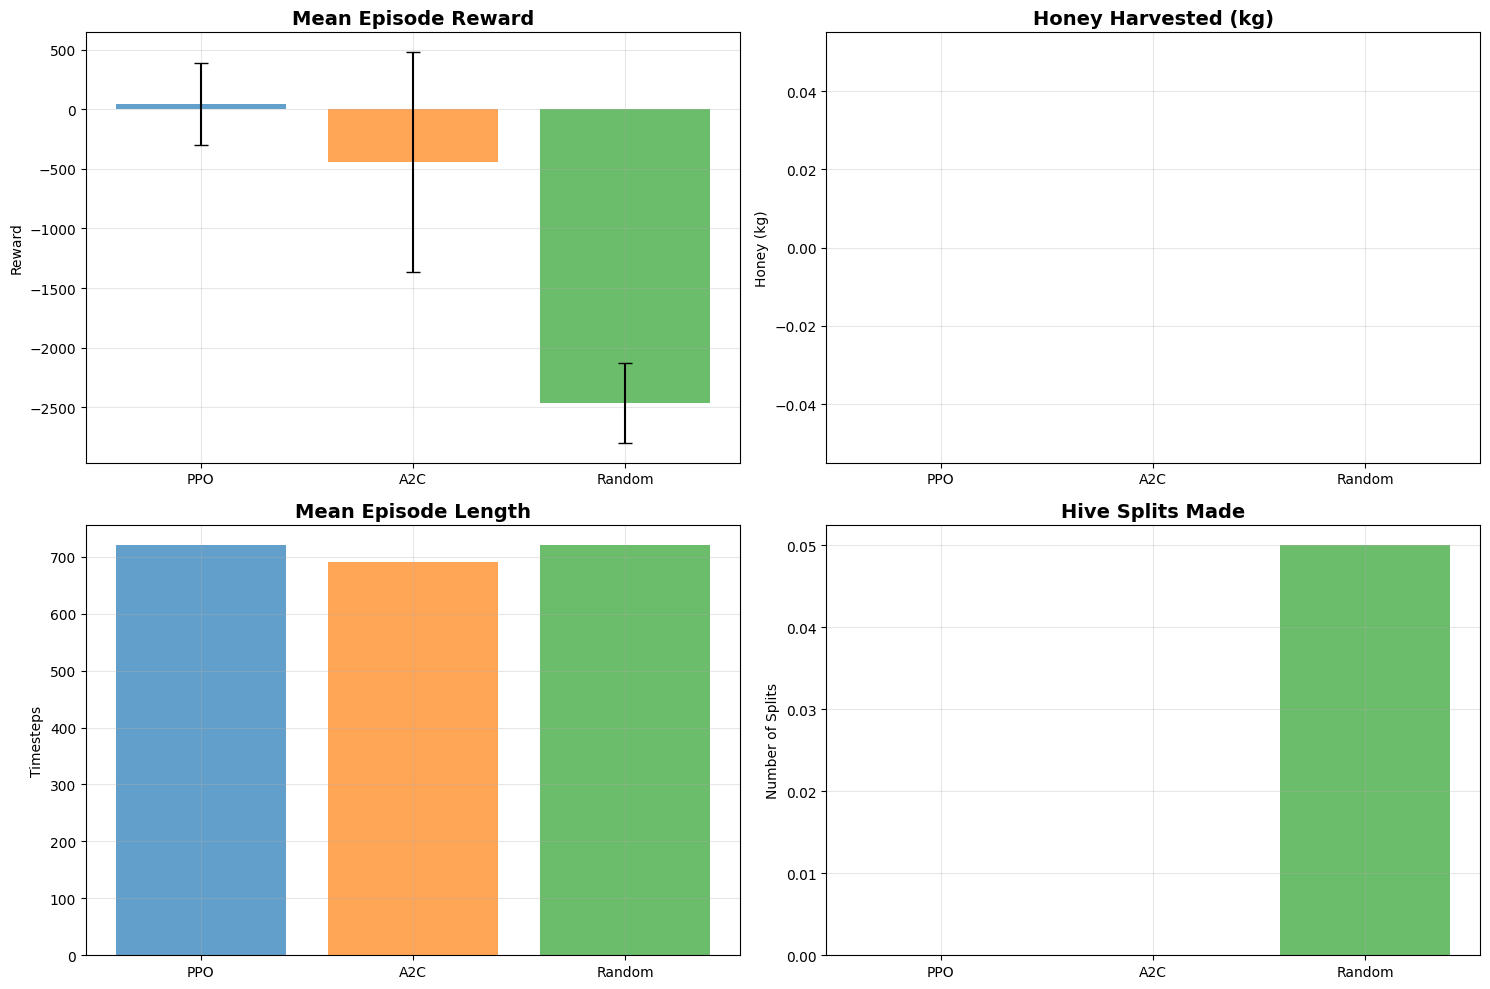

In [93]:
# Visualize Training Progress

print(f"\n{'='*70}")
print(" VISUALIZING TRAINING PROGRESS")
print('='*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Mean Reward Comparison
ax = axes[0, 0]
agents = results_df['agent_name']
rewards = results_df['mean_reward']
stds = results_df['std_reward']

ax.bar(agents, rewards, yerr=stds, capsize=5, alpha=0.7,
       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax.set_title('Mean Episode Reward', fontsize=14, fontweight='bold')
ax.set_ylabel('Reward')
ax.grid(True, alpha=0.3)

# 2. Honey Production
ax = axes[0, 1]
honey = results_df['mean_honey']
ax.bar(agents, honey, alpha=0.7,
       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax.set_title('Honey Harvested (kg)', fontsize=14, fontweight='bold')
ax.set_ylabel('Honey (kg)')
ax.grid(True, alpha=0.3)

# 3. Episode Length
ax = axes[1, 0]
lengths = results_df['mean_length']
ax.bar(agents, lengths, alpha=0.7,
       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax.set_title('Mean Episode Length', fontsize=14, fontweight='bold')
ax.set_ylabel('Timesteps')
ax.grid(True, alpha=0.3)

# 4. Splits Made
ax = axes[1, 1]
splits = results_df['mean_splits']
ax.bar(agents, splits, alpha=0.7,
       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax.set_title('Hive Splits Made', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Splits')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'agent_comparison.png', dpi=150, bbox_inches='tight')
print(f" Saved visualization: {MODEL_DIR / 'agent_comparison.png'}")
plt.show()


 TESTING BEST AGENT (PPO) ON FULL EPISODE
 BeehiveEnv initialized
   State space: (16,)
   Action space: 13 actions
📹 Running episode...

 Episode complete!
   Final reward: -80.24
   Honey harvested: 0.00 kg
   Splits made: 0
 Saved episode trajectory: /content/drive/MyDrive/AsaliAsPossible/models/best_agent_episode.png


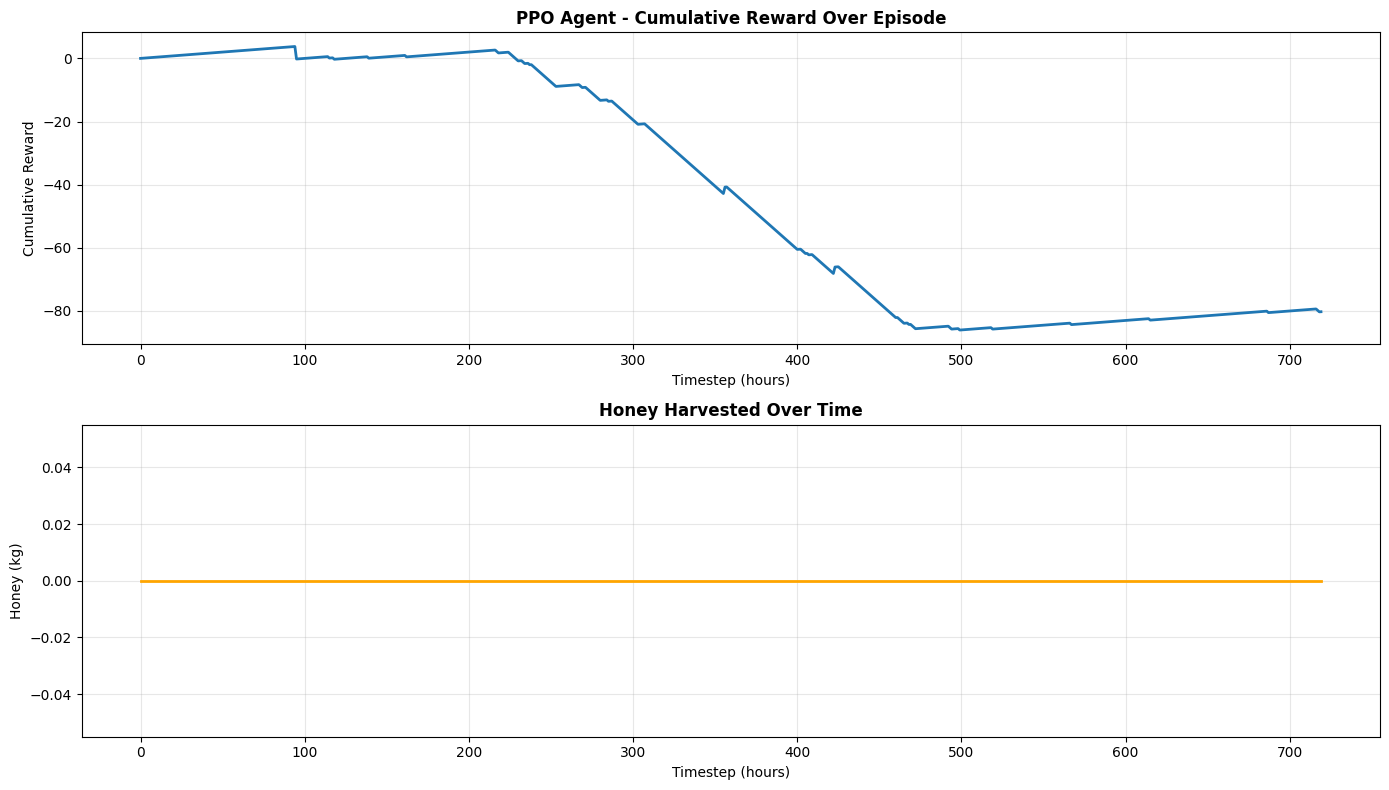

In [94]:
#  Test Best Agent on Full Episode

print(f"\n{'='*70}")
print(f" TESTING BEST AGENT ({best_agent}) ON FULL EPISODE")
print('='*70)

# Select best agent
if best_agent == 'PPO':
    test_agent = ppo_best
elif best_agent == 'DQN':
    test_agent = dqn_best
else:
    test_agent = a2c_best

# Run one full episode with rendering
test_env_single = BeehiveEnv(sensor_data, sensor_stats, sound_classifier)
obs, info = test_env_single.reset()

episode_data = {
    'step': [],
    'action': [],
    'reward': [],
    'cumulative_reward': [],
    'honey_harvested': []
}

print("📹 Running episode...")
for step in range(720):  # 30 days
    # Normalize observation
    obs_normalized = eval_env.normalize_obs(obs.reshape(1, -1))

    # Predict action
    action, _ = test_agent.predict(obs_normalized, deterministic=True)

    # Step
    obs, reward, terminated, truncated, info = test_env_single.step(action[0])

    # Log
    episode_data['step'].append(step)
    episode_data['action'].append(test_env_single.action_names[action[0]])
    episode_data['reward'].append(reward)
    episode_data['cumulative_reward'].append(info['cumulative_reward'])
    episode_data['honey_harvested'].append(info['honey_harvested'])

    # Render weekly
    if step % 168 == 0:
        test_env_single.render()

    if terminated or truncated:
        break

print(f"\n Episode complete!")
print(f"   Final reward: {info['cumulative_reward']:.2f}")
print(f"   Honey harvested: {info['honey_harvested']:.2f} kg")
print(f"   Splits made: {info['splits_made']}")

# Plot episode trajectory
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Cumulative reward
axes[0].plot(episode_data['step'], episode_data['cumulative_reward'], linewidth=2)
axes[0].set_title(f'{best_agent} Agent - Cumulative Reward Over Episode', fontweight='bold')
axes[0].set_xlabel('Timestep (hours)')
axes[0].set_ylabel('Cumulative Reward')
axes[0].grid(True, alpha=0.3)

# Honey harvested
axes[1].plot(episode_data['step'], episode_data['honey_harvested'], linewidth=2, color='orange')
axes[1].set_title('Honey Harvested Over Time', fontweight='bold')
axes[1].set_xlabel('Timestep (hours)')
axes[1].set_ylabel('Honey (kg)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'best_agent_episode.png', dpi=150, bbox_inches='tight')
print(f" Saved episode trajectory: {MODEL_DIR / 'best_agent_episode.png'}")
plt.show()


 ACTION DISTRIBUTION ANALYSIS
 Saved action distribution: /content/drive/MyDrive/AsaliAsPossible/models/action_distribution.png


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


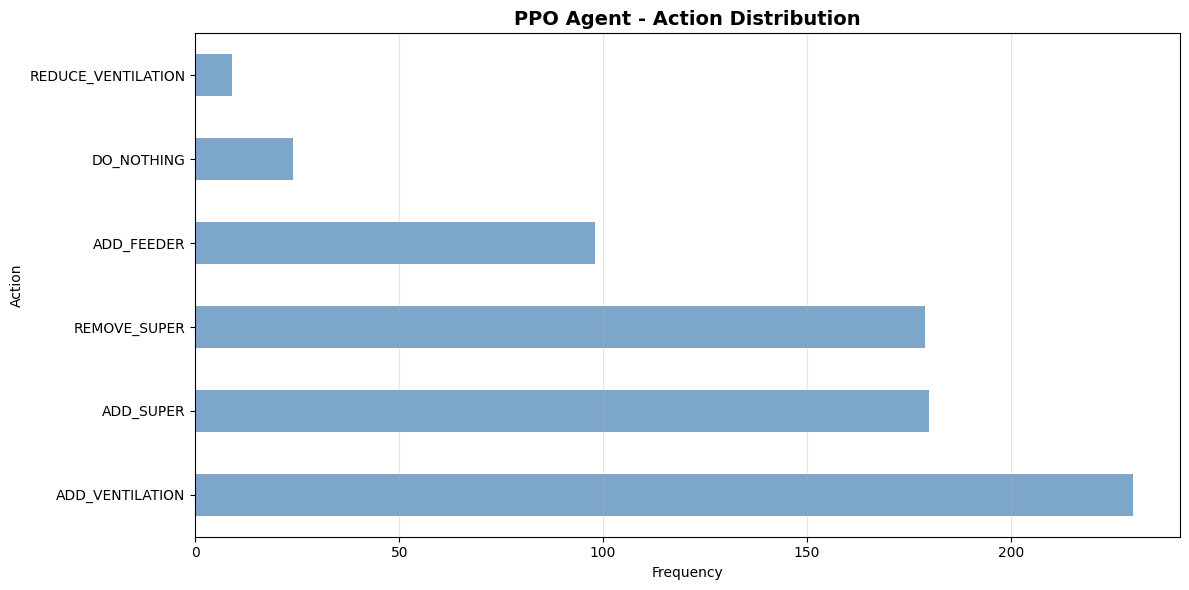


 Action Frequency:
   ADD_VENTILATION          :  230 ( 31.9%)
   ADD_SUPER                :  180 ( 25.0%)
   REMOVE_SUPER             :  179 ( 24.9%)
   ADD_FEEDER               :   98 ( 13.6%)
   DO_NOTHING               :   24 (  3.3%)
   REDUCE_VENTILATION       :    9 (  1.2%)


In [95]:
# Action Distribution Analysis

print(f"\n{'='*70}")
print(" ACTION DISTRIBUTION ANALYSIS")
print('='*70)

action_counts = pd.Series([a for a in episode_data['action']]).value_counts()

plt.figure(figsize=(12, 6))
action_counts.plot(kind='barh', color='steelblue', alpha=0.7)
plt.title(f'{best_agent} Agent - Action Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Frequency')
plt.ylabel('Action')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(MODEL_DIR / 'action_distribution.png', dpi=150, bbox_inches='tight')
print(f" Saved action distribution: {MODEL_DIR / 'action_distribution.png'}")
plt.show()

print(f"\n Action Frequency:")
for action, count in action_counts.items():
    pct = count / len(episode_data['action']) * 100
    print(f"   {action:25s}: {count:4d} ({pct:5.1f}%)")

In [96]:
# Save Training Metadata

print(f"\n{'='*70}")
print(" SAVING TRAINING METADATA")
print('='*70)

metadata = {
    'training_date': datetime.now().isoformat(),
    'total_timesteps': TOTAL_TIMESTEPS,
    'agents': ['PPO', 'DQN', 'A2C'],
    'best_agent': best_agent,
    'ppo_config': ppo_config,
    'dqn_config': dqn_config,
    'a2c_config': a2c_config,
    'results': results_df.to_dict('records'),
    'lstm_features': {
        'hidden_size': 128,
        'num_layers': 2,
        'output_dim': 128
    }
}

with open(MODEL_DIR / 'training_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f" Saved training metadata")


 SAVING TRAINING METADATA
 Saved training metadata


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [97]:
#  Final Summary
print(f"\n{'='*70}")
print(" TRAINING COMPLETE!")
print('='*70)

print(f"\n FINAL RESULTS:")
print(f"    Best Agent: {best_agent}")
print(f"    Best Reward: {results_df.loc[results_df['mean_reward'].idxmax(), 'mean_reward']:.2f}")
print(f"    Best Honey: {results_df.loc[results_df['mean_honey'].idxmax(), 'mean_honey']:.2f} kg")
print(f"    Improvement vs Random: {(results_df.loc[results_df['agent_name']==best_agent, 'mean_reward'].values[0] / results_df.loc[results_df['agent_name']=='Random', 'mean_reward'].values[0] - 1) * 100:.1f}%")

print(f"\n SAVED FILES:")
print(f"    {MODEL_DIR / 'ppo_best/best_model.zip'}")
print(f"    {MODEL_DIR / 'dqn_best/best_model.zip'}")
print(f"    {MODEL_DIR / 'a2c_best/best_model.zip'}")
print(f"    {MODEL_DIR / 'agent_comparison.csv'}")
print(f"    {MODEL_DIR / 'agent_comparison.png'}")
print(f"    {MODEL_DIR / 'best_agent_episode.png'}")
print(f"    {MODEL_DIR / 'training_metadata.json'}")

print(f"\n TENSORBOARD:")
print(f"   View training logs: tensorboard --logdir {LOGS_DIR}")

print(f"\n NEXT STEPS:")
print(f"   1  Analyze TensorBoard logs")
print(f"   2  Test on validation episodes")
print(f"   3  Deploy best model")
print(f"   4  Create inference API")

print(f"\n AsaliAsPossible RL Training Complete!")


 TRAINING COMPLETE!

 FINAL RESULTS:
    Best Agent: PPO
    Best Reward: 44.25
    Best Honey: 0.00 kg
    Improvement vs Random: -101.8%

 SAVED FILES:
    /content/drive/MyDrive/AsaliAsPossible/models/ppo_best/best_model.zip
    /content/drive/MyDrive/AsaliAsPossible/models/dqn_best/best_model.zip
    /content/drive/MyDrive/AsaliAsPossible/models/a2c_best/best_model.zip
    /content/drive/MyDrive/AsaliAsPossible/models/agent_comparison.csv
    /content/drive/MyDrive/AsaliAsPossible/models/agent_comparison.png
    /content/drive/MyDrive/AsaliAsPossible/models/best_agent_episode.png
    /content/drive/MyDrive/AsaliAsPossible/models/training_metadata.json

 TENSORBOARD:
   View training logs: tensorboard --logdir logs

 NEXT STEPS:
   1  Analyze TensorBoard logs
   2  Test on validation episodes
   3  Deploy best model
   4  Create inference API

 AsaliAsPossible RL Training Complete!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
